# Questions

## New:
transform(round(3)) raises an error

## Old:

1. The idea is to change the threshold in LogisticRegression, on which it divises positives from negatives. This information can be withdrawn with roc curve, right? But on roc curve you have the rates on every probability threshold, right? And on precision-recall curve as well. How to get access to confusion matrix at any threshold?
2. Or, if it's not possible, how to deduce either from ROC_AUC rates, or from Precision_Recall rates, at which threshold the ratio of False_Positive to False_Negative is N? (for example N=10, but can be 8 or 22 - depends how much costs to the bank the error of a wrong positive prediction vs a wrong negative one).
3. Gridsearch, the paramter "return_train_score", does it impact on the refit? Or it only it makes it show the train score? I'd like to make the refit based on the test score, not hte train one.
4. __The main question:__ the maskers in shap.LinearExplainer. my code doesn't work without it, but there are many examples where it's not required. Even on the sites in the recommendation list in "Ressources" section. How the code of other people works without these maskers?
5. What's the difference between the histogram HOUR_APPR_PROCESS_START and othrs, why this one looks like sawteeth but not the other variables histograms? How can I make the curve smoother?

## Old:
1. "Get feture importances", the section in the end of the notebook. How to get the features out from the pipeline, which is the outer wrapper? Or how to get the features from ColumnTransformer (which is called Preprocessor)?

I found in internet that this job is impossible when the column transformer contains Pipelines. But the inverse isn't mentioned as impossible.
This source https://scikit-learn-enhancement-proposals.readthedocs.io/en/latest/slep007/proposal.html sets the problem but doesn't offer a solution. It suggests to add feature_names_in_ attribute and get_feature_names_out method to fitted estimators. But I don't see how to do that.

2. kde graph, is there a way to reduce the wiggling of the curve? Can I stay with distribution and not pass to histograms? because of the difference of the scale.

In [1]:
# conda install -c conda-forge lightgbm
# pip install imbalanced-learn
# pip install shap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time # in Kernel just import time
from os import listdir

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline #, make_union
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
from sklearn.metrics import precision_score, recall_score, make_scorer, confusion_matrix, classification_report
from sklearn.metrics import auc, roc_auc_score, roc_curve, f1_score

from imblearn.pipeline import make_pipeline as make_pipeline_imblearn
from imblearn.over_sampling import SMOTE
# import imblearn
import shap


rasta = 1
rasta_smote = 1
rasta_class = 1


import gc
# from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
print(sklearn.__version__)#'0.24.2'
print(np.__version__) # '1.20.3'
print(pd.__version__)# '1.3.4'
# print(imblearn.__version__) # '0.9.0' # need to import the whole imblearn library to get the version

1.0.2
1.20.3
1.3.4


In [3]:
# from os import listdir
# path_csvs = 'C:\\Users\\Veronika\\DATABASES\\p7_credit_default_risk_dataset\\'
path_csvs = 'C:\\vb\\DATABASES\\p7_credit_default_risk_dataset\\'

list_files = [file for file in listdir(path_csvs)]

print(list_files)

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [4]:
# HomeCredit_columns_description = pd.read_csv(path_csvs + 'HomeCredit_columns_description.csv') # UnicodeDecodeError: 'utf-8' codec can't decode byte 0x85 in position 1283: invalid start byte

HomeCredit_columns_description = pd.read_csv(path_csvs + 'HomeCredit_columns_description.csv', encoding= 'unicode_escape')
HomeCredit_columns_description.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   219 non-null    int64 
 1   Table        219 non-null    object
 2   Row          219 non-null    object
 3   Description  219 non-null    object
 4   Special      86 non-null     object
dtypes: int64(1), object(4)
memory usage: 8.7+ KB


Clients income type (businessman, working, maternity leave,)

The unreadable symbol is an ellipsis. When I replaced it with "etc.", it raised an error in a later position: 26,931 instead of 1283. 
UnicodeDecodeError: 'utf-8' codec can't decode byte 0x85 in position 26931: invalid start byte


In [5]:
print(HomeCredit_columns_description.Table.unique())

['application_{train|test}.csv' 'bureau.csv' 'bureau_balance.csv'
 'POS_CASH_balance.csv' 'credit_card_balance.csv'
 'previous_application.csv' 'installments_payments.csv']


In [6]:
# HomeCredit_columns_description.loc[HomeCredit_columns_description.Table == 'POS_CASH_balance.csv', ['Row', 'Description']]

In [7]:
# HomeCredit_columns_description.loc[HomeCredit_columns_description.Table == 'credit_card_balance.csv', ['Row', 'Description']]


In [8]:
# HomeCredit_columns_description.loc[HomeCredit_columns_description.Table == 'previous_application.csv', ['Row', 'Description']]
# pd.reset_option('max_rows')

In [9]:
# HomeCredit_columns_description.loc[HomeCredit_columns_description.Table == 'installments_payments.csv', ['Row', 'Description']]


In [10]:
# pd.set_option('max_rows', None)
# HomeCredit_columns_description.loc[HomeCredit_columns_description.Special.notna(), ['Row', 'Description', 'Special']]
# pd.reset_option('max_rows')

In [11]:
pd.reset_option("max_rows")
pd.get_option("max_rows")

60

# Aplication table

In [12]:
appli_tr = pd.read_csv(path_csvs + 'application_train.csv')
# appli_tr = pd.read_csv(path_csvs + 'application_train.csv', nrows= 10_000)
appli_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [13]:
pd.set_option('max_colwidth', None)
pd.set_option('max_rows', None)

display(HomeCredit_columns_description.loc[HomeCredit_columns_description.Table == 'application_{train|test}.csv', ['Row', 'Description', 'Special']])

pd.reset_option('max_rows')

,Row,Description,Special
0,SK_ID_CURR,ID of loan in our sample,NaN
1,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",NaN
2,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,CODE_GENDER,Gender of the client,NaN
4,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,CNT_CHILDREN,Number of children the client has,NaN
7,AMT_INCOME_TOTAL,Income of the client,NaN
8,AMT_CREDIT,Credit amount of the loan,NaN
9,AMT_ANNUITY,Loan annuity,NaN


Something interesting about description:  
23	FLAG_EMP_PHONE	Did client provide work phone (1=YES, 0=NO)	 
24	FLAG_WORK_PHONE	Did client provide home phone (1=YES, 0=NO)	 WHAT?! The description doesn't match with the name! then, EMP_PHONE does it mean work phone as well as WORK_PHONE?  
26	FLAG_PHONE	Did client provide home phone (1=YES, 0=NO)	

In [14]:
print((appli_tr.FLAG_EMP_PHONE == appli_tr.FLAG_WORK_PHONE).all())
print((appli_tr.FLAG_WORK_PHONE == appli_tr.FLAG_PHONE).all())
print((appli_tr.FLAG_EMP_PHONE == appli_tr.FLAG_PHONE).all())

False
False
False


Well these are all three different types of phones! As the given description is identical for FLAG_WORK_PHONE and FLAG_PHONE, I will put it on the dashboard as it is given in the description.

## Categorical variables

### Feature alanysis

In [15]:
# appli_tr.describe() # 106 columns, hard to follow
test = appli_tr.describe(include=object).transpose()
# test['missing'] = (test['count'] / appli_tr.shape[0] * 100).transform(round) # transform(round(3)) raises an error
test['missing'] = ((1-test['count'] / appli_tr.shape[0]) * 100).transform(lambda x: x.round(3))
test['freq%top'] = test.freq / appli_tr.shape[0] * 100
test['count'] = appli_tr.shape[0] - test['count']

display(test)

,count,unique,top,freq,missing,freq%top
NAME_CONTRACT_TYPE,0,2,Cash loans,278232,0.000,90.478715
CODE_GENDER,0,3,F,202448,0.000,65.834393
FLAG_OWN_CAR,0,2,N,202924,0.000,65.989184
FLAG_OWN_REALTY,0,2,Y,213312,0.000,69.367275
NAME_TYPE_SUITE,1292,7,Unaccompanied,248526,0.420,80.818572
NAME_INCOME_TYPE,0,8,Working,158774,0.000,51.631974
NAME_EDUCATION_TYPE,0,5,Secondary / secondary special,218391,0.000,71.018923
NAME_FAMILY_STATUS,0,6,Married,196432,0.000,63.87804
NAME_HOUSING_TYPE,0,6,House / apartment,272868,0.000,88.734387
OCCUPATION_TYPE,96391,18,Laborers,55186,31.346,17.946025


In [16]:
selectcol = appli_tr.select_dtypes(include=object)
selectcol = selectcol.fillna('missing_value')
selectcol['SK_ID_CURR'] = appli_tr['SK_ID_CURR']
selectcol['TARGET'] = appli_tr['TARGET']

In [17]:
# FIXED THE BUG removed default value (which is a big database and memory-consuming). Now I must enter the my_df name every time I call the function
# # WARNING: if I don't put the same function every time, the notbook rises an error! That happens because parameter my_df stores the link to the object Dataframe. Instead of looking every time for the object we have a saved dataframe under the name selectcol

def find_most_risky(my_col, my_df, show=True):
    if show:
        print(appli_tr[my_col].value_counts(dropna=False))

    test = my_df.groupby(['TARGET', my_col])['SK_ID_CURR'].agg('size').unstack().fillna(0)

    test1 = pd.DataFrame() # which proportion of every value has failed the credit 
    for col in test: # how high chances are that a given person with a given value will fail the credit
#         print(col)
        test1[col] = test[col] / test[col].sum() * 100  # aggregate my mean instead
    test1 = test1.transpose().sort_values(1, ascending=False)
    test1['proportion'] = [(my_df[my_col] == value).mean() * 100 for value in test1.index]
    test1 = test1.sort_values('proportion', ascending=False)
#     test1 = test1.sort_values(1, ascending=False)
    
    if test1.shape[0] > 2:
        print(test1[1].max() / (test1[1].min() + 0.00001), 'times varies the probability to fail')
        print(test1[1].max() / test1.iloc[0, 1], 'times the highest probability is higher than the most frequent one.')
    
    print('ratio of fail for second major class to fail for the major one is', test1.iloc[1, 1] / test1.iloc[0, 1])
    print('ratio of fail for the major class to fail for second major one is', test1.iloc[0, 1] / test1.iloc[1, 1])
    if show:
        display(test1)
    return test1#.reset_index()

For every categorical column, I calculate how many percents of loaners are failed their loan for every available value. That allows to estimate is there's a difference, and approximately estimate how strong this difference is. In other words, how strong is the impact of this feature on target, regardless other features.

It doesn't take into account the interactions between variables. Like, that that the a1&b1 is good, a2&b2 is good, but a2&b1 is bad, a1b2 is bad. Like a saddle point. But alltogether over "a" or "b", you only see no difference in probability.

With the high impact features (that I will see at the step of Shap values explication), I will try to replace these columns with the probability of find 1 and see whether the model performance decreases.
About low impact values, with low shap values, I will delete these values and see whether, and how much, the performance drops.

In [18]:
# find_most_risky('NAME_CONTRACT_TYPE', selectcol) # cash 8.3, revolving 5.4
# find_most_risky('CODE_GENDER', selectcol) # F 7.0, M 10.1, XNA equals NaN 0 (0 out of 4 people)
# find_most_risky('FLAG_OWN_CAR', selectcol)
# find_most_risky('FLAG_OWN_REALTY', selectcol) # No 8.32 Yes 7.96
# find_most_risky('NAME_TYPE_SUITE', selectcol) # NaN 5.4(min), Other_B 9.8 (max value)
# find_most_risky('NAME_INCOME_TYPE', selectcol) # Businessman 0(min value), maternity leave 40 (max value), unemployed 36.4
# find_most_risky('NAME_EDUCATION_TYPE', selectcol) # correlation, but not linear: monotonic, but not proportional! academic 1.8, lower secondary 10.9
# find_most_risky('NAME_FAMILY_STATUS', selectcol) # widow 5.8(min), civil marriage 9.9(max), single 9.8, unknown = NaN 0 (0 out of 2)
# find_most_risky('NAME_HOUSING_TYPE', selectcol) # office appartment 6.5(min), rented apartment 12.3 (max value), with parents 11.7
# find_most_risky('OCCUPATION_TYPE', selectcol) # 19 DIMENSIONS! accountants 4.8(min), low-skill Laborers 17.1 (max value)
# find_most_risky('WEEKDAY_APPR_PROCESS_START', selectcol) # Mon7.75(min), Sat7.78, Sun7.92, Tue8.35(max). delete?
# find_most_risky('ORGANIZATION_TYPE', selectcol) # 58 DIMENSIONS! tradeType4 3.12(min), transportType3 15.75(max)
# find_most_risky('FONDKAPREMONT_MODE', selectcol) # orgSpecAcc 5.8 (min), unknown 8.6 (max), "not specified" means NaN 7.5
# find_most_risky('HOUSETYPE_MODE', selectcol) # blockOfFLats 6.9, specificHousing 10.1(max), NaN 9.15
# find_most_risky('WALLSMATERIAL_MODE', selectcol) # Monolithic 4.72(min), wooden 9.69, unknown 9.12
find_most_risky('EMERGENCYSTATE_MODE', selectcol) # No 7.0, Yes 9.57, NaN 9.26

No     159428
NaN    145755
Yes      2328
Name: EMERGENCYSTATE_MODE, dtype: int64
1.3753283914169894 times varies the probability to fail
1.3753303660734624 times the highest probability is higher than the most frequent one.
ratio of fail for second major class to fail for the major one is 1.329630923037425
ratio of fail for the major class to fail for second major one is 0.7520884048902743


TARGET,0,1,proportion
No,93.035100,6.964900,51.844649
missing_value,90.739254,9.260746,47.398304
Yes,90.420962,9.579038,0.757046


TARGET,0,1,proportion
No,93.035100,6.964900,51.844649
missing_value,90.739254,9.260746,47.398304
Yes,90.420962,9.579038,0.757046


How do I take decision based on what "find the most risky" function shows:
- If some values have high risks (above 20%), it may worth to include this variable anyway. Look individually.
- Is the distribution of the values balanced? If at least 20% is in a class other than the major, Iconsider it "balanced". In other words, if at least 2 classes have the proportion above 20% or, it's balanced. Then, if the ratio (maximal probability of fail class)/(minimal probability of fail class) is 1.5 or higher, I KEEP THIS FEATURE.
- Otherwise, the distribution is imbalanced. If there's only 1 class above 20% occurence.
- Then I use a grid, created more or less arbitrarily:
    - if the minor class is above 10% proportion, increase in fail probability should be at least 75%.
    - if the minor class is above 5%, the increase in probability should be at least 100% (probability 2 times higher)
    - if the minor class is above 2%, the increase in probability should be at least 100% (probability 3 times higher) 
    - if the minor class is above 1%, the increase in probability should be at least 200% (probability 4 times higher)
This is an approximate guideline. If I see individual cases that suggest it worth keep the variable, I will keep it.

- NAME_CONTRACT_TYPE: cash 8.3, revolving 5.4 (9.5%) DROP THIS FEATURE? the fail risk for the minor class doesn't increase, but decrease. On the other hand, the ratio is significant, 1.52 times. I will keep it, but will also try the model without this feature. __UPD: apparently the performance is a bit lower without it, so I will keep it.__
- CODE_GENDER: F 7.0, M 10.1, XNA equals NaN 0 (0 out of 4 people) REPLACE VALUE XNA. Redo the analysis. KEEP THIS FEATURE: balanced distribution, keep the variable.  -> feature engineering (combine with age, see section "Integer values")
- FLAG_OWN_CAR: No 8.5, Yes 7.2(35%) DROP THIS FEATURE? the ratio is 1.17, according to my metrics I should drop it. well let's keep it but I suggest to compare to try without it as well. __UPD: apparently the performance is a bit lower without it, so I will keep it.__
- FLAG_OWN_REALTY: No 8.32 Yes 7.96(35%) DROP THIS FEATURE? yes. balanced distribution, but ratio only 1.05
- NAME_TYPE_SUITE: NaN 5.4(min), Other_B 9.8 (max value) DROP THIS FEATURE? yes. distribution is almost balanced. The chance of fail is actually not increasing forthe second major class, but decreasing. Though not a lot, less than 10%. The most risky group is 1.2 times higher than the major group, but the proportion of those people is tiny.
- NAME_INCOME_TYPE: Businessman 0(min value), maternity leave 40 (max value), unemployed 36.4 DROP THIS FEATURE? no! we have the categories Maternity_leave with 40% risk of fail (0.1% cases) and Unemployed with 36.4% (0.7%)
- NAME_EDUCATION_TYPE: keep this feature: balanced distribution, second major class is 60% from the major one to fail.
- NAME_FAMILY_STATUS: widow 5.8(min), civil marriage 9.9(max), single 9.8, unknown = NaN 0 (0 out of 2)  DROP THIS FEATURE? the ratio is 1.17, according to my metrics I should drop it. well let's keep it but I suggest to compare to try without it as well. __UPD: no effect on the success of the model. We can drop it.__
- NAME_HOUSING_TYPE: office appartment 6.5(min), rented apartment 12.3 (max value), with parents 11.7  DROP THIS FEATURE? the best is to modify this variable:
    - With parents(11.7) or rented(12.3) = A, others = B. Maybe office appartment (6.6%) = C
        but this will lead to overfitting of the model.
    but it's worth keeping - the metrics indicate variable is valuable. I will keep it, but will also try the model without this feature.__UPD: apparently the performance is a bit lower without it, so I will keep it.__
- OCCUPATION_TYPE: 19 DIMENSIONS! accountants 4.8(min), low-skill Laborers 17.1 (max value)  DROP THIS FEATURE? one of the approaches is to modify the values: 
    - name "low-skill laborers" (17%) "low-skill laborers and unemployed",
    - group Drivers, Waiters/barmen staff, Security staff, Laborers, Cooking staff, Sales staff, Cleaning staff (11.2-9.6)
    - group the rest (7.8-6.15)
    - Accountants (4.8%)  
But that may cause model overfitting: because we group variables based on target
- WEEKDAY_APPR_PROCESS_START: DROP THIS FEATURE? certainly yes: the difference is minor
- ORGANIZATION_TYPE: 58 DIMENSIONS! tradeType4 3.12(min), transportType3 15.75(max) DROP THIS FEATURE? one :
    - put separately 1st 3 (16 - 12.5)
    - group next 4 (11.7 - 11.1)
    - group next 12 (10.6 - 8.9)
    - group next 24 (8.6 - 6.4)
    - group last 15 (6.1- 3.1)  
But that may cause model overfitting: because we group variables based on target
- FONDKAPREMONT_MODE: orgSpecAcc 5.8 (min), unknown 8.6 (max), DROP THIS FEATURE? balanced distribution, the difference is slightly above the metric. I would suggest to drop it, but also compare the results with this metric and without it. __UPD: no effect on the success of the model. We can drop it.__
- HOUSETYPE_MODE: blockOfFLats 6.9, specificHousing 10.1(max), NaN 9.15 DROP THIS FEATURE? well it doesn't fit in the metric. According to my metrics I should drop it. well let's keep it but I suggest to compare to try without it as well. __UPD: no effect on the success of the model. We can drop it.__
- WALLSMATERIAL_MODE: well it doesn't fit in the metric. According to my metrics I should drop it. well let's keep it but I suggest to compare to try without it as well. __UPD: no effect on the success of the model. We can drop it.__
- EMERGENCYSTATE_MODE: well it doesn't fit in the metric. According to my metrics I should drop it. well let's keep it but I suggest to compare to try without it as well. __UPD: apparently the performance is a bit lower without it, so I will keep it.__ Maybe it's because there are only 2 values, Yes and No, it's like a flag?

### Function for replacement of categorical variable to the proportion of fails, given the value

The purpose is to reduce dimensions. The potential drawback is that the train test split will be not homogenous, which will create the biased probabilities/weights of fail. But it worth trying, because it allows to reduce the dimension of 'OCCUPATION_TYPE' from 19 to 1 and 'ORGANIZTION_TYPE' from 58 to 1.

I will apply this function after the exploration of numeric variables. Because each converted variable changes type from "object" to "float" and will bother on the float variables exploration step.

In [19]:
def category_to_fail_proportion(my_df, my_series, fill=True): # my_series should be a string
    probas_table = find_most_risky(my_series, my_df=my_df, show=False)
    proba_series = my_df[my_series].transform(lambda x: probas_table.loc[x, 1]) # works faster than the "for" cycle with item and lines selection for every item
    if fill:
        proba_series = proba_series.fillna(probas_table.iloc[0, 1])
    return proba_series#, probas_table


WARNING: I never can apply this function because it leads to overfitting of the model: it uses the target (y) for the calculation of the features (X).
Though, this function can be applied, if during cross-validation the probabilities are withdrawn only from train set and then imputed in test set as is.

### Values imputing strategy: Cautious strategy
The strategy is not the same for filling the train set and the test set:
- For the test set, if we don't know the value, we shall use the most "risky" variant: the value that gives the highest rate of positive target.
- For the train set, we know the traget. So, if the target is negative, no need to set the parameter to the "most risky" category. I will assign it to the a category (more on that later), if the number of missing values is below the limit (let's say arbitrarily, 5%) and to a standalone "unknown" category, if the number of missing values is above this limit.
- How to choose a category: we already know the target value. So, for the positive target we give the "most risky" value to the unknown. For the negative target, we give the most frequent value, doesn't matter what's the risk (can be the most risky, the least, or somewhere in the middle, we just take the most frequent).
- The drawback of such a distiction on the category: we risk to overfit our model. But, we will overfit it in a lopsided way: the model will tend to give more importance on the imputed features to lead to positive target. But this drawback plays on our side at the end of the game: as on test set we impute the "most risky" value every time, the model will give more false negatives, but will be much less likely to let pass the false positives. That means, we can explain the refuse to a client based on the features that were not provided by the client, so the client knows what cells (s)he has to modify or fill.
- How we detect "the most risky" category: by groupby-aggregation test. Look the correlation between positive target (credit fail) and different values. See the proportion of people who failed to pay their credit for every value. The value with the highest proportion of positive target is "the most risky" one.
- How to store "the most risky" values: maybe as a dictionary. The key is the feature that we want to impute, the value is the most risky category.

#### When to apply cautious strategy
When we suppose that a false positive is significantly more costly to the bank than a false negative is. If it happens that the difference between the cost of false negative and false positive is insignificant for the bank, we can pass to simplified strategy.
### Values imputing strategy: Simplified strategy
Impute with "the most risky" value for test set and with the most frequent value for the train set.
### Values imputing strategy: Simplest strategy
Impute with the most frequent value for both train and test sets.
### How to handle the values which are already imputed as "unknown", "not specified", "XNA" or similar
When you look through unique values, you might notice that some categorical values are filled with "unknown", "not_specified", "XNA" or similar kinds of values. All that means "NaN", basically.
The best of all would be to ask a confirmation on the business side, whether it's indeed smth like "this info is lacking", which equelas NaN.

If it is so, the best is to delete these values/replace by "NaN", and then apply the standard algorithm, described before.

Example: GENDER_CODE. Among 307511 applications, 4 applicants have "XNA" value. It's like "nan", just it's filled with text. So I will replace "XNA" with "nan", and then treat it along the general algorithm:
    it's less than 5% NaNs, so impute 
    -with most risky for test set, 
    -with  most risky for train set positive target, 
    - with most frequent for train set negtive target.
The most risky value from groupby-aggreagtion test is "M".

WARNING: I never can apply the "Cautious strategy" (neither "Simplified strategy") because it leads to overfitting of the model: it uses the target (y) for the calculation of the features (X).
Though, both these strategies can be applied, if during cross-validation the probabilities are withdrawn only from train set and then imputed in test set as is.

### Which imputing  and/or replacing strategy is better for each of missing categorical values

CODE_GENDER: Unknown is the least failed category. With the simplest strategy we tend to rise the failure impact from 0 to 7.0. With cautious strategy - rise even higher, from 0 to 10.1. __Simplest__ strategy is closer to reality.
_the proportion of NaNs is low, 0.001%, we can't take them into a separated category_

NAME_TYPE_SUITE: Unknown is the least failed category. With the simplest strategy we tend to rise the failure impact from 5.4 to 8.2. With cautious strategy - rise even higher, from 5.4 to 9.8. __Simplest__ strategy is closer to reality.
_the proportion of NaNs is low, 0.42%, we can't take them into a separated category_

NAME_FAMILY_STATUS: Unknown is the least failed category. With the simplest strategy we tend to rise the failure impact from 0 to 7.56. With cautious strategy - rise even higher, from 0 to 9.94. __Simplest__ strategy is closer to reality.
_the proportion of NaNs is low, 0.001%, we can't take them into a separated category_

OCCUPATION_TYPE: With the simplest strategy we tend to rise the failure impact from 6.5 to 10.5 (most frequent group is Laborers). With cautious strategy - rise even higher, from 6.5 to 17.1. __Simplest__ strategy is closer to reality.
_as the proportion of NaNs is higher than 5%, we can take them apart, and this is better than both simplest or cautious_

FONDKAPREMONT_MODE: With the simplest strategy we tend to bring down the failure impact from 8.6 to 7.0 (most frequent group is reg oper account). With cautious strategy - bring down less, from 8.6 to 7.5. __Cautious__ strategy is closer to reality.
Here, as we have the category "not specified", we can combine them. That would be equal to cautious strategy.
Or, _as the proportion of NaNs is higher than 5%, we can take them apart. This solution will bring en extra dimension, so let's just replace "not specified" with NaN and combine with NaNs into a separate category._

HOUSETYPE_MODE: With the simplest strategy we tend to bring down the failure impact from 9.15 to 7.0 (most frequent group is block of flats). With cautious strategy - to rise the failure from 9.15 to 10.1. __Cautious__ strategy is closer to reality.
Here, as we have the category "not specified", we can combine them. That would be equal to cautious strategy.
_as the proportion of NaNs is higher than 5%, we can take them apart. This solution will bring en extra dimension._

WALLSMATERIAL_MODE: With the simplest strategy we tend to bring down the failure impact from 9.1 to 6.3 (most frequent group is panel). With cautious strategy - to rise the failure from 9.1 to 9.7. __Cautious__ strategy is closer to reality.
_as the proportion of NaNs is higher than 5%, we can take them apart. This solution will bring en extra dimension._

EMERGENCYSTATE_MODE: With the simplest strategy we tend to bring down the failure impact from 9.3 to 7.0 (most frequent group is No). With cautious strategy - to rise the failure from 9.3 to 9.6. __Cautious__ strategy is closer to reality.
_as the proportion of NaNs is higher than 5%, we can take them apart. This solution will bring en extra dimension._

In [20]:
appli_tr.select_dtypes(include=object).loc[:, appli_tr.isnull().any()].columns

Index(['NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

At this step, I will replace all the missing values with simplest strategy, but I will choose the string to fill by different strategies: simplest where it's closer to reality, cautious where it's closer to reality.

In [21]:
appli_tr.loc[appli_tr.CODE_GENDER == 'XNA', 'CODE_GENDER'] = 'F' # as most frequent: only 4 people of 307,511 have XNA value
appli_tr.loc[appli_tr.NAME_FAMILY_STATUS == 'Unknown', 'NAME_FAMILY_STATUS'] = 'Single / not married' # only 2 people of 307,511 have Unknown value, and I don't want to create a new OneHotEncoded variable which has only 2 "1"s. why single: as "default status" or "initial status" of a person

In [22]:
appli_tr['NAME_TYPE_SUITE'] = appli_tr.NAME_TYPE_SUITE.fillna('Unaccompanied') # most frequent
appli_tr['OCCUPATION_TYPE'] = appli_tr.OCCUPATION_TYPE.fillna('unknown') # new category
appli_tr['FONDKAPREMONT_MODE'] = appli_tr.FONDKAPREMONT_MODE.fillna('not specified') # merged with "not specified", most frequent
appli_tr['HOUSETYPE_MODE'] = appli_tr.HOUSETYPE_MODE.fillna('unknown') # new category
appli_tr['WALLSMATERIAL_MODE'] = appli_tr.WALLSMATERIAL_MODE.fillna('Others') # most "neutral", when we don't know
appli_tr['EMERGENCYSTATE_MODE'] = appli_tr.EMERGENCYSTATE_MODE.fillna('Yes') # we may expect the worst


### Feature selection
This is an iterative process, because I look at the results of shap explanation, and then check if the performance stays stable if I remove this value.

In [23]:
appli_tr = appli_tr.drop(['WEEKDAY_APPR_PROCESS_START', 
#                           'FLAG_OWN_CAR', 
                          'FLAG_OWN_REALTY',
                          'NAME_TYPE_SUITE',
                          'NAME_FAMILY_STATUS',
#                           'ORGANIZATION_TYPE',
                          'FONDKAPREMONT_MODE',
                          'HOUSETYPE_MODE',
                          'WALLSMATERIAL_MODE',
#                           'EMERGENCYSTATE_MODE' # has just 1 column
                         ], axis=1)

## Flags
Let's look for the most risky category for each falag value. Flags are integers, but since they have finite numbers of values, I can apply to them "find the most risky" function, the same way that I did to categorial variables.

This function will allow to see fast whether there's a correlation between the target and these integers with limited ans small number of values they can take.

Eventually I can check in this same way even the integers that have more than 2 or 3 flag values.
Like I checked the categorical having 58 values.

In [24]:
# appli_tr.describe() # 106 columns, hard to follow
test = appli_tr.describe(include=int).transpose()[6:].sort_values('std')
# first 12 lines were finally deleted except FLAG_DOC_21
# nothing is missing! if there are NaNs, the column datatype switches from int to float
# display(test)

We don't have missing values (because if you do, the column datatype will turn to float right away), so no need to impute

In [25]:
selectcol = appli_tr.select_dtypes(include=int)
selectcol = selectcol.fillna(900_000)
selectcol['SK_ID_CURR'] = appli_tr['SK_ID_CURR']
selectcol['TARGET'] = appli_tr['TARGET']
selectcol['CNT_FAM_MEMBERS'] = appli_tr['CNT_FAM_MEMBERS'].fillna(900_000)

In [26]:
# find_most_risky('FLAG_MOBIL', selectcol) 
# find_most_risky('FLAG_EMP_PHONE', selectcol) 
# find_most_risky('FLAG_WORK_PHONE', selectcol)
# find_most_risky('FLAG_CONT_MOBILE', selectcol)
# find_most_risky('FLAG_PHONE', selectcol) 
# find_most_risky('FLAG_EMAIL', selectcol) 

find_most_risky('REGION_RATING_CLIENT', selectcol) # 11%, 7% and 4% fail. absolutely need to include.
find_most_risky('REGION_RATING_CLIENT_W_CITY', selectcol) # the same. check if correlates with REGION_RATING_CLIENT

# find_most_risky('REG_REGION_NOT_LIVE_REGION', selectcol) 
# find_most_risky('REG_REGION_NOT_WORK_REGION', selectcol) 
# find_most_risky('LIVE_REGION_NOT_WORK_REGION', selectcol) 
# find_most_risky('REG_CITY_NOT_LIVE_CITY', selectcol)
# find_most_risky('REG_CITY_NOT_WORK_CITY', selectcol)
# find_most_risky('LIVE_CITY_NOT_WORK_CITY', selectcol)

# find_most_risky('FLAG_DOCUMENT_2', selectcol) # 30% fail with 1 (of 30 people), 8% fail with no 
# find_most_risky('FLAG_DOCUMENT_3', selectcol) # 8.8 vs 6.1 to fail. DROP THIS FEATURE? yes
# find_most_risky('FLAG_DOCUMENT_4', selectcol) # 25 people have flag, target 0 of 25. it's like doc2 but inverse
# find_most_risky('FLAG_DOCUMENT_5', selectcol) # 8.07 vs 8.0. DROP THIS FEATURE
# find_most_risky('FLAG_DOCUMENT_6', selectcol) # 8.3 vs 5.56 to fail
# find_most_risky('FLAG_DOCUMENT_7', selectcol) # 8.1 vs 5.1 to fail, 57 people have it. drop? no
# find_most_risky('FLAG_DOCUMENT_8', selectcol) # 8.1 vs 7.3 to fail. 25,000 people have it. drop? no
# find_most_risky('FLAG_DOCUMENT_9', selectcol) # 8.1 vs 6.1 to fail.  1200 people have it. drop? no
# find_most_risky('FLAG_DOCUMENT_10', selectcol) # 7 people have flag, target 0 of 7. DROP THIS FEATURE
# find_most_risky('FLAG_DOCUMENT_11', selectcol) # 8.1 vs 6.2 to fail, 1203 pepole have it. drop? no
# find_most_risky('FLAG_DOCUMENT_12', selectcol)  # 2 people have flag, target 0 of 2. drop? no. but only 2 people
# find_most_risky('FLAG_DOCUMENT_13', selectcol) # 8.1 (all) vs 2.7 (1200 people)
# find_most_risky('FLAG_DOCUMENT_14', selectcol) # 8.1 vs 3.3 (903 people)
# find_most_risky('FLAG_DOCUMENT_15', selectcol) # 8.1 vs 3.0 (372 people)
# find_most_risky('FLAG_DOCUMENT_16', selectcol) # 8.1 vs 4.9 (3,000 people)
# find_most_risky('FLAG_DOCUMENT_17', selectcol) # 8.1 vs 2.4 (82 people). drop? no. but there are few people
# find_most_risky('FLAG_DOCUMENT_18', selectcol) # 8.1 vs 5.7 (2500 people)
# find_most_risky('FLAG_DOCUMENT_19', selectcol) # 8.1 vs 6.55 (183 people). drop? no. but there are few people
# find_most_risky('FLAG_DOCUMENT_20', selectcol) # 8.1 vs 8.3(156 people). DROP THIS FEATURE
# find_most_risky('FLAG_DOCUMENT_21', selectcol) # 8.1 vs 13.6 (103 people)


2    226984
3     48330
1     32197
Name: REGION_RATING_CLIENT, dtype: int64
2.3033326451786196 times varies the probability to fail
1.407363503997728 times the highest probability is higher than the most frequent one.
ratio of fail for second major class to fail for the major one is 1.407363503997728
ratio of fail for the major class to fail for second major one is 0.7105484810139103


TARGET,0,1,proportion
2,92.110898,7.889102,73.813294
3,88.897165,11.102835,15.716511
1,95.179675,4.820325,10.470195


2    229484
3     43860
1     34167
Name: REGION_RATING_CLIENT_W_CITY, dtype: int64
2.355367469001958 times varies the probability to fail
1.4400769898518853 times the highest probability is higher than the most frequent one.
ratio of fail for second major class to fail for the major one is 1.4400769898518853
ratio of fail for the major class to fail for second major one is 0.6944073178357304


TARGET,0,1,proportion
2,92.082237,7.917763,74.626274
3,88.597811,11.402189,14.262904
1,95.159072,4.840928,11.110822


TARGET,0,1,proportion
2,92.082237,7.917763,74.626274
3,88.597811,11.402189,14.262904
1,95.159072,4.840928,11.110822


- FLAG_MOBIL: 1 person without mobile, target 0. DROP THIS FEATURE? certainly yes
- FLAG_EMP_PHONE: 8.6 vs 5.4 (55,000 people) KEEP
- FLAG_WORK_PHONE: 9.6 vs 7.7(61,000 people) balanced distribution, the ratio is 1.25  __UPD: apparently the performance is a bit lower without it, so I will keep it.__
- FLAG_CONT_MOBILE: 8.1 vs 7.8(574 people) imbalanced distribution, the ratio is 1.02 DROP THIS FEATURE? certainly yes
- FLAG_PHONE: 8.5 vs 7.0 (86,000 people) balanced distribution, the ratio is 1.2 __UPD: apparently the performance is a bit lower without it, so I will keep it.__
- FLAG_EMAIL:  8.1 vs 7.9 (17400 people) imbalanced distribution, the ratio is 1.02 DROP THIS FEATURE? certainly yes

- REGION_RATING_CLIENT: 11%, 7% and 4% fail. this is an ordinal variable. With clear correlation! Must include.
- REGION_RATING_CLIENT_W_CITY: 11%, 7% and 4% fail. check whether correlates with REGION_RATING_CLIENT  __correlates almost entirely, I drop REGION_RATING_CLIENT and keep REGION_RATING_CLIENT_W_CITY.__

- REG_REGION_NOT_LIVE_REGION: 8.1 vs 9.3 (4500 people) imbalanced distribution, the ratio is 1.15 DROP? certainly yes
- REG_REGION_NOT_WORK_REGION: 8.1 vs 8.9 (15,000 people) imbalanced distribution, the ratio is 1.10 DROP? certainly yes
- LIVE_REGION_NOT_WORK_REGION: 8.1 vs 8.4 (12,000 people) imbalanced distribution, the ratio is 1.05 DROP? certainly yes
- REG_CITY_NOT_LIVE_CITY: 7.7 vs 12.2 (24,000 people) less imbalanced distribution, the ratio is 1.58 KEEP
- REG_CITY_NOT_WORK_CITY: 7.3 vs 10.6 (70,000 people) balanced distribution, the ratio is 1.3 DROP? 
- LIVE_CITY_NOT_WORK_CITY: 7.6 vs 10.0 (55,000 people) DROP? __UPD: apparently the performance is a bit lower without it, so I will keep it.__

- FLAG_DOCUMENT_2: 30% fail with 1 (of 30 people), 8% fail with no KEEP
- FLAG_DOCUMENT_3: 8.8 vs 6.1 to fail. balanced distribution, ratio 1.43 KEEP
- FLAG_DOCUMENT_4: 25 people have flag, target 0 of 25. DROP THIS FEATURE? yes. it would be important if we were hunting the precision. __UPD: can drop__
- FLAG_DOCUMENT_5:  imbalanced distribution, the ratio is 1.00 DROP THIS FEATURE? certainly yes
- FLAG_DOCUMENT_6: 8.3 vs 5.56 to fail imbalanced distribution 10:1, the ratio is 0.66 DROP THIS FEATURE? yes. it would be important if we were hunting the precision. __UPD: apparently the performance is a bit lower without it, so I will keep it.__
- FLAG_DOCUMENT_7: 8.1 for 0 vs 5.1 for 1 to fail, 57 people have 1. DROP THIS FEATURE? certainly yes. it would be important if we were hunting the precision. __UPD: can drop__
- FLAG_DOCUMENT_8: 8.1 for 0 vs 7.3 for 1 to fail. 25,000 people have 1. imbalanced distribution 10:1, the ratio is 0.90 DROP THIS FEATURE? certainly yes. it would be important if we were hunting the precision.
- FLAG_DOCUMENT_9: 8.1 vs 6.1 to fail.  1200 people have it. imbalanced distribution 100:1, the ratio is 0.76 (1.3 times lower for minor value) DROP THIS FEATURE? yes. it would be important if we were hunting the precision.
- FLAG_DOCUMENT_10: 7 people have flag, target 0 of 7. DROP THIS FEATURE? yes. it would be important if we were hunting the precision. __UPD: can drop__
- FLAG_DOCUMENT_11: imbalanced distribution 100:1, the ratio is 0.76 DROP THIS FEATURE? yes. it would be important if we were hunting the precision.
- FLAG_DOCUMENT_12: 2 people have flag, target 0 of 2.  DROP THIS FEATURE? certainly yes. it would be important if we were hunting the precision.  __UPD: can drop__
- FLAG_DOCUMENT_13: 8.1 for 0 (all) vs 2.7 for 1 (1200 people)  imbalanced distribution 300:1, the ratio is 0.34 (3 times lower for minor value) DROP THIS FEATURE? yes. it would be important if we were hunting the precision.  __UPD: apparently the performance is a bit lower without it, so I will keep it.__
- FLAG_DOCUMENT_14: 8.1 for 0 vs 3.3 for 1 (903 people) imbalanced distribution 350:1, the ratio is 0.41 (2.5 times lower for minor value) DROP THIS FEATURE? yes. it would be important if we were hunting the precision.  __UPD: apparently the performance is a bit lower without it, so I will keep it.__
- FLAG_DOCUMENT_15: 8.1 for 0 vs 3.0 for 1 (372 people) imbalanced distribution 800:1, the ratio is 0.36 (2.5 times lower for minor value) DROP THIS FEATURE? yes. it would be important if we were hunting the precision.  __UPD: can drop__


- FLAG_DOCUMENT_16: 8.1 for 0 vs 4.9 for 1 (3,000 people)imbalanced distribution 100:1, the ratio is 0.6 (1.7 times lower for minor value) DROP THIS FEATURE? yes. it would be important if we were hunting the precision.  __UPD: apparently the performance is a bit lower without it, so I will keep it.__
- FLAG_DOCUMENT_17: 8.1 for 0 vs 2.4 for 1 (82 people) imbalanced distribution 3,000:1, the ratio is 0.3 (3.3 times lower for minor value) DROP THIS FEATURE? yes. it would be important if we were hunting the precision.  __UPD: can drop__


- FLAG_DOCUMENT_18: 8.1 vs 5.7 (2500 people) imbalanced distribution 100:1, the ratio is 0.7 (1.4 times lower for minor value) DROP THIS FEATURE? yes. it would be important if we were hunting the precision.  __UPD: can drop__
- FLAG_DOCUMENT_19: 8.1 vs 6.55 (183 people). imbalanced distribution 2,000:1, the ratio is 0.8 (1.2 times lower for minor value) certainly drop.
- FLAG_DOCUMENT_20: the ratio is 1.03. certainly drop
- FLAG_DOCUMENT_21: 8.1 vs 13.6 (103 people) imbalanced distribution 3,000:1, the ratio is 1.68 (3 times lower for minor value) DROP THIS FEATURE? it doesn't fit in the metrics.  __UPD: apparently the performance is a bit lower without it, so I will keep it.__


There is a tendencythat night applications have higher risk, maybe lunch applications too. Maybe people who feel their applications, are less likely to have a daytime job.

In [27]:
pd.DataFrame(confusion_matrix(selectcol.REGION_RATING_CLIENT, selectcol.REGION_RATING_CLIENT_W_CITY),
            index=['RR1', 'RR2', 'RR3'], columns=['RR_W_CITY1', 'RR_W_CITY2', 'RR_W_CITY3'])

,RR_W_CITY1,RR_W_CITY2,RR_W_CITY3
RR1,32197,0,0
RR2,1248,225736,0
RR3,722,3748,43860


Highly correlated values. Let's just double-check that in the applications where REGION_RATING_CLIENT is higher (better?) than REGION_RATING_CLIENT_W_CITY, the proportion of credit fail is higher.

Normally the smaller the number, the higher the rating. 1 is 4%, 2 is 7%, 3 is 11% of fail. It works for both REGION_RATING_CLIENT and REGION_RATING_CLIENT_W_CITY.

In the lines where REGION is 3 but REGION_W_CITY is 2, the probability is closer to 2 than to 3 (8 is closer to 7 than to 11)

In [28]:
# find_most_risky('REGION_RATING_CLIENT')
# find_most_risky('REGION_RATING_CLIENT_W_CITY')

test_df = selectcol[selectcol.REGION_RATING_CLIENT > selectcol.REGION_RATING_CLIENT_W_CITY]
# find_most_risky('REGION_RATING_CLIENT', test_df)
# find_most_risky('REGION_RATING_CLIENT_W_CITY', test_df)

test = test_df.groupby(['TARGET', 
                 'REGION_RATING_CLIENT', 
                 'REGION_RATING_CLIENT_W_CITY'])['SK_ID_CURR'].agg('count').unstack().unstack().fillna(0)

test1 = pd.DataFrame() # which proportion of every value has failed the credit 
for col in test: # how high chances are that a given person with a given value will fail the credit
    test1[col] = test[col] / test[col].sum() * 100
test1 = test1.transpose().sort_values(1, ascending=False)
display(test1)


TARGET,0,1
"(2, 3)",91.408751,8.591249
"(1, 3)",94.044321,5.955679
"(1, 2)",95.272436,4.727564
"(2, 2)",NaN,NaN


In [29]:
appli_tr['RATING_REGION'] = appli_tr.REGION_RATING_CLIENT + appli_tr.REGION_RATING_CLIENT_W_CITY
find_most_risky('RATING_REGION', appli_tr)#, show=False)

4    226458
6     43860
2     32197
5      3748
3      1248
Name: RATING_REGION, dtype: int64
2.411847711980975 times varies the probability to fail
1.4432490455005653 times the highest probability is higher than the most frequent one.
ratio of fail for second major class to fail for the major one is 1.4432490455005653
ratio of fail for the major class to fail for second major one is 0.6928811095476372


TARGET,0,1,proportion
4,92.099639,7.900361,73.642244
6,88.597811,11.402189,14.262904
2,95.179675,4.820325,10.470195
5,91.408751,8.591249,1.218818
3,95.272436,4.727564,0.405839


TARGET,0,1,proportion
4,92.099639,7.900361,73.642244
6,88.597811,11.402189,14.262904
2,95.179675,4.820325,10.470195
5,91.408751,8.591249,1.218818
3,95.272436,4.727564,0.405839


In [30]:
appli_tr.loc[appli_tr.CODE_GENDER == 'XNA', 'CODE_GENDER'] = 'F'

In [31]:
appli_tr = appli_tr.drop(['FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL',
                          'REGION_RATING_CLIENT', 
#                           'REGION_RATING_CLIENT_W_CITY', 
                          'RATING_REGION',
                          'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
                          
                          'FLAG_DOCUMENT_7',
                          'FLAG_DOCUMENT_8', 
#                           'FLAG_DOCUMENT_9', 
                          'FLAG_DOCUMENT_11', 
                          'FLAG_DOCUMENT_15',
                          'FLAG_DOCUMENT_17',
                          'FLAG_DOCUMENT_18',
                          'FLAG_DOCUMENT_19',
            'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_20'], axis=1)


## Integer variables: analysis, feature selection, imputing values

In [32]:
# appli_tr.describe() # 106 columns, hard to follow
test = appli_tr.describe(include=int).transpose()[:6]
# nothing is missing! if there are NaNs, the column datatype switches from int to float
display(test)

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511.0,278180.518577,102790.175348,100002.0,189145.5,278202.0,367142.5,456255.0
TARGET,307511.0,0.080729,0.272419,0.0,0.0,0.0,0.0,1.0
CNT_CHILDREN,307511.0,0.417052,0.722121,0.0,0.0,0.0,1.0,19.0
DAYS_BIRTH,307511.0,-16036.995067,4363.988632,-25229.0,-19682.0,-15750.0,-12413.0,-7489.0
DAYS_EMPLOYED,307511.0,63815.045904,141275.766519,-17912.0,-2760.0,-1213.0,-289.0,365243.0
DAYS_ID_PUBLISH,307511.0,-2994.202373,1509.450419,-7197.0,-4299.0,-3254.0,-1720.0,0.0


In the column TARGET we see in the line "mean", that only 8% are positive target (loan fail). We have imbalanced classes.

In [33]:
# # we have already seen the proportion of classes from describe method of the DataFrame, column TARGET, line MEAN 


# norm_target = appli_tr.TARGET.value_counts(normalize=True).mul(100).rename('percent').reset_index()

# plt.figure(figsize=(7,4))
# # ax = sns.barplot(x=norm_target.index, y=norm_target.values, data=norm_target)
# ax = sns.barplot(x='index', y='percent', data=norm_target)

# # annotate shows the values above the graphs
# # in the cycle, take every bar on the graph and write the value
# for patch in ax.patches:
#     percentage= '{:.1f}%'.format(patch.get_height())
#     ax.annotate(percentage, # text
#     (patch.get_x() + patch.get_width() / 2, patch.get_height()), # set x and y for the annotation
#     ha='center',
#     va='top',
# #     xytext=(0, 10), # with this line all the annotations are located in the same area, signatures overlap
# #     textcoords='offset_points', # shift from the coordinate
#     fontsize=14)

DAYS_EMPLOYED: How many days before the application the person started current employment

### CNT_CHILDREN (with impact of CNT_FAM_MEMBERS, CODE_GENDER and DAYS_BIRTH)

In [34]:
# find_most_risky('CNT_CHILDREN', selectcol) 
# find_most_risky('CNT_FAM_MEMBERS', selectcol)
# # # # selectcol['CNT_ADULTS'] = selectcol.CNT_FAM_MEMBERS - selectcol.CNT_CHILDREN
# # # # find_most_risky('CNT_ADULTS', selectcol, show=False)

- CNT_CHILDREN: weak linear correlation up to 4 children. Outbreaks at 4 and 6. If we count "more than 6" as 1 category, the default rate is about 10%. Worth comparing with this feature and without. __UPD: can drop__
- CNT_FAM_MEMBERS: the same linear correlation that was observed for CNT_CHILDREN is broken between 1 and 2, because 2 FAM_MEMBERS have low fail rate than 1. So it makes even less sense to include it. DROP
- CNT_ADULTS: synthetic variable has only values 1 or 2, and no difference in fail rate. DROP

In [35]:
# appli_tr[appli_tr.CNT_FAM_MEMBERS.isna()].CNT_CHILDREN # both 0
appli_tr['CNT_FAM_MEMBERS'] = appli_tr.CNT_FAM_MEMBERS.fillna(appli_tr.CNT_CHILDREN + 1).astype('int64')

In [36]:
# how many children has a single parent (or just a single person, not a parent)
display(appli_tr[appli_tr.CNT_FAM_MEMBERS == appli_tr.CNT_CHILDREN + 1].CNT_CHILDREN.value_counts())
# how many adults are considered to be a family? grandparents, siblings, are they taken into account?
(appli_tr.CNT_FAM_MEMBERS - appli_tr.CNT_CHILDREN).value_counts(dropna=False) 

0     67849
1     10835
2      2317
3       265
4        26
5         5
6         2
19        2
9         1
14        1
7         1
Name: CNT_CHILDREN, dtype: int64

2    226207
1     81304
dtype: int64

In [37]:
appli_tr[(appli_tr.CNT_FAM_MEMBERS == appli_tr.CNT_CHILDREN + 1) & 
         (appli_tr.CNT_CHILDREN > 2)].TARGET.mean() * 100
# being a single parent with 3 children doesn't rises the probability of a credit fail, compare to total mean 8.1

11.55115511551155

In [38]:
# sns.displot(data=appli_tr, x='CNT_FAM_MEMBERS', hue='TARGET', kind='kde', common_norm=False, bw_adjust=1.8) 
# sns.displot(data=appli_tr, x='CNT_CHILDREN', hue='TARGET', kind='kde', common_norm=False, bw_adjust=1.8)

# I should find an easier readable graph, without these sharp peaks

In [39]:
# appli_tr['CNT_ADULTS'] = appli_tr.CNT_FAM_MEMBERS - appli_tr.CNT_CHILDREN
# sns.displot(data=appli_tr, x='CNT_CHILDREN', hue='TARGET', col='CNT_ADULTS', kind='kde', common_norm=False)
# not an informative graph: sharp peaks, and I can't see whether any difference in heigth

In [40]:
# appli_tr['SINGLE_PARENT_CNT_CHILDREN'] = np.where(appli_tr.CNT_FAM_MEMBERS == appli_tr.CNT_CHILDREN + 1, appli_tr.CNT_CHILDREN, 0)
# appli_tr['DOUBLE_PARENT_CNT_CHILDREN'] = np.where(appli_tr.CNT_FAM_MEMBERS == appli_tr.CNT_CHILDREN + 2, appli_tr.CNT_CHILDREN, 0)

# similar to 'AGE_F' vs 'AGE_M' (see below), but I should find an easier readable graph, without these sharp peaks

### DAYS_BIRTH (with impact of CODE_GENDER)

<AxesSubplot:>

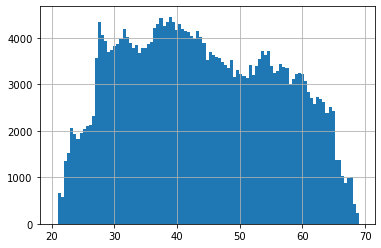

In [41]:
# display(appli_tr.DAYS_BIRTH.hist()) # negative values
appli_tr['DAYS_BIRTH'] = appli_tr.DAYS_BIRTH.abs() + 1
appli_tr['YEARS_BIRTH'] = appli_tr.DAYS_BIRTH / 365.25
display(appli_tr.YEARS_BIRTH.hist(bins=99)) # How many days before the application the person started current employment

In [42]:
display(appli_tr.groupby('TARGET')['YEARS_BIRTH'].mean())
display(appli_tr.groupby('TARGET')['YEARS_BIRTH'].median())

# the mode of age, the most frequent age
# appli_tr.groupby('TARGET')['YEARS_BIRTH'].transform(lambda x: x.value_counts().index[0] )
display(appli_tr.groupby('TARGET')['YEARS_BIRTH'].apply(lambda x: x.round().value_counts().index[0]))

# if use transform instead of apply, it wil return the series, not the mode of every group
# maybe apply acts on Series or on part of Series formed after groupby, while transform acts elementwise
# appli_tr.groupby('TARGET')['YEARS_BIRTH'].transform(lambda x: x.round().value_counts().index[0])

TARGET
0    44.186657
1    40.755176
Name: YEARS_BIRTH, dtype: float64

TARGET
0    43.471595
1    39.104723
Name: YEARS_BIRTH, dtype: float64

TARGET
0    39.0
1    28.0
Name: YEARS_BIRTH, dtype: float64

In [43]:
# appli_tr['CNT_ADULTS'] = appli_tr.CNT_FAM_MEMBERS - appli_tr.CNT_CHILDREN
# sns.displot(data=appli_tr, x='YEARS_BIRTH', hue='TARGET', col='CNT_ADULTS', kind='kde', common_norm=False)
# # the peak for old single adult should correspond to the widow family status

In [44]:
# sns.displot(data=appli_tr, x='YEARS_BIRTH', hue='TARGET', col='CODE_GENDER', kind='kde', common_norm=False)

In [45]:
# NOT AN INFORMATIVE GRAPH, DON'T UNCOMMENT IT - as every skewed distribution: high peaks at 0-2 than long tail.

# appli_tr['CNT_ADULTS'] = appli_tr.CNT_FAM_MEMBERS - appli_tr.CNT_CHILDREN
# appli_single = appli_tr[appli_tr.CNT_ADULTS == 1]
# appli_double = appli_tr[appli_tr.CNT_ADULTS == 2]

# display(sns.displot(data=appli_single, x='CNT_CHILDREN', hue='TARGET', col='CODE_GENDER', kind='kde', common_norm=False, bw_adjust=2))
# display(sns.displot(data=appli_double, x='CNT_CHILDREN', hue='TARGET', col='CODE_GENDER', kind='kde', common_norm=False, bw_adjust=2))

In [46]:
appli_tr['F_AGE'] = np.where(appli_tr.CODE_GENDER == 'F', appli_tr.DAYS_BIRTH, 0)
appli_tr['M_AGE'] = np.where(appli_tr.CODE_GENDER == 'M', appli_tr.DAYS_BIRTH, 0)

In [47]:
# sns.displot(data=appli_tr, x='F_AGE', hue='TARGET', kind='kde', common_norm=False)

In [48]:
# sns.displot(data=appli_tr, x='M_AGE', hue='TARGET', kind='kde', common_norm=False)

###  DAYS_EMPLOYED (with impact of DAYS_BIRTH and CODE_GENDER)

365243    55374
Name: DAYS_EMPLOYED, dtype: int64

<AxesSubplot:>

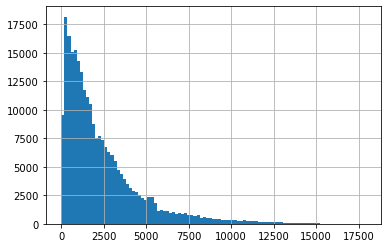

In [49]:
# display(appli_tr.DAYS_EMPLOYED.hist()) # a peak around 350,000
display(appli_tr.loc[appli_tr.DAYS_EMPLOYED > 50_000, 'DAYS_EMPLOYED'].value_counts(dropna=False)) #365243 is 1,000 years

appli_tr.loc[appli_tr.DAYS_EMPLOYED > 50_000, 'DAYS_EMPLOYED'] = np.nan # 50,000 days is 136.89 years
# appli_tr.replace(365243, np.nan, inplace=True) # works as well
appli_tr['DAYS_EMPLOYED'] = appli_tr.DAYS_EMPLOYED.abs() + 1

display(appli_tr.DAYS_EMPLOYED.hist(bins=99)) # How many days before the application the person started current employment

In [50]:
print(appli_tr.TARGET.mean() * 100)
print(appli_tr[appli_tr.DAYS_EMPLOYED.isna()].TARGET.mean() * 100)
print(appli_tr.DAYS_EMPLOYED.mean())
print(appli_tr.DAYS_EMPLOYED.median())
print(appli_tr.DAYS_EMPLOYED.value_counts().index[0])

display(appli_tr.groupby('TARGET')['DAYS_EMPLOYED'].apply(lambda x: x.round().value_counts().index[0]))

8.072881945686495
5.399646043269405
2385.1693246132063
1649.0
201.0


TARGET
0    225.0
1    235.0
Name: DAYS_EMPLOYED, dtype: float64

In [51]:
# fig, ax = plt.subplots(figsize=(10, 5))
# sns.kdeplot(ax=ax, data=appli_tr, x='DAYS_EMPLOYED', hue='TARGET', common_norm=False)

In [52]:
# # # appli_tr['TEST_EMPLOYED0'] = appli_tr.DAYS_EMPLOYED.fillna(1)
# # # appli_tr['TEST_EMPLOYED1'] = appli_tr.DAYS_EMPLOYED.fillna(appli_tr.DAYS_EMPLOYED.value_counts().index[0])
# # # appli_tr['TEST_EMPLOYED2'] = appli_tr.DAYS_EMPLOYED.fillna(appli_tr.DAYS_EMPLOYED.median())
# # # appli_tr['TEST_EMPLOYED3'] = appli_tr.DAYS_EMPLOYED.fillna(appli_tr.DAYS_EMPLOYED.mean())

# # # fig, ax = plt.subplots(figsize=(10, 5))
# # # display(sns.kdeplot(ax=ax, data=appli_tr, x='TEST_EMPLOYED0', hue='TARGET', common_norm=False))
# # # display(sns.kdeplot(ax=ax, data=appli_tr, x='TEST_EMPLOYED1', hue='TARGET', common_norm=False))
# # # display(sns.kdeplot(ax=ax, data=appli_tr, x='TEST_EMPLOYED2', hue='TARGET', common_norm=False))
# # # display(sns.kdeplot(ax=ax, data=appli_tr, x='TEST_EMPLOYED3', hue='TARGET', common_norm=False))

appli_tr['DAYS_EMPLOYED'] = appli_tr.DAYS_EMPLOYED.fillna(appli_tr.DAYS_EMPLOYED.mean())
appli_tr['YEARS_EMPLOYED'] = appli_tr.DAYS_EMPLOYED / 365.25

In [53]:
appli_ok = appli_tr[appli_tr.TARGET== 0]
appli_fail = appli_tr[appli_tr.TARGET== 1]

In [54]:
# sns.displot(
# {   'target 0': appli_ok.YEARS_EMPLOYED / appli_ok.YEARS_BIRTH,
#     'target 1': appli_fail.YEARS_EMPLOYED / appli_fail.YEARS_BIRTH 
# }, kind='kde', common_norm=False)
# plt.xlabel('Age, years')

In [55]:
# # the difference between target 0 and target 1 seems to be less pronounced 
# sns.displot(
# {   'target 0': appli_ok.YEARS_EMPLOYED / (appli_ok.YEARS_BIRTH - 16),
#     'target 1': appli_fail.YEARS_EMPLOYED / (appli_fail.YEARS_BIRTH - 16) 
# }, kind='kde', common_norm=False)
# plt.xlabel('Age, years')

# # makes no sense to create synthetic variable DAYS_EMPLOYED / (DAYS_BIRTH - 5844) where 5844 days is 16 years

I tested the synthetic features DAYS_EMPLOYED_PERC = DAYS_EMPLOYED / DAYS_BIRTH and DAYS_EMPLOYED_ADULT = DAYS_EMPLOYED / (DAYS_BIRTH - 5844) where 5844 days is 16 years. I tested the model with all these variables included.

Later at the Shap verification of feature importances, I saw that the variables DAYS_EMPLOYED, DAYS_EMPLOYED_PERC and DAYS_EMPLOYED_ADULT are highly correlated (which is quite expected). That's why I can keep only one of these variables, and thus reduce the bad effect of the correlation.
I will keep the proportion DAYS_EMPLOYED / DAYS_BIRTH, because it shows good distinction between the target curves, and doesn't have such a long trailing tail as original DAYS_EMPLOYED variable.


In [56]:
appli_tr['DAYS_EMPLOYED_PERC'] = appli_tr['DAYS_EMPLOYED'] / appli_tr['DAYS_BIRTH']

###  DAYS_ID_PUBLISH (with impact of DAYS_BIRTH and CODE_GENDER)

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

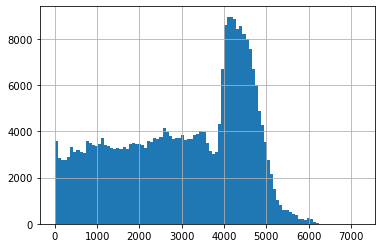

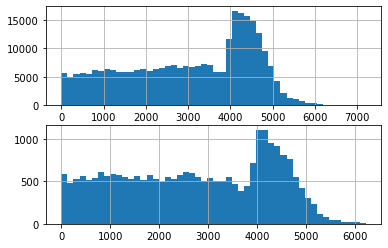

In [57]:
# display(appli_tr.DAYS_ID_PUBLISH.hist()) # negative values
appli_tr['DAYS_ID_PUBLISH'] = appli_tr.DAYS_ID_PUBLISH.abs() + 1
display(appli_tr.DAYS_ID_PUBLISH.hist(bins=99)) # How many days before the application the person started current employment

fig, (ax1, ax2) = plt.subplots(2)
display(appli_tr[appli_tr.TARGET== 0].DAYS_ID_PUBLISH.hist(ax=ax1, bins=50))
display(appli_tr[appli_tr.TARGET== 1].DAYS_ID_PUBLISH.hist(ax=ax2, bins=50)) # still minor difference
# nevertheless it's clear that the proportion of fresh IDs is a bit higher for target 1

In [58]:
display(appli_tr.groupby('TARGET')['DAYS_ID_PUBLISH'].apply(lambda x: x.round().value_counts().index[0]))
display(appli_tr.groupby('TARGET')['DAYS_ID_PUBLISH'].apply(lambda x: x.median()))
display(appli_tr.groupby('TARGET')['DAYS_ID_PUBLISH'].apply(lambda x: x.mean()))

TARGET
0    4054
1    4034
Name: DAYS_ID_PUBLISH, dtype: int64

TARGET
0    3296.0
1    2798.0
Name: DAYS_ID_PUBLISH, dtype: float64

TARGET
0    3018.219788
1    2733.099617
Name: DAYS_ID_PUBLISH, dtype: float64

In [59]:
# fig, ax = plt.subplots(figsize=(10, 5))
# sns.kdeplot(ax=ax, data=appli_tr, x='DAYS_ID_PUBLISH', hue='TARGET', common_norm=False)

In [60]:
# sns.scatterplot(data=appli_tr, x='DAYS_BIRTH', y='DAYS_ID_PUBLISH', hue='TARGET')
# the ID PUBLISH depends on age. it is released at certain age

In [61]:
# sns.displot(data=appli_tr, x='DAYS_ID_PUBLISH', col='CODE_GENDER', hue='TARGET', kind='kde', common_norm=False)

###  DAYS_REGISTRATION (with impact of DAYS_BIRTH and CODE_GENDER)

<AxesSubplot:>

<AxesSubplot:>

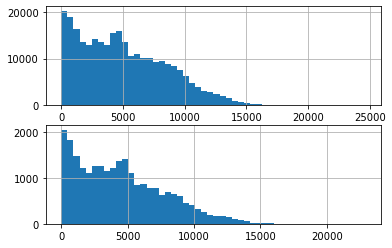

In [62]:
# display(appli_tr.DAYS_REGISTRATION.hist()) # negative values
appli_tr['DAYS_REGISTRATION'] = appli_tr.DAYS_REGISTRATION.abs() + 1
# display(appli_tr.DAYS_REGISTRATION.hist(bins=99)) # How many days before the application the person started current employment

fig, (ax1, ax2) = plt.subplots(2)
display(appli_tr[appli_tr.TARGET== 0].DAYS_REGISTRATION.hist(ax=ax1, bins=50))
display(appli_tr[appli_tr.TARGET== 1].DAYS_REGISTRATION.hist(ax=ax2, bins=50)) # still minor difference


In [63]:
display(appli_tr.groupby('TARGET')['DAYS_REGISTRATION'].apply(lambda x: x.round().value_counts().index[0]))
display(appli_tr.groupby('TARGET')['DAYS_REGISTRATION'].apply(lambda x: x.median()))
display(appli_tr.groupby('TARGET')['DAYS_REGISTRATION'].apply(lambda x: x.mean()))

TARGET
0    2.0
1    2.0
Name: DAYS_REGISTRATION, dtype: float64

TARGET
0    4545.0
1    4057.0
Name: DAYS_REGISTRATION, dtype: float64

TARGET
0    5030.941065
1    4488.127009
Name: DAYS_REGISTRATION, dtype: float64

In [64]:
# fig, ax = plt.subplots(figsize=(10, 5))
# sns.kdeplot(ax=ax, data=appli_tr, x='DAYS_REGISTRATION', hue='TARGET', common_norm=False)

In [65]:
# sns.displot(data=appli_tr, x='DAYS_REGISTRATION', col='CODE_GENDER', hue='TARGET', kind='kde', common_norm=False)

### HOUR_APPR_PROCESS_START

In [66]:
# find_most_risky('HOUR_APPR_PROCESS_START', selectcol)

- HOUR_APPR_PROCESS_START: there is a correlation, but not linear. People who apply at night or early morning (10PM-7AM) fail their credits more often.
But to transfer this 'circular' dependence into a linear one, we should 'shift the clock'. So that the night starts at 22 hours, not at 0 hours.

In [67]:
appli_tr.loc[appli_tr.HOUR_APPR_PROCESS_START > 21, 'HOUR_APPR_PROCESS_START'] = appli_tr.HOUR_APPR_PROCESS_START - 24
appli_tr['HOUR_APPR_PROCESS_START'] = appli_tr.HOUR_APPR_PROCESS_START + 2

In [68]:
# sns.displot(data=appli_tr, x='HOUR_APPR_PROCESS_START', hue='TARGET', kind='kde', common_norm=False, bw_adjust=1.7)
# # The graph still looks like the difference on the graphs is tiny. Maybe I will remove this feture at the final cleaning step.

<AxesSubplot:>

<AxesSubplot:>

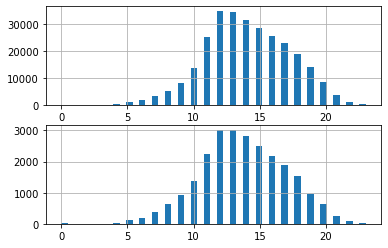

In [69]:
fig, (ax1, ax2) = plt.subplots(2)
display(appli_tr[appli_tr.TARGET== 0].HOUR_APPR_PROCESS_START.hist(ax=ax1, bins=47))
display(appli_tr[appli_tr.TARGET== 1].HOUR_APPR_PROCESS_START.hist(ax=ax2, bins=47)) # still minor difference

## Float variables: analysis, feature selection, imputing values

In [70]:
# appli_tr.describe() # 106 columns, hard to follow
test = appli_tr.describe(include=float).transpose()
# test['missing'] = (test['count'] / appli_tr.shape[0] * 100).transform(round) # transform(round(3)) raises an error
test['missing'] = ((1-test['count'] / appli_tr.shape[0]) * 100).transform(lambda x: x.round(3))
test['count'] = appli_tr.shape[0] - test['count']

display(test[:11])
print(test.shape[0])

,count,mean,std,min,25%,50%,75%,max,missing
AMT_INCOME_TOTAL,0.0,168797.919297,237123.146279,2.565000e+04,112500.000000,147150.000000,202500.000000,1.170000e+08,0.000
AMT_CREDIT,0.0,599025.999706,402490.776996,4.500000e+04,270000.000000,513531.000000,808650.000000,4.050000e+06,0.000
AMT_ANNUITY,12.0,27108.573909,14493.737315,1.615500e+03,16524.000000,24903.000000,34596.000000,2.580255e+05,0.004
AMT_GOODS_PRICE,278.0,538396.207429,369446.460540,4.050000e+04,238500.000000,450000.000000,679500.000000,4.050000e+06,0.090
REGION_POPULATION_RELATIVE,0.0,0.020868,0.013831,2.900000e-04,0.010006,0.018850,0.028663,7.250800e-02,0.000
DAYS_EMPLOYED,0.0,2385.169325,2117.381973,1.000000e+00,934.000000,2220.000000,2761.000000,1.791300e+04,0.000
DAYS_REGISTRATION,0.0,4987.120328,3522.886321,1.000000e+00,2011.000000,4505.000000,7480.500000,2.467300e+04,0.000
OWN_CAR_AGE,202929.0,12.061091,11.944812,0.000000e+00,5.000000,9.000000,15.000000,9.100000e+01,65.991
EXT_SOURCE_1,173378.0,0.502130,0.211062,1.456813e-02,0.334007,0.505998,0.675053,9.626928e-01,56.381
EXT_SOURCE_2,660.0,0.514393,0.191060,8.173617e-08,0.392457,0.565961,0.663617,8.549997e-01,0.215


68


OWN_CAR_AGE, EXT_SOURCE_1, have more than half values NaNs. EXT_SOURCE_3 has 20% NaNs.

<AxesSubplot:>

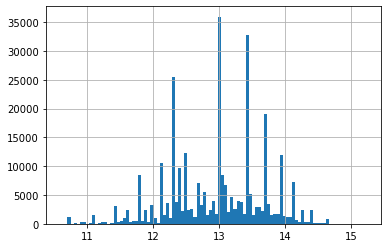

In [71]:
# appli_tr.AMT_INCOME_TOTAL.hist(bins=99) # exponential distribution
# appli_tr.AMT_ANNUITY.hist(bins=99) # exponential distribution
# appli_tr.AMT_CREDIT.hist(bins=99) # biased distribution 
# np.log(appli_tr.AMT_CREDIT).hist(bins=99) # not a normal distribution, but less skewed, almost symmetric 
# appli_tr.AMT_GOODS_PRICE.hist(bins=20) # biased distribution
np.log(appli_tr.AMT_GOODS_PRICE).hist(bins=99) # not a normal distribution, but less skewed, almost symmetric 
# appli_tr.REGION_POPULATION_RELATIVE.hist(bins=20) # biased distribution
# appli_tr.OWN_CAR_AGE.hist(bins=20) # strongly skewed, biased distribution.


__HOW TO USE THE GRAPHIC CELLS: IF YOU WANT TO SEE CERTAIN GRAPHIC? UNCOMMENT THE WHOLE CELL.__

In [72]:
# sns.displot({'target 0': appli_ok.AMT_CREDIT / appli_ok.AMT_INCOME_TOTAL,
#     'target 1': appli_fail.AMT_CREDIT / appli_fail.AMT_INCOME_TOTAL},
#     kind='kde', common_norm=False) 

# # graphs go aligned, very skewed graph. Logarithmization is needed

In [73]:
appli_tr['AMT_INCOME_TOTAL'] = np.log(appli_tr.AMT_INCOME_TOTAL)
appli_tr['AMT_CREDIT'] = np.log(appli_tr.AMT_CREDIT)

appli_tr['AMT_ANNUITY'] = np.log(appli_tr.AMT_ANNUITY)
appli_tr['AMT_GOODS_PRICE'] = np.log(appli_tr.AMT_GOODS_PRICE)


In [74]:
# fig, ax = plt.subplots(figsize=(10, 5))

# # # sns.kdeplot(ax=ax, data=appli_tr, x='AMT_INCOME_TOTAL', hue='TARGET', common_norm=False)
# # # # no difference, just the sharpness

# sns.kdeplot(ax=ax, data=appli_tr, x='AMT_CREDIT', hue='TARGET', common_norm=False)
# # slightly different curves. more fails between 12.5 and 13.5

# # sns.kdeplot(ax=ax, data=appli_tr, x='AMT_ANNUITY', hue='TARGET', common_norm=False)
# # # slightly different curves. more fails between 10 and 10.5

# sns.kdeplot(ax=ax, data=appli_tr, x='AMT_GOODS_PRICE', hue='TARGET', common_norm=False)
# # certainly different curves. more fails around 13


<AxesSubplot:>

<AxesSubplot:>

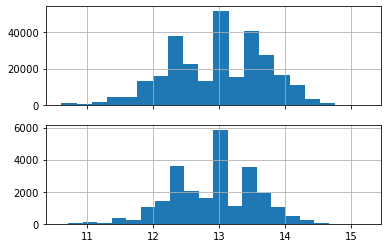

In [75]:
# fig, (ax1, ax2) = plt.subplots(2, sharex=True)
# display(appli_tr[appli_tr.TARGET== 0].AMT_INCOME_TOTAL.hist(ax=ax1, bins=50))
# display(appli_tr[appli_tr.TARGET== 1].AMT_INCOME_TOTAL.hist(ax=ax2, bins=50)) # no difference 

# fig, (ax1, ax2) = plt.subplots(2, sharex=True)
# display(appli_tr[appli_tr.TARGET== 0].AMT_CREDIT.hist(ax=ax1, bins=20))
# display(appli_tr[appli_tr.TARGET== 1].AMT_CREDIT.hist(ax=ax2, bins=20)) # little difference 

# fig, (ax1, ax2) = plt.subplots(2, sharex=True)
# display(appli_tr[appli_tr.TARGET== 0].AMT_ANNUITY.hist(ax=ax1, bins=99))
# display(appli_tr[appli_tr.TARGET== 1].AMT_ANNUITY.hist(ax=ax2, bins=99)) # little difference 

fig, (ax1, ax2) = plt.subplots(2, sharex=True)
display(appli_tr[appli_tr.TARGET== 0].AMT_GOODS_PRICE.hist(ax=ax1, bins=20))
display(appli_tr[appli_tr.TARGET== 1].AMT_GOODS_PRICE.hist(ax=ax2, bins=20)) # little difference 

Below is the list of external source kernel variables, feature engineering.

Only the last feature from the offered external source kernel looks promising - I see some differences on histograms.

In [76]:
appli_tr['AMT_ANNUITY'] = appli_tr.AMT_ANNUITY.fillna(appli_tr.AMT_ANNUITY.median())
appli_tr['AMT_GOODS_PRICE'] = appli_tr.AMT_GOODS_PRICE.fillna(appli_tr.AMT_GOODS_PRICE.median())

print(appli_tr[appli_tr.DAYS_REGISTRATION != appli_tr.DAYS_REGISTRATION.astype(int)]['DAYS_REGISTRATION'])
appli_tr['DAYS_REGISTRATION'] = appli_tr.DAYS_REGISTRATION.astype('int64')

266366    10117.041667
Name: DAYS_REGISTRATION, dtype: float64


In [77]:
appli_tr['INCOME_CREDIT_PERC'] = appli_tr['AMT_INCOME_TOTAL'] / appli_tr['AMT_CREDIT'] # doesn't seem a good feature according kde plots.
appli_tr['CREDIT_INCOME_PERC'] = appli_tr['AMT_CREDIT'] / appli_tr['AMT_INCOME_TOTAL'] # doesn't seem a good feature according kde plots.

appli_tr['INCOME_ANNUITY_PERC'] = appli_tr['AMT_INCOME_TOTAL'] / appli_tr['AMT_ANNUITY'] # the difference is only because of the difference in the annuities
appli_tr['ANNUITY_INCOME_PERC'] = appli_tr['AMT_ANNUITY'] / appli_tr['AMT_INCOME_TOTAL'] # the difference is only because of the difference in the annuities

appli_tr['PAYMENT_RATE'] = appli_tr['AMT_ANNUITY'] / appli_tr['AMT_CREDIT'] # rather good feature, but the inverse is better, AMT_CREDIT / AMT_ANNUITY
appli_tr['CREDIT_TERM'] = appli_tr['AMT_CREDIT'] / appli_tr['AMT_ANNUITY'] # rather good feature, but the inverse is better, AMT_CREDIT / AMT_ANNUITY

appli_tr['INCOME_PER_PERSON'] = appli_tr['AMT_INCOME_TOTAL'] / appli_tr['CNT_FAM_MEMBERS'] # not a good feature according kde plots.

appli_tr['CNT_ADULTS'] = appli_tr.CNT_FAM_MEMBERS - appli_tr.CNT_CHILDREN

In [78]:
# fig, ax = plt.subplots(figsize=(10, 5))

# # # sns.kdeplot(ax=ax, data=appli_tr, x='INCOME_CREDIT_PERC', hue='TARGET', common_norm=False)
# # graphics go aligned except the region 0.8-0.9.

# # # sns.kdeplot(ax=ax, data=appli_tr, x='CREDIT_INCOME_PERC', hue='TARGET', common_norm=False)
# # graphics go aligned except the region 1.0-1.2

# sns.kdeplot(ax=ax, data=appli_tr, x='INCOME_ANNUITY_PERC', hue='TARGET', common_norm=False)
# # # graphics go aligned except the region 0.8-0.9. overall, there is no difference

# sns.kdeplot(ax=ax, data=appli_tr, x='ANNUITY_INCOME_PERC', hue='TARGET', common_norm=False)
# # graphics go aligned except the region 0.8-0.9. overall, the difference is tiny

# # sns.kdeplot(ax=ax, data=appli_tr, x='PAYMENT_RATE', hue='TARGET', common_norm=False)
# # # slightly different curves. more fails between 10 and 10.5

# sns.kdeplot(ax=ax, data=appli_tr, x='CREDIT_TERM', hue='TARGET', common_norm=False)
# # certainly different curves. more fails around 13


- INCOME_CREDIT_PERC not a good variable: target 0 and target 1 curves are almost identical
- INCOME_PER_PERSON not a good variable for the same reason
- ANNUITY_INCOME_PERC: graphics are different only because the difference in ANNUITY, not INCOME (INCOME is the same for 0 and 1)

In [79]:
# fig, ax = plt.subplots(figsize=(10, 5))
# sns.kdeplot(ax=ax, data=appli_tr, x='OWN_CAR_AGE', hue='TARGET', common_norm=False)
# # in general the age of the target1 curve is higher than that of target 0 curve

In [80]:
# fig, ax = plt.subplots(figsize=(10, 5))
# sns.kdeplot(ax=ax, data=appli_tr, x='REGION_POPULATION_RELATIVE', hue='TARGET', common_norm=False)
# # higher values increase the chance of target=0, for lower values no difference.

### Variables 'external source', how to impute

In [81]:
# fig, ax = plt.subplots(figsize=(10, 5))
# sns.kdeplot(ax=ax, data=appli_tr, x='EXT_SOURCE_1', hue='TARGET', common_norm=False)

In [82]:
# display(appli_tr.groupby('TARGET')['EXT_SOURCE_1'].apply(lambda x: x.round().value_counts().index[0]))
# display(appli_tr.groupby('TARGET')['EXT_SOURCE_1'].apply(lambda x: x.median()))
# display(appli_tr.groupby('TARGET')['EXT_SOURCE_1'].apply(lambda x: x.mean()))
# # Gives the information only about existing values. I need to seewhat's the target when EXT_SOURCE_1 is NaN

# How many applications fail overall
print(appli_tr.TARGET.mean() * 100)
print()
# Given that the EXT_SOURCE is filled or NaN what is the chance to find a failer
print(appli_tr[appli_tr.EXT_SOURCE_1.notna()].TARGET.mean() * 100)
print(appli_tr[appli_tr.EXT_SOURCE_1.isna()].TARGET.mean() * 100)
print()
print(appli_tr[appli_tr.EXT_SOURCE_2.notna()].TARGET.mean() * 100)
print(appli_tr[appli_tr.EXT_SOURCE_2.isna()].TARGET.mean() * 100)
print()
print(appli_tr[appli_tr.EXT_SOURCE_3.notna()].TARGET.mean() * 100)
print(appli_tr[appli_tr.EXT_SOURCE_3.isna()].TARGET.mean() * 100)

8.072881945686495

7.495545466067262
8.519535350505832

8.073299418936227
7.878787878787878

7.766501991514768
9.311900270647094


There is some difference in failure rating between the clients with known values and NaNs, but not large one.
Lack of source1 increase the fail risk 1.13 times, lack of source 2 decreases the fail risk 0.97 times (or in other words doesn't change anything), lack of source 3 increases the risk 1.19 times.

Ext_source_1 has a bit more fails for NaN values than for exisiting values. Then ve can fill it with a value the is close to the crossing of the curves (0.4) or slightly below.  
What is the proportion of NaN for the failers and for the ok clients?

In [83]:
# WARNING: modes for EXT_SOURCE_1 have many values
# 10 mode values for all the table, 6 for the table with present values, 140 for the missing values
# the values are sorted in ascending order.
# So try to take the value from the middle index of the mode

print(appli_tr.EXT_SOURCE_1.mode()[len(appli_tr.EXT_SOURCE_1.mode()) // 2])
print(appli_tr.EXT_SOURCE_1.median() * 100)
print(appli_tr.EXT_SOURCE_1.mean() * 100)
print()
print(appli_ok.EXT_SOURCE_1.mode()[len(appli_ok.EXT_SOURCE_1.mode()) // 2])
print(appli_ok.EXT_SOURCE_1.median() * 100)
print(appli_ok.EXT_SOURCE_1.mean() * 100)
print()
print(appli_fail.EXT_SOURCE_1.mode()[len(appli_fail.EXT_SOURCE_1.mode()) // 2])
print(appli_fail.EXT_SOURCE_1.median() * 100)
print(appli_fail.EXT_SOURCE_1.mean() * 100)

0.5810147955776347
50.599793050575435
50.2129805656662

0.605151661169131
51.74515531911259
51.14612439213994

0.3847682198080493
36.16754277946473
38.69681258823661


For the missing values in the source 1 a compromise solution is to fill the missing values by mean, which is the closest to the median and the mean of failers. Same thing for source 2 and source 3 (see graphs below).

In [84]:
# appli_tr['EXT_SOURCE_1'] = appli_tr.EXT_SOURCE_1.fillna(appli_tr.EXT_SOURCE_1.mean())
appli_tr['EXT_SOURCE_1'] = appli_tr.EXT_SOURCE_1.fillna(0.4)

In [85]:
# fig, ax = plt.subplots(figsize=(10, 5))
# sns.kdeplot(ax=ax, data=appli_tr, x='EXT_SOURCE_1', hue='TARGET', common_norm=False)

In [86]:
# fig, ax = plt.subplots(figsize=(10, 5))
# ax.set_xticks(np.arange(0, 1, step=0.05))
# sns.kdeplot(ax=ax, data=appli_tr, x='EXT_SOURCE_2', hue='TARGET', common_norm=False)

Ext_source_2 has a bit less fails for NaN values than for exisiting values. Then ve can fill it with a value the is close to the crossing of the curves (0.5) or slightly above.  

In [87]:
# NOTE: here all the modes have length of 1, unlike for Ext_source_1

print(appli_tr.EXT_SOURCE_2.mode())
print(appli_tr.EXT_SOURCE_2.median() * 100)
print(appli_tr.EXT_SOURCE_2.mean() * 100)
print()
print(appli_ok.EXT_SOURCE_2.mode())
print(appli_ok.EXT_SOURCE_2.median() * 100)
print(appli_ok.EXT_SOURCE_2.mean() * 100)
print()
print(appli_fail.EXT_SOURCE_2.mode())
print(appli_fail.EXT_SOURCE_2.median() * 100)
print(appli_fail.EXT_SOURCE_2.mean() * 100)

0    0.285898
dtype: float64
56.596142606085266
51.439267413084636

0    0.285898
dtype: float64
57.39046869026359
52.34786690184261

0    0.285898
dtype: float64
44.038063037638366
41.09349069691106


In [88]:
appli_tr['EXT_SOURCE_2'] = appli_tr.EXT_SOURCE_2.fillna(0.52)

In [89]:
# fig, ax = plt.subplots(figsize=(10, 5))
# ax.set_xticks(np.arange(0, 1, step=0.05))
# sns.kdeplot(ax=ax, data=appli_tr, x='EXT_SOURCE_2', hue='TARGET', common_norm=False)

In [90]:
# fig, ax = plt.subplots(figsize=(10, 5))
# ax.set_xticks(np.arange(0, 1, step=0.05))
# sns.kdeplot(ax=ax, data=appli_tr, x='EXT_SOURCE_3', hue='TARGET', common_norm=False)

Ext_source_2 has a bit less fails for NaN values than for exisiting values. Then ve can fill it with a value the is close to the crossing of the curves (0.45) or slightly above.

In [91]:
# NOTE: here all the modes have length of 1, unlike for Ext_source_1


print(appli_tr.EXT_SOURCE_3.mode())
print(appli_tr.EXT_SOURCE_3.median() * 100)
print(appli_tr.EXT_SOURCE_3.mean() * 100)
print()
print(appli_ok.EXT_SOURCE_3.mode())
print(appli_ok.EXT_SOURCE_3.median() * 100)
print(appli_ok.EXT_SOURCE_3.mean() * 100)
print()
print(appli_fail.EXT_SOURCE_3.mode())
print(appli_fail.EXT_SOURCE_3.median() * 100)
print(appli_fail.EXT_SOURCE_3.mean() * 100)

0    0.7463
dtype: float64
53.527625047248264
51.08529061800121

0    0.7463
dtype: float64
54.602319700496096
52.096895893760035

0    0.000527
dtype: float64
37.91004853998145
39.071659090048286


In [92]:
appli_tr['EXT_SOURCE_3'] = appli_tr.EXT_SOURCE_3.fillna(0.4)

In [93]:
# fig, ax = plt.subplots(figsize=(10, 5))
# ax.set_xticks(np.arange(0, 1, step=0.05))
# sns.kdeplot(ax=ax, data=appli_tr, x='EXT_SOURCE_3', hue='TARGET', common_norm=False)

In [94]:
display(test.loc['TOTALAREA_MODE':])

,count,mean,std,min,25%,50%,75%,max,missing
TOTALAREA_MODE,148431.0,0.102547,0.107462,0.000000,0.041200,0.068800,0.127600,1.000000,48.269
OBS_30_CNT_SOCIAL_CIRCLE,1021.0,1.422245,2.400989,0.000000,0.000000,0.000000,2.000000,348.000000,0.332
DEF_30_CNT_SOCIAL_CIRCLE,1021.0,0.143421,0.446698,0.000000,0.000000,0.000000,0.000000,34.000000,0.332
OBS_60_CNT_SOCIAL_CIRCLE,1021.0,1.405292,2.379803,0.000000,0.000000,0.000000,2.000000,344.000000,0.332
DEF_60_CNT_SOCIAL_CIRCLE,1021.0,0.100049,0.362291,0.000000,0.000000,0.000000,0.000000,24.000000,0.332
DAYS_LAST_PHONE_CHANGE,1.0,-962.858788,826.808487,-4292.000000,-1570.000000,-757.000000,-274.000000,0.000000,0.000
AMT_REQ_CREDIT_BUREAU_HOUR,41519.0,0.006402,0.083849,0.000000,0.000000,0.000000,0.000000,4.000000,13.502
AMT_REQ_CREDIT_BUREAU_DAY,41519.0,0.007000,0.110757,0.000000,0.000000,0.000000,0.000000,9.000000,13.502
AMT_REQ_CREDIT_BUREAU_WEEK,41519.0,0.034362,0.204685,0.000000,0.000000,0.000000,0.000000,8.000000,13.502
AMT_REQ_CREDIT_BUREAU_MON,41519.0,0.267395,0.916002,0.000000,0.000000,0.000000,0.000000,27.000000,13.502


<AxesSubplot:>

<AxesSubplot:>

0.0
1.0


<AxesSubplot:>

<AxesSubplot:>

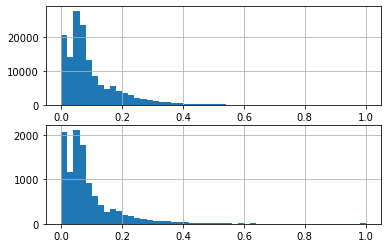

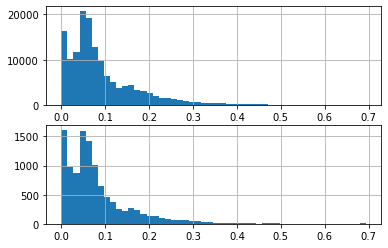

In [95]:
fig, (ax1, ax2) = plt.subplots(2)
display(appli_ok.TOTALAREA_MODE.hist(ax=ax1, bins=50))
display(appli_fail.TOTALAREA_MODE.hist(ax=ax2, bins=50)) # still minor difference

print(appli_tr.TOTALAREA_MODE.min())
print(appli_tr.TOTALAREA_MODE.max())

# fig, ax = plt.subplots(figsize=(10, 5))
# ax.set_xticks(np.arange(0, 1, step=0.05))
# sns.kdeplot(ax=ax, data=appli_tr, x='TOTALAREA_MODE', hue='TARGET', common_norm=False)  # minor difference

appli_tr['TOTALAREA_MODE'] = np.log(appli_tr.TOTALAREA_MODE + 1)
# sns.kdeplot(ax=ax, data=appli_tr, x='TOTALAREA_MODE', hue='TARGET', common_norm=False)  # still minor difference

fig, (ax1, ax2) = plt.subplots(2)
display(appli_tr[appli_tr.TARGET== 0].TOTALAREA_MODE.hist(ax=ax1, bins=50))
display(appli_tr[appli_tr.TARGET== 1].TOTALAREA_MODE.hist(ax=ax2, bins=50)) # still minor difference

0.0
8.088028973212829
3.525954946131244


<AxesSubplot:>

<AxesSubplot:>

0.0 0.0 141.75232755901413
0.0 0.0 141.5742223137298
0.0 0.0 149.61474847714712


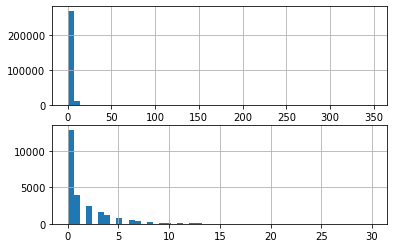

In [96]:
# fig, ax = plt.subplots(figsize=(10, 5)) # USELESS GRAPH, DON'T UNCOMMENT IT. Looks like an angle
# sns.kdeplot(ax=ax, data=appli_tr, x='OBS_30_CNT_SOCIAL_CIRCLE', hue='TARGET', common_norm=False)  # minor difference

print(appli_tr.OBS_30_CNT_SOCIAL_CIRCLE.min())
print(appli_tr[appli_tr.OBS_30_CNT_SOCIAL_CIRCLE.notna()].TARGET.mean() * 100)
print(appli_tr[appli_tr.OBS_30_CNT_SOCIAL_CIRCLE.isna()].TARGET.mean() * 100)


fig, (ax1, ax2) = plt.subplots(2)
display(appli_ok.OBS_30_CNT_SOCIAL_CIRCLE.hist(ax=ax1, bins=50))
display(appli_fail.OBS_30_CNT_SOCIAL_CIRCLE.hist(ax=ax2, bins=50))

appli_tr['OBS_30_CNT_SOCIAL_CIRCLE'] = appli_tr.OBS_30_CNT_SOCIAL_CIRCLE.fillna(0)

print(appli_tr.OBS_30_CNT_SOCIAL_CIRCLE.mode()[0], appli_tr.OBS_30_CNT_SOCIAL_CIRCLE.median() * 100, appli_tr.OBS_30_CNT_SOCIAL_CIRCLE.mean() * 100)
print(appli_ok.OBS_30_CNT_SOCIAL_CIRCLE.mode()[0], appli_ok.OBS_30_CNT_SOCIAL_CIRCLE.median() * 100, appli_ok.OBS_30_CNT_SOCIAL_CIRCLE.mean() * 100)
print(appli_fail.OBS_30_CNT_SOCIAL_CIRCLE.mode()[0], appli_fail.OBS_30_CNT_SOCIAL_CIRCLE.median() * 100, appli_fail.OBS_30_CNT_SOCIAL_CIRCLE.mean() * 100)



# the graphics and the metrics distribution for 
# OBS_60_CNT_SOCIAL_CIRCLE,
# DEF_30_CNT_SOCIAL_CIRCLE,
# DEF_60_CNT_SOCIAL_CIRCLE,
# are the same. so, in order to save the space, I fill the NaNs straightforwardly without copying the code and presenting all the graphics
appli_tr['OBS_60_CNT_SOCIAL_CIRCLE'] = appli_tr.OBS_60_CNT_SOCIAL_CIRCLE.fillna(0)
appli_tr['DEF_30_CNT_SOCIAL_CIRCLE'] = appli_tr.DEF_30_CNT_SOCIAL_CIRCLE.fillna(0)
appli_tr['DEF_60_CNT_SOCIAL_CIRCLE'] = appli_tr.DEF_60_CNT_SOCIAL_CIRCLE.fillna(0)


In [97]:
print(appli_tr[appli_tr.OBS_30_CNT_SOCIAL_CIRCLE != appli_tr.OBS_60_CNT_SOCIAL_CIRCLE].shape) # 6000 out of 307,500. 2%
print(appli_tr[appli_tr.DEF_30_CNT_SOCIAL_CIRCLE != appli_tr.DEF_60_CNT_SOCIAL_CIRCLE].shape) # 13000 out of 307,500. 4%

# appli_tr = appli_tr.drop(['OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE'])
# well maybe no. maybe exactly this information is essential.

(5042, 109)
(11897, 109)


<AxesSubplot:>

<AxesSubplot:>

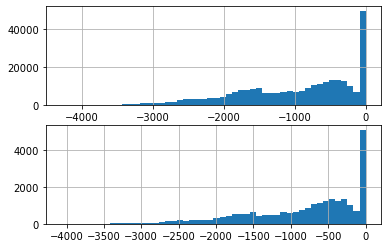

In [98]:
# # display(appli_tr.DAYS_LAST_PHONE_CHANGE.hist(bins=50)) # negative values, weird distribution. looks like it was filled NaN values with 0
# # for being able to apply the log scale:
# appli_tr['DAYS_LAST_PHONE_CHANGE'] = appli_tr.DAYS_LAST_PHONE_CHANGE.abs().fillna(0) + 1

# appli_ok = appli_tr[appli_tr.TARGET== 0]
# appli_fail = appli_tr[appli_tr.TARGET== 1]

# fig, (ax1, ax2) = plt.subplots(2)
# display(appli_ok.DAYS_LAST_PHONE_CHANGE.hist(ax=ax1, bins=50))
# display(appli_fail.DAYS_LAST_PHONE_CHANGE.hist(ax=ax2, bins=50))

# # no difference in the distribution!
# appli_tr['DAYS_LAST_PHONE_CHANGE'] = np.log(appli_tr.DAYS_LAST_PHONE_CHANGE)

fig, (ax1, ax2) = plt.subplots(2)
display(appli_tr[appli_tr.TARGET== 0].DAYS_LAST_PHONE_CHANGE.hist(ax=ax1, bins=50))
display(appli_tr[appli_tr.TARGET== 1].DAYS_LAST_PHONE_CHANGE.hist(ax=ax2, bins=50))

# the only difference is about 7.5 DROP?

<AxesSubplot:>

<AxesSubplot:>

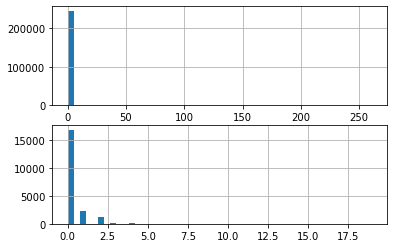

In [99]:
fig, (ax1, ax2) = plt.subplots(2)
display(appli_tr[appli_tr.TARGET== 0].AMT_REQ_CREDIT_BUREAU_QRT.hist(ax=ax1, bins=50))
display(appli_tr[appli_tr.TARGET== 1].AMT_REQ_CREDIT_BUREAU_QRT.hist(ax=ax2, bins=50))


<AxesSubplot:>

<AxesSubplot:>

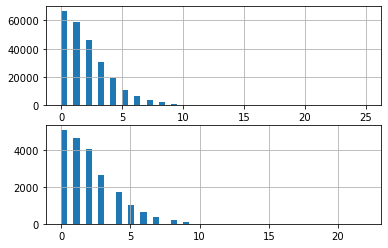

In [100]:
fig, (ax1, ax2) = plt.subplots(2)
display(appli_tr[appli_tr.TARGET== 0].AMT_REQ_CREDIT_BUREAU_YEAR.hist(ax=ax1, bins=50))
display(appli_tr[appli_tr.TARGET== 1].AMT_REQ_CREDIT_BUREAU_YEAR.hist(ax=ax2, bins=50))

# HOW ANYONE CAN HAVE LESS VISITS IN A YEAR THAN IN A QUARTER?

<AxesSubplot:>

<AxesSubplot:>

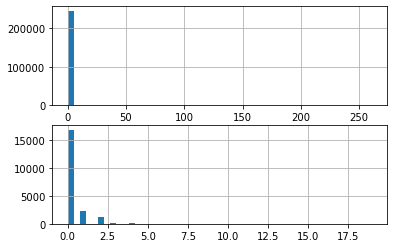

In [101]:
fig, (ax1, ax2) = plt.subplots(2)
display(appli_tr[appli_tr.TARGET== 0].AMT_REQ_CREDIT_BUREAU_QRT.hist(ax=ax1, bins=50))
display(appli_tr[appli_tr.TARGET== 1].AMT_REQ_CREDIT_BUREAU_QRT.hist(ax=ax2, bins=50))


<AxesSubplot:>

<AxesSubplot:>

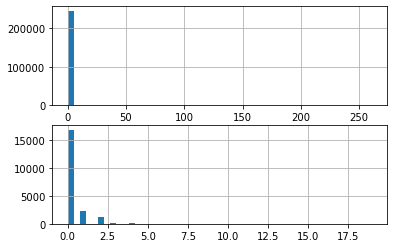

In [102]:
fig, (ax1, ax2) = plt.subplots(2)
display(appli_tr[appli_tr.TARGET== 0].AMT_REQ_CREDIT_BUREAU_QRT.hist(ax=ax1, bins=50))
display(appli_tr[appli_tr.TARGET== 1].AMT_REQ_CREDIT_BUREAU_QRT.hist(ax=ax2, bins=50))


<AxesSubplot:>

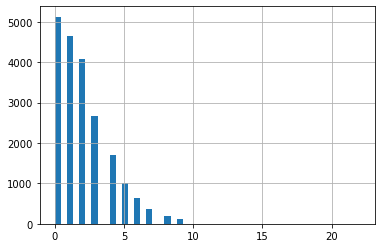

In [103]:
# display(appli_tr[appli_tr.TARGET == 0].AMT_REQ_CREDIT_BUREAU_YEAR.hist(bins=50))
display(appli_tr[appli_tr.TARGET == 1].AMT_REQ_CREDIT_BUREAU_YEAR.hist(bins=50))

- AMT_INCOME_TOTAL: log scale needed. SURPRISINGLY NO DIFFERENCE. delete this variable? no
- AMT_CREDIT: log scale needed. different curves: more fails for mid-sized credits
- AMT_ANNUITY: somewhat hire annuities increase the odds to fail, but these differences are minor. delete this variable?
- AMT_GOODS_PRICE: log scale not required, but is better to reveal the tendency. there is a difference: people who take credits on goods of small sums have higher odds to fail. people who take high amounts, have higher odds to ok.
- REGION_POPULATION_RELATIVE: higher odds of ok for more populated areas
- DAYS_REGISTRATION : shorter registration - higher odds of fail. Minor difference, DELETE? yes
- OWN_CAR_AGE : non-linear but important dependence, see the graph
- CNT_FAM_MEMBERS: don't see the difference on the graph, but I saw linear correlation up to 8 members at flags exploring.
- EXT_SOURCE_1: LARGE DIFFERENCE! but a lot of missing numbers: 56% values are NANs.
- EXT_SOURCE_2: LARGE DIFFERENCE! and it's almost fully filled: only 660 values are missing.
- EXT_SOURCE_3: LARGE DIFFERENCE! but a lot of missing numbers: 20% values are NANs.  
...  
...
- TOTALAREA_MODE: somewhat smaller totalarea means higher odds of fail. the differences seem minor though.
- OBS_30_CNT_SOCIAL_CIRCLE and 60: angular plot, fail peak is much higher than ok peak. but when transform to log, the difference is less pronounced.
- DEF_30_CNT_SOCIAL_CIRCLE and 60: there is no difference on kde plot, but distributins on histogramms look quite different.
- DAYS_LAST_PHONE_CHANGE: there is somwhat dependance, but not linear. Negative values (negtive count of days), but some values are positive. does it mean that the client knows he is going to change a phone number soon?
- no difference. delete?
- AMT_REQ_CREDIT_BUREAU_HOUR, DAY, WEEK, MON: there is some diffrernce on kde plot, but not interesting. delete this variable?
- AMT_REQ_CREDIT_BUREAU_QRT: LARGE DIFFRERENCE! the graph is angular, but the fail peak at 0 is much higher than the
- AMT_REQ_CREDIT_BUREAU_YEAR: no difference again: kde graph is wiggly, the gistograms show similar distribution.

For OBS_SOCIAL_CIRCLE, DEF_SOCIAL_CIRCLE, AMT_REQ_CREDIT_BUREAU_HOUR and DAY the distribution is similar except that for 0 target there are few high values, while for target 1 there are not. This is most probably due to higher total number of applications with target 0, just by normal probability distribution it has a longer tail trailing.

In [104]:
appli_tr = appli_tr.drop(['TOTALAREA_MODE', 'HOUR_APPR_PROCESS_START',
                          'CNT_CHILDREN', 'CNT_FAM_MEMBERS',
                          'YEARS_BIRTH', 'YEARS_EMPLOYED',
#                           'DAYS_BIRTH', 'DAYS_EMPLOYED',
                          'DAYS_ID_PUBLISH', 'DAYS_REGISTRATION', 
                          'AMT_INCOME_TOTAL',
#                           'AMT_CREDIT', 'AMT_ANNUITY',
                          'PAYMENT_RATE',
#                           'CREDIT_TERM',
                          'AMT_GOODS_PRICE',
    'INCOME_CREDIT_PERC', 'CREDIT_INCOME_PERC', 'INCOME_ANNUITY_PERC', 'ANNUITY_INCOME_PERC', 'INCOME_PER_PERSON',
                          'DAYS_LAST_PHONE_CHANGE',
    'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
                         'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON'], axis=1)


### Float variables describing client's dwelling 

In [105]:
dwelling = ['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
       'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE',
       'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
       'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI',
       'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
       'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI',
       'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI',
       'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI']
len(dwelling)

42

In [106]:
# for col in dwelling[:14]:
#     display(sns.displot(data=appli_tr, x=col, hue='TARGET', kind='kde', common_norm=False))

# # APARTMENTS_AVG, FLOORSMAX_AVG, ELEVATORS_AVG, YEARS_BUILD_AVG??? LIVINGAREA_AVG, 

In [107]:
# for col in dwelling[14:28]:
#     display(sns.displot(data=appli_tr, x=col, hue='TARGET', kind='kde', common_norm=False))

# # APARTMENTS_MODE, ELEVATORS_AVG, LIVINGAREA_MODE, FLOORSMAX_MODE???, YEARS_BUILD_MODE???

In [108]:
# for col in dwelling[28:42]:
#     display(sns.displot(data=appli_tr, x=col, hue='TARGET', kind='kde', common_norm=False))

# # APARTMENTS_MEDI,

Only columns APARTMENTS_AVG, FLOORSMAX_AVG, YEARS_BUILD_AVG, LIVINGAREA_AVG show any difference in distribution of target0 and target 1 applications. The same is true for aggregation types "Mode" and "Median". But for each variable, its aggregation by Mode and by Median has the same distribution that by Mean. So I can keep just Mean.

In [109]:
appli_tr = appli_tr.drop([ 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
        'COMMONAREA_AVG',  'ENTRANCES_AVG',
        'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG',  'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAREA_AVG'], axis=1)


In [110]:
appli_tr = appli_tr.drop(['APARTMENTS_MODE', 'BASEMENTAREA_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE',
       'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
       'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE'], axis=1)


In [111]:
appli_tr = appli_tr.drop(['APARTMENTS_MEDI',
       'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
       'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI',
       'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI',
       'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI'], axis=1)


In [112]:
test = appli_tr.describe(include=float).transpose()
test['missing'] = ((1-test['count'] / appli_tr.shape[0]) * 100).transform(lambda x: x.round(3))
test['count'] = appli_tr.shape[0] - test['count']

display(test)
print(test.shape[0])

,count,mean,std,min,25%,50%,75%,max,missing
AMT_CREDIT,0.0,13.070105,0.715196,1.071442e+01,12.506177,13.149066,13.603121,15.214227,0.000
AMT_ANNUITY,0.0,10.067627,0.545901,7.387400e+00,9.712569,10.122744,10.451493,12.460814,0.000
REGION_POPULATION_RELATIVE,0.0,0.020868,0.013831,2.900000e-04,0.010006,0.018850,0.028663,0.072508,0.000
DAYS_EMPLOYED,0.0,2385.169325,2117.381973,1.000000e+00,934.000000,2220.000000,2761.000000,17913.000000,0.000
OWN_CAR_AGE,202929.0,12.061091,11.944812,0.000000e+00,5.000000,9.000000,15.000000,91.000000,65.991
EXT_SOURCE_1,0.0,0.444548,0.148311,1.456813e-02,0.400000,0.400000,0.456261,0.962693,0.000
EXT_SOURCE_2,0.0,0.514405,0.190855,8.173617e-08,0.392974,0.565467,0.663422,0.855000,0.000
EXT_SOURCE_3,0.0,0.488876,0.179975,5.272652e-04,0.400000,0.459690,0.636376,0.896010,0.000
APARTMENTS_AVG,156061.0,0.117440,0.108240,0.000000e+00,0.057700,0.087600,0.148500,1.000000,50.750
YEARS_BUILD_AVG,204488.0,0.752471,0.113280,0.000000e+00,0.687200,0.755200,0.823200,1.000000,66.498


21


In [113]:
# appli_tr['AMT_GOODS_PRICE'] = appli_tr.AMT_GOODS_PRICE.fillna(appli_tr.AMT_GOODS_PRICE.median())
appli_tr['OWN_CAR_AGE'] = appli_tr.OWN_CAR_AGE.fillna(appli_tr.OWN_CAR_AGE.median())
# appli_tr['TOTALAREA_MODE'] = appli_tr.TOTALAREA_MODE.fillna(appli_tr.TOTALAREA_MODE.median())
# appli_tr['DAYS_LAST_PHONE_CHANGE'] = appli_tr.DAYS_LAST_PHONE_CHANGE.fillna(appli_tr.DAYS_LAST_PHONE_CHANGE.median())
appli_tr['AMT_REQ_CREDIT_BUREAU_QRT'] = appli_tr.AMT_REQ_CREDIT_BUREAU_QRT.fillna(appli_tr.AMT_REQ_CREDIT_BUREAU_QRT.median())

In [114]:
# after the belowmentioned kind of test on all the following columns they were converted to int type:
# appli_tr[appli_tr.OWN_CAR_AGE != appli_tr.OWN_CAR_AGE.transform(int)]['OWN_CAR_AGE']


for col in ['OWN_CAR_AGE',
            'APARTMENTS_AVG', 'YEARS_BUILD_AVG', 'ELEVATORS_AVG', 'FLOORSMAX_AVG', 'LIVINGAREA_AVG', 
            'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']:
    appli_tr[col] = appli_tr[col].fillna(appli_tr[col].median())#.astype(int)

### Conversion of some categorical features to numeric ones
This conversion can't be executed, because it uses the target of test data to calculate the features of train data. 
Though, if I can integrate the conversion function into the pipeline, where it calculates probabilities only on train data, it can be applied for example to categorical variables with many dimensions.

In [115]:
# selectcol = appli_tr.select_dtypes(include='object')
# selectcol_full = selectcol.fillna('unknown')
# selectcol_full['SK_ID_CURR'] = appli_tr['SK_ID_CURR']
# selectcol_full['TARGET'] = appli_tr['TARGET']

# # appli_tr['OCCUPATION_TYPE'] = category_to_fail_proportion(selectcol_full, 'OCCUPATION_TYPE')
# # appli_tr['ORGANIZATION_TYPE'] = category_to_fail_proportion(selectcol_full, 'ORGANIZATION_TYPE')

# appli_tr['NAME_TYPE_SUITE'] = category_to_fail_proportion(selectcol_full, 'NAME_TYPE_SUITE')
# appli_tr['NAME_HOUSING_TYPE'] = category_to_fail_proportion(selectcol_full, 'NAME_HOUSING_TYPE')
# appli_tr['FONDKAPREMONT_MODE'] = category_to_fail_proportion(selectcol_full, 'FONDKAPREMONT_MODE')
# appli_tr['HOUSETYPE_MODE'] = category_to_fail_proportion(selectcol_full, 'HOUSETYPE_MODE')
# appli_tr['WALLSMATERIAL_MODE'] = category_to_fail_proportion(selectcol_full, 'WALLSMATERIAL_MODE')

# appli_tr = appli_tr.drop(['NAME_TYPE_SUITE', 'NAME_HOUSING_TYPE', 
#                           'OCCUPATION_TYPE', 'HOUSETYPE_MODE',
#                          'WALLSMATERIAL_MODE', 'NAME_HOUSING_TYPE'], axis=1)

# # EMERGENCYSTATE_MODE # has only 2 categories, no need to convert from cat to probability: that will not reduce the dimensionality.

In [116]:
del appli_fail
del appli_ok

del ax1
del ax2
del category_to_fail_proportion
del col
del dwelling
del find_most_risky
del list_files
del selectcol
del test
del test1
del test_df
# del ax
# del norm_target
# del patch
# del percentage


In [117]:
gc.collect()

5759

## Tables "Bureau" and "Bureau balance"

In [118]:
HomeCredit_columns_description.loc[HomeCredit_columns_description.Table == 'bureau_balance.csv', ['Row', 'Description']]
# pd.reset_option('max_rows')

,Row,Description
139,SK_BUREAU_ID,Recoded ID of Credit Bureau credit (unique coding for each application) - use this to join to CREDIT_BUREAU table
140,MONTHS_BALANCE,Month of balance relative to application date (-1 means the freshest balance date)
141,STATUS,"Status of Credit Bureau loan during the month (active, closed, DPD0-30, [C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60, 5 means DPD 120+ or sold or written off ] )"


In [119]:
# bureau_balance = pd.read_csv(path_csvs + 'bureau_balance.csv', nrows=10_000)
bureau_balance = pd.read_csv(path_csvs + 'bureau_balance.csv')

bureau_balance.info()
# print(bureau_balance.STATUS.value_counts(dropna=False)) # no NaNs

# print(bureau_balance.STATUS.isna().sum()) # 0, no NaNs
print('Which columns have missing values:', bureau_balance.isnull().any()[bureau_balance.isnull().any()].index) #empty Index - no null values
# display(bureau_balance.MONTHS_BALANCE.hist(bins=20)) #biased distribution, though not exponential
bureau_balance.STATUS.value_counts(dropna=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB
Which columns have missing values: Index([], dtype='object')


C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64

In [120]:
# you get all the numeric columns then all categorical with signatures COLUMN_Value
bureau_balance = pd.get_dummies(bureau_balance)

# creates dictionary for the upcoming aggregation: numerci columns
bureau_balance_aggregations = {'MONTHS_BALANCE': 'count'}

# creates dictionary for the upcoming aggregation: categorical columns
for col in bureau_balance.columns[2:]: # sk_id_bureau and months balance are numeric columns, the next ones are dummies of status
    bureau_balance_aggregations[col] = 'sum'

# aggreagates the table according to created aggregations dictionary
bureau_balance_agg = bureau_balance.groupby('SK_ID_BUREAU').agg(bureau_balance_aggregations)
# bureau_balance_agg.info()
bureau_balance_agg.isnull().any()[bureau_balance_agg.isnull().any()].index # no null values

Index([], dtype='object')

In [121]:
HomeCredit_columns_description.loc[HomeCredit_columns_description.Table == 'bureau.csv', ['Row', 'Description']]
# pd.reset_option('max_rows')

,Row,Description
122,SK_ID_CURR,"ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau"
123,SK_BUREAU_ID,Recoded ID of previous Credit Bureau credit related to our loan (unique coding for each loan application)
124,CREDIT_ACTIVE,Status of the Credit Bureau (CB) reported credits
125,CREDIT_CURRENCY,Recoded currency of the Credit Bureau credit
126,DAYS_CREDIT,How many days before current application did client apply for Credit Bureau credit
127,CREDIT_DAY_OVERDUE,Number of days past due on CB credit at the time of application for related loan in our sample
128,DAYS_CREDIT_ENDDATE,Remaining duration of CB credit (in days) at the time of application in Home Credit
129,DAYS_ENDDATE_FACT,Days since CB credit ended at the time of application in Home Credit (only for closed credit)
130,AMT_CREDIT_MAX_OVERDUE,Maximal amount overdue on the Credit Bureau credit so far (at application date of loan in our sample)
131,CNT_CREDIT_PROLONG,How many times was the Credit Bureau credit prolonged


In [122]:
# bureau = pd.read_csv(path_csvs + 'bureau.csv', nrows=10_000)
bureau = pd.read_csv(path_csvs + 'bureau.csv')
bureau.info()

# # how many empty cells, proportion
# for col in bureau:
#     print(f'{col}: {bureau[col].isna().sum()} empty cells,      {(bureau[col].isna().mean() * 100).round(3)}% missing.')

print('Which columns have missing values:',bureau.isnull().any()[bureau.isnull().any()].index)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB
Which columns have missing values: Index(['DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE',
       '

In [123]:
# for creating the dashboard selectboxes later
for col in bureau.select_dtypes('object'):
    print(col, 'unique values:', bureau[col].unique())

CREDIT_ACTIVE unique values: ['Closed' 'Active' 'Sold' 'Bad debt']
CREDIT_CURRENCY unique values: ['currency 1' 'currency 2' 'currency 4' 'currency 3']
CREDIT_TYPE unique values: ['Consumer credit' 'Credit card' 'Mortgage' 'Car loan' 'Microloan'
 'Loan for working capital replenishment' 'Loan for business development'
 'Real estate loan' 'Unknown type of loan' 'Another type of loan'
 'Cash loan (non-earmarked)' 'Loan for the purchase of equipment'
 'Mobile operator loan' 'Interbank credit'
 'Loan for purchase of shares (margin lending)']


In [124]:
display(bureau[bureau.DAYS_ENDDATE_FACT.notna()].CREDIT_ACTIVE.value_counts())
# Days since CB credit ended at the time of application in Home Credit (only for closed credit)
# well in reality it's not only for closed credits.

display(bureau[bureau.DAYS_ENDDATE_FACT.isna()].CREDIT_ACTIVE.value_counts())
# and some credits that don't have DAYS_ENDDATE_FACT, are closed (so are supposed to have it)

# display(bureau.CREDIT_ACTIVE.value_counts()) # just the sum of the two

Closed      1079148
Active         1969
Sold           1648
Bad debt         10
Name: CREDIT_ACTIVE, dtype: int64

Active      628638
Sold          4879
Closed         125
Bad debt        11
Name: CREDIT_ACTIVE, dtype: int64

In [125]:
# see why the credit with the status Closed don't have DAYS_ENDDATE_FACT - what's wrond about them
bureau[(bureau.DAYS_ENDDATE_FACT.isna()) & (bureau.CREDIT_ACTIVE == 'Closed')].CREDIT_DAY_OVERDUE.value_counts()
# 125 rows. is it about revolving loans? no overdues

0    125
Name: CREDIT_DAY_OVERDUE, dtype: int64

In [126]:
for col in bureau.select_dtypes(include=object).columns:
    bureau[col] = bureau[col].str.replace(' ', '_')

In [127]:
# explore which status (or other variables) have the lines with the missing variables.
# for exploring other variables, replace CREDIT_ACTIVE with the variable of interest
# and if the variable is numeric, replace value_counts with hist

# display(bureau[bureau.DAYS_CREDIT_ENDDATE.isna()].CREDIT_ACTIVE.value_counts()) # 1 bad debt of 21. mainly active
# display(bureau[bureau.DAYS_ENDDATE_FACT.isna()].CREDIT_ACTIVE.value_counts()) # 11 bad debt of 21! mainly active
# display(bureau[bureau.AMT_CREDIT_MAX_OVERDUE.isna()].CREDIT_ACTIVE.value_counts()) # 6 bad debt
# display(bureau[bureau.AMT_CREDIT_SUM.isna()].CREDIT_ACTIVE.value_counts()) # only active and closed
# display(bureau[bureau.AMT_CREDIT_SUM_DEBT.isna()].CREDIT_ACTIVE.value_counts()) # 6 bad debt
# display(bureau[bureau.AMT_CREDIT_SUM_LIMIT.isna()].CREDIT_ACTIVE.value_counts()) # 9 bad debt
# display(bureau[bureau.AMT_ANNUITY.isna()].CREDIT_ACTIVE.value_counts()) # 20 bad debt, mainly closed


DAYS_CREDIT_ENDDATE: 105553 empty cells,      6.15% missing,        14096 unique values.  
DAYS_ENDDATE_FACT: 633653 empty cells,        36.917% missing,      2917 unique values.  
AMT_CREDIT_MAX_OVERDUE: 1124488 empty cells,  65.513% missing,      68251 unique values.  
AMT_CREDIT_SUM: 13 empty cells,               0.001% missing,       236708 unique values.  
AMT_CREDIT_SUM_DEBT: 257669 empty cells,      15.012% missing,      226537 unique values.  
AMT_CREDIT_SUM_LIMIT: 591780 empty cells,     34.477% missing,      51726 unique values.  
AMT_ANNUITY: 1226791 empty cells,             71.473% missing,      40321 unique values.

In [128]:
# fill missing values. if for some variables there is a better strategy than fill with 0, 
# we can fill individual variables first, as below, then treat the remainings in for cycle.

# bureau['DAYS_CREDIT_ENDDATE'] = bureau.DAYS_CREDIT_ENDDATE.fillna(0) #6%
# bureau['DAYS_ENDDATE_FACT'] = bureau.DAYS_CREDIT_ENDDATE.fillna(0) #37%
# bureau['AMT_CREDIT_MAX_OVERDUE'] = bureau.DAYS_CREDIT_ENDDATE.fillna(0) #65%
# bureau['AMT_CREDIT_SUM'] = bureau.DAYS_CREDIT_ENDDATE.fillna(0) # 0.001%
# bureau['AMT_CREDIT_SUM_DEBT'] = bureau.DAYS_CREDIT_ENDDATE.fillna(0) #15%
# bureau['AMT_CREDIT_SUM_LIMIT'] = bureau.DAYS_CREDIT_ENDDATE.fillna(0) #34%
# bureau['AMT_ANNUITY'] = bureau.DAYS_CREDIT_ENDDATE.fillna(0) #75%

print(bureau.isnull().any()[bureau.isnull().any()].index) # to know which columnms I'm going to fill
for col in bureau.isnull().any()[bureau.isnull().any()].index:
    bureau[col] = bureau[col].fillna(0)

Index(['DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_ANNUITY'],
      dtype='object')


In [129]:
# explore how the applications with bad debt status looks like:
# bureau[bureau.CREDIT_ACTIVE == 'Bad_debt'].iloc[:, 4:]


AMT ANNUITY is NaN 20 of 21  
credit type is consumer credit 17 of 21 it's a good indicator  
sum overdue, sum limit and sum debt are 0 in 10 cases of 21., 6 NaN It can't be a good indicator.  
prolong amount is 0 20 of 21, the last is 1  
credit max overdue have high values: this is an indicator. 6 NaNs of 21  
days enddate fact are negative or NaN  
days enddate are negative, one positive, one NaN  
credit day overdue is 0 in most of the cases. it's not a good indicator  
days credit are 4-digits negative

__AGGREGATION STRATEGY:__  
the values that I will aggregate with 'max', I will fill with minimal amount or even smaller than minimal. THus they will be consumed by any bigger variable.

In [130]:
# see whether any clients took different kinds of credit / more than 1 type of credit
# if the majority took only 1, maybe we can aggreagte CREDIT_TYPE with 'last' function instead of getting dummies
bureau.groupby('SK_ID_CURR')['CREDIT_TYPE'].agg('nunique').value_counts()

2    166653
1    109315
3     27652
4      2113
5        74
6         4
Name: CREDIT_TYPE, dtype: int64

Most of clients take more than 1 credit type. So we can't aggregate with "first" or "last" - we'd loose too much information. So we have to use get dummies for that.

In [131]:
bureau = bureau.join(bureau_balance_agg, how='left', on='SK_ID_BUREAU')
# as we joined the table we can drop the key, but maybe later we have to restore it in order to add other tables
bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
del bureau_balance, bureau_balance_agg
gc.collect()
print('Which columns have missing values:', bureau.isnull().any()[bureau.isnull().any()].index)

Which columns have missing values: Index(['MONTHS_BALANCE', 'STATUS_0', 'STATUS_1', 'STATUS_2', 'STATUS_3',
       'STATUS_4', 'STATUS_5', 'STATUS_C', 'STATUS_X'],
      dtype='object')


For the variables that have no STATUS filled, I will consider them as having the status Unknown. That means X=1, others 0.

In [132]:
bureau['STATUS_X'] = bureau['STATUS_X'].fillna(1)
bureau = bureau.fillna(0)

In [133]:
# creates dictionary for the upcoming aggregation: numeric columns
num_aggregations = {
    'DAYS_CREDIT': 'mean', # How many days before current application did client apply for Credit Bureau credit
    'CREDIT_DAY_OVERDUE': ['mean', 'max', 'sum'], # no need to aggregate by max? see AMT_CREDIT_MAX_OVERDUE
    'DAYS_CREDIT_ENDDATE': 'max',
    'DAYS_ENDDATE_FACT': 'max', # only for closed credits - but in fact no!
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'sum'],
    'CNT_CREDIT_PROLONG': 'sum',
    'AMT_CREDIT_SUM': 'sum',
    'AMT_CREDIT_SUM_DEBT': 'sum',
    'AMT_CREDIT_SUM_LIMIT': 'sum',
    'AMT_CREDIT_SUM_OVERDUE': 'sum',
    'DAYS_CREDIT_UPDATE': 'mean', 
#     'AMT_ANNUITY': 'max', # AMT_ANNUITY already exists in appli_tr. this column is 75% empty
    'MONTHS_BALANCE': 'size'
    }

bureau = pd.get_dummies(bureau)
print('fuse check if any columns still have missing values:', bureau.isnull().any()[bureau.isnull().any()].index)

# creates dictionary for the upcoming aggregation: categorical columns
cat_aggregations = {}
for col in bureau.columns[14:]: # 16 columns before 'STATUS' starts - 2 columns "object"
    cat_aggregations[col] = 'sum'
# print(cat_aggregations) # for debugging

bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
bureau_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
# bureau_agg.info()
# bureau.isnull().any()
print('Which columns have missing values:', bureau_agg.isnull().any()[bureau_agg.isnull().any()].index)


fuse check if any columns still have missing values: Index([], dtype='object')
Which columns have missing values: Index([], dtype='object')


In [134]:
# bureau_agg = bureau_agg.fillna(bureau_agg.median()) # no need: this line stays here as a fuse (a safety catch)

In [135]:
appli_tr = appli_tr.join(bureau_agg, how='left', on='SK_ID_CURR')

In [136]:
print('Which columns have missing values:', appli_tr.isnull().any()[appli_tr.isnull().any()].index) # the columns from joined bureau_balance has empty values

Which columns have missing values: Index(['DAYS_CREDIT_MEAN', 'CREDIT_DAY_OVERDUE_MEAN', 'CREDIT_DAY_OVERDUE_MAX',
       'CREDIT_DAY_OVERDUE_SUM', 'DAYS_CREDIT_ENDDATE_MAX',
       'DAYS_ENDDATE_FACT_MAX', 'AMT_CREDIT_MAX_OVERDUE_MAX',
       'AMT_CREDIT_MAX_OVERDUE_SUM', 'CNT_CREDIT_PROLONG_SUM',
       'AMT_CREDIT_SUM_SUM', 'AMT_CREDIT_SUM_DEBT_SUM',
       'AMT_CREDIT_SUM_LIMIT_SUM', 'AMT_CREDIT_SUM_OVERDUE_SUM',
       'DAYS_CREDIT_UPDATE_MEAN', 'MONTHS_BALANCE_SIZE', 'STATUS_0_SUM',
       'STATUS_1_SUM', 'STATUS_2_SUM', 'STATUS_3_SUM', 'STATUS_4_SUM',
       'STATUS_5_SUM', 'STATUS_C_SUM', 'STATUS_X_SUM',
       'CREDIT_ACTIVE_Active_SUM', 'CREDIT_ACTIVE_Bad_debt_SUM',
       'CREDIT_ACTIVE_Closed_SUM', 'CREDIT_ACTIVE_Sold_SUM',
       'CREDIT_CURRENCY_currency_1_SUM', 'CREDIT_CURRENCY_currency_2_SUM',
       'CREDIT_CURRENCY_currency_3_SUM', 'CREDIT_CURRENCY_currency_4_SUM',
       'CREDIT_TYPE_Another_type_of_loan_SUM', 'CREDIT_TYPE_Car_loan_SUM',
       'CREDIT_TYPE_Cash_loan

In [137]:
pd.reset_option("max_rows")
pd.get_option("max_rows")

60

In [138]:
print(appli_tr.isnull().any()[appli_tr.isnull().any()][:15].index)
for col in appli_tr.isnull().any()[appli_tr.isnull().any()][:15].index:
    appli_tr[col] = appli_tr[col].fillna(appli_tr[col].median())

Index(['DAYS_CREDIT_MEAN', 'CREDIT_DAY_OVERDUE_MEAN', 'CREDIT_DAY_OVERDUE_MAX',
       'CREDIT_DAY_OVERDUE_SUM', 'DAYS_CREDIT_ENDDATE_MAX',
       'DAYS_ENDDATE_FACT_MAX', 'AMT_CREDIT_MAX_OVERDUE_MAX',
       'AMT_CREDIT_MAX_OVERDUE_SUM', 'CNT_CREDIT_PROLONG_SUM',
       'AMT_CREDIT_SUM_SUM', 'AMT_CREDIT_SUM_DEBT_SUM',
       'AMT_CREDIT_SUM_LIMIT_SUM', 'AMT_CREDIT_SUM_OVERDUE_SUM',
       'DAYS_CREDIT_UPDATE_MEAN', 'MONTHS_BALANCE_SIZE'],
      dtype='object')


In [139]:
for col in ['STATUS_X_SUM', 'CREDIT_TYPE_Unknown_type_of_loan_SUM']:
    appli_tr[col] = appli_tr[col].fillna(1)

In [140]:
print(appli_tr.isnull().any()[appli_tr.isnull().any()].index)
appli_tr = appli_tr.fillna(0)

Index(['STATUS_0_SUM', 'STATUS_1_SUM', 'STATUS_2_SUM', 'STATUS_3_SUM',
       'STATUS_4_SUM', 'STATUS_5_SUM', 'STATUS_C_SUM',
       'CREDIT_ACTIVE_Active_SUM', 'CREDIT_ACTIVE_Bad_debt_SUM',
       'CREDIT_ACTIVE_Closed_SUM', 'CREDIT_ACTIVE_Sold_SUM',
       'CREDIT_CURRENCY_currency_1_SUM', 'CREDIT_CURRENCY_currency_2_SUM',
       'CREDIT_CURRENCY_currency_3_SUM', 'CREDIT_CURRENCY_currency_4_SUM',
       'CREDIT_TYPE_Another_type_of_loan_SUM', 'CREDIT_TYPE_Car_loan_SUM',
       'CREDIT_TYPE_Cash_loan_(non-earmarked)_SUM',
       'CREDIT_TYPE_Consumer_credit_SUM', 'CREDIT_TYPE_Credit_card_SUM',
       'CREDIT_TYPE_Interbank_credit_SUM',
       'CREDIT_TYPE_Loan_for_business_development_SUM',
       'CREDIT_TYPE_Loan_for_purchase_of_shares_(margin_lending)_SUM',
       'CREDIT_TYPE_Loan_for_the_purchase_of_equipment_SUM',
       'CREDIT_TYPE_Loan_for_working_capital_replenishment_SUM',
       'CREDIT_TYPE_Microloan_SUM', 'CREDIT_TYPE_Mobile_operator_loan_SUM',
       'CREDIT_TYPE_Mortga

In [141]:
del bureau
del bureau_agg
del bureau_balance_aggregations
del cat_aggregations
del col
del num_aggregations

In [142]:
gc.collect()

0

In [143]:
# %who_ls

In [144]:
# credit_card_balance = pd.read_csv(path_csvs + 'credit_card_balance.csv')
# credit_card_balance.info()

In [145]:
# installments_payments = pd.read_csv(path_csvs + 'installments_payments.csv')
# installments_payments.info()

In [146]:
# POS_CASH_balance = pd.read_csv(path_csvs + 'POS_CASH_balance.csv')
# POS_CASH_balance.info()

In [147]:
# previous_application = pd.read_csv(path_csvs + 'previous_application.csv')
# previous_application.info()

In [148]:
# previous_application.select_dtypes(include='object').info()

In [149]:
# sample_submission = pd.read_csv(path_csvs + 'sample_submission.csv')
# sample_submission.info()

# Final data check, feature selection and values imputing

In [150]:
appli_tr.isnull().any()[appli_tr.isnull().any()]

Series([], dtype: bool)

In [151]:
appli_tr = appli_tr.drop('SK_ID_CURR', axis=1)

In [152]:
print(appli_tr.shape)
# appli_tr.info()
print('object:', appli_tr.select_dtypes('object').columns) # 307511 rows × 0 columns
print('float:', appli_tr.select_dtypes('float').columns) # 307511 rows × 0 columns
print('int64:', appli_tr.select_dtypes('int64').columns) # 307511 rows × 0 columns
print('int32:', appli_tr.select_dtypes('int32').columns) # 307511 rows × 0 columns
print('uint8:', appli_tr.select_dtypes('uint8').columns) # 307511 rows × 0 columns

(307511, 96)
object: Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'ORGANIZATION_TYPE', 'EMERGENCYSTATE_MODE'],
      dtype='object')
float: Index(['AMT_CREDIT', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE',
       'DAYS_EMPLOYED', 'OWN_CAR_AGE', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'APARTMENTS_AVG', 'YEARS_BUILD_AVG', 'ELEVATORS_AVG',
       'FLOORSMAX_AVG', 'LIVINGAREA_AVG', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'DAYS_EMPLOYED_PERC', 'CREDIT_TERM',
       'DAYS_CREDIT_MEAN', 'CREDIT_DAY_OVERDUE_MEAN', 'CREDIT_DAY_OVERDUE_MAX',
       'CREDIT_DAY_OVERDUE_SUM', 'DAYS_CREDIT_ENDDATE_MAX',
       'DAYS_ENDDATE_FACT_MAX', 'AMT_CREDIT_MAX_OVERDUE_MAX',
       'AMT_CREDIT_MAX_OVERDUE_SUM', 'CNT_CREDIT_PROLONG_SUM'

Message from MLFlow

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.

In [153]:
for col in appli_tr.select_dtypes(include=int).columns:
    appli_tr[col] = appli_tr[col].astype(float)
# appli_tr.info()

# Columns selection for future dashboard

In the beginning, when I make a test model for the dashboard, even with the very poor predictive capacities, I will keep only 2-3 variables of each type, to test whether they are correctly represented in the API and in the dashboard. The types are:
- float
- int (that I converted to Float, because MLFlow advised that, see message titled "hint")
- string value
- string that I converted to fail probability _(in the very beginning I omit that because I don't know how to insert that into the pipeline)_
- the "dummy value": these are values from other tables joined on the main table. These other tables are joined onto the main table, so in the final "appli_tr" table we see "STATUS_0", "STATUS_C", "STATUS_X" etc. _(in the very beginning I omit that because I don't know how to convert 1 inserted string values into the dummies vector)_

In [154]:
appli_new = pd.DataFrame()

In [155]:
appli_new['TARGET'] = appli_tr['TARGET']

for col in ['NAME_INCOME_TYPE',
       
       'AMT_ANNUITY', #'AMT_CREDIT',     
       'EXT_SOURCE_1', 'EXT_SOURCE_2',
       'EXT_SOURCE_3',
       'DAYS_EMPLOYED_PERC', 'CREDIT_TERM',
       'STATUS_0_SUM',
       'STATUS_1_SUM', 'STATUS_2_SUM', 'STATUS_3_SUM', 'STATUS_4_SUM',
       'STATUS_5_SUM', 'STATUS_C_SUM', 'STATUS_X_SUM',
            
       'CREDIT_ACTIVE_Active_SUM', 'CREDIT_ACTIVE_Bad_debt_SUM',
       'CREDIT_ACTIVE_Closed_SUM', 'CREDIT_ACTIVE_Sold_SUM',
            
       'CREDIT_TYPE_Another_type_of_loan_SUM',
       'CREDIT_TYPE_Cash_loan_(non-earmarked)_SUM',
       'CREDIT_TYPE_Consumer_credit_SUM', 'CREDIT_TYPE_Credit_card_SUM',
       'CREDIT_TYPE_Microloan_SUM', 
       'CREDIT_TYPE_Unknown_type_of_loan_SUM',
        
       'DAYS_BIRTH', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_PHONE', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2',
       'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_16',
       'FLAG_DOCUMENT_21', 'F_AGE', 'M_AGE', 'CNT_ADULTS']:
    appli_new[col] = appli_tr[col]

In [156]:
## Which columns were dropped from full dataset as not the most relevant,
# in order to make the model smaller and the dashboard smaller:

print(sorted(list(set(appli_tr.columns) - set(appli_new.columns))))
print(len(set(appli_tr.columns) - set(appli_new.columns)))
print(appli_tr.shape, appli_new.shape)

['AMT_CREDIT', 'AMT_CREDIT_MAX_OVERDUE_MAX', 'AMT_CREDIT_MAX_OVERDUE_SUM', 'AMT_CREDIT_SUM_DEBT_SUM', 'AMT_CREDIT_SUM_LIMIT_SUM', 'AMT_CREDIT_SUM_OVERDUE_SUM', 'AMT_CREDIT_SUM_SUM', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'APARTMENTS_AVG', 'CNT_CREDIT_PROLONG_SUM', 'CODE_GENDER', 'CREDIT_CURRENCY_currency_1_SUM', 'CREDIT_CURRENCY_currency_2_SUM', 'CREDIT_CURRENCY_currency_3_SUM', 'CREDIT_CURRENCY_currency_4_SUM', 'CREDIT_DAY_OVERDUE_MAX', 'CREDIT_DAY_OVERDUE_MEAN', 'CREDIT_DAY_OVERDUE_SUM', 'CREDIT_TYPE_Car_loan_SUM', 'CREDIT_TYPE_Interbank_credit_SUM', 'CREDIT_TYPE_Loan_for_business_development_SUM', 'CREDIT_TYPE_Loan_for_purchase_of_shares_(margin_lending)_SUM', 'CREDIT_TYPE_Loan_for_the_purchase_of_equipment_SUM', 'CREDIT_TYPE_Loan_for_working_capital_replenishment_SUM', 'CREDIT_TYPE_Mobile_operator_loan_SUM', 'CREDIT_TYPE_Mortgage_SUM', 'CREDIT_TYPE_Real_estate_loan_SUM', 'DAYS_CREDIT_ENDDATE_MAX', 'DAYS_CREDIT_MEAN', 'DAYS_CREDIT_UPDATE_MEAN', 'DAYS_EMPLOYED', '

# Plan of work with models

1. Train-test split, do it once, and make all the later comparisons on the same splitting. The random state is selected in the beginning of the notebook as rasta.
2. Test with DummyClassifier, to see what are the metrics for the predictions unrelated to the data (but related to the target).
2. Build the preprocessor (standardscaler for numeric, onehotencoder for categorical).
3. Take into account the method of imbalanced classes handling: it can be class_weight="balanced" parameter of the model/estimator, or it can be simple SMOTE (oversampling, generation of new samples); here I don't try the option of SMOTE followed by undersampling (like Tomek Links or ENN).  
In fact, you can't insert the SMOTE step into your pipeline, because the pipeline is a fixed sequence of steps, and I want SMOTE to be the optional/conditional step, because it depends whether I use SMOTE or class_weight='balanced'. So, I can either make two different pipelines - with SMOTE step present and skipped, or I can not make the pipeline at all - just use the transformed X_train and y_train, transformed with the preprocessor.  
3. With the help of cross-validation, select the best model(LogReg, RandForest, PassAgressive, LightGBM), the best parameters (different for each model, are given in advance with a dictionart that will be passed to param_grid), the best conditions of imbalanced class handling. At this step I use the roc-auc score: the best model and combination of parameters is the one with highest AUC. I will display the personalized metric as well, but only for observation. The refitting of the models is on roc_auc on this step, and the best_params_ are defined according to the highest roc_auc.

4. Then I take the model that was found to be the best according to roc_auc (now I know it is LogReg 2022-01-25), and use this model for further tests. I make the tests on only this model, but I look for the best parameters and the best conditions of imbalanced class handling according to my personalized metric, that I define myself (I use 10 * False_neg + 1 * False_pos).

5. Once the best parameters are found for this personalized metric, be they the same as with roc_auc or different, I take these new parameters and train my model with them.  
For this final training I don't need a cross-validation any more. So, I will make a new pipeline, with preprocessor, (then maybe SMOTE, if it works better than class_weight='balanced' in the model), then the model. This way the model is trained on 80% of the data, not on 64% as during cross-validation.

# Train test split

I stopped here.

Stratified train test split which preserves the proportion of negative and positive as in whe whole dataset (8% positives in both train split and test split)

In [157]:
y_full = appli_tr.TARGET

# X_full = appli_tr.drop('TARGET', axis=1)
# data_train, data_test = train_test_split(appli_tr, test_size=0.2, random_state = rasta, stratify=appli_tr.TARGET)

X_full = appli_new.drop('TARGET', axis=1)
data_train, data_test = train_test_split(appli_new, test_size=0.2, random_state = rasta, stratify=appli_new.TARGET)

# del appli_tr, appli_new 
# gc.collect returns 0: maybe the object referred to as appli_tr and appli_new, the DataFrames, are not actually deleted, 
# because the X_train and X_test, and X_full are just slices of these objects, not copies.
# gc.collect()

In [158]:
X_train = data_train.drop('TARGET', axis=1)
X_test = data_test.drop('TARGET', axis=1)
y_train = data_train.TARGET.values
y_test = data_test.TARGET.values

In [159]:
print(f'X train: {X_train.shape}, X test: {X_test.shape}, y train: {y_train.shape}, y train: {y_test.shape}, ')

X train: (246008, 44), X test: (61503, 44), y train: (246008,), y train: (61503,), 


In [160]:
print(len(y_test), "test values")
print(y_test.sum(), "positive values in test set")
print(f'{y_test.sum() / len(y_test) * 100}% of positive values')

61503 test values
4965.0 positive values in test set
8.072776937710357% of positive values


For dashboard creation: Signature is automatic, but during the dashboard implementation and the implementation it will be quite hard to impute the text variable mixed with the float variables.

In [161]:
# for idx, col in enumerate(X_train.columns):
#     print(idx, col, appli_tr[col].dtype)

# now the datatype are ordered: first go catagorical (object), then all numerical (ints and floats, 
# which were all converted to float according to the hint from MLFlow). In earlier versions they were 

# Dummy classifier accuracy

We work with a database which has a major and a minor class, where the detection of the minor class is super-important. Let's call the minor class (fail to pay the credit) positive, and major class (manages to pay the credit) negative.
Then the dummy classifier will always predict the negative class.

The DummyClassifier Method in Scikit Learn uses "prior" strategy. The "predict" method always returns the most frequent class label in the observed y argument passed to fit (like "most_frequent). 

The "predict_proba" always returns the empirical class distribution of y also known as the empirical class prior distribution. In our case it means it will return the probabiliteis proportionally to what it have seen at fitting stage: 92% negative, 8% positive.

Meanwhile the "predict_proba" with "most_frequent" strategy returns the matching one-hot encoded vector, which means vector composed of 0s in our case or of 1s.

In [162]:
dummy_clf = DummyClassifier(strategy='prior')
dummy_clf.fit(X_train, y_train)
dummy_pred = dummy_clf.predict(X_test)
print(dummy_clf.score(X_test, y_test))

0.9192722306228964


As we see, the dummy classifier has 92% accuracy.

The metric that interests us, is how much of positives are correctly detected. How much of the positives are true positives. How much of negatives are false negatives. The objective is to have as few false negatives as possible.

Precision allows not to mark a reliable client as a suspicious one. HIgher the precision, better this probability is. 
It shows how many clients are really failsome, out of predicted as such.

Recall allows not to mark a suspicious client as a reliable one. This metric is essential, the priority should be given to it. It shows how many positives were picked up and not missed, out of all existing failsome clients.

From the other hand, an algoritm that marks everyone as suspicious, would have 100% of recall, but have bad other metrics, and would be a useless model. So the balance should be found between the recall and other metrics (like precision or maybe others).

The balance can be found with 1F score.

In [163]:
import sklearn.metrics
print(sorted(sklearn.metrics.SCORERS.keys()))
# sklearn.metrics.SCORERS

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'top_k_accuracy', 'v_measure_score']


The ROC curve can be too optimistic about the model's performance in a case of imbalanced classes:  
https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python  
area under the precision curve, calculated as just "auc" without a prefix "roc", is more revealant in this case. Another prooflink is here, in a scientific journal:  
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4349800/

# Best model selection by CV (cross-validation)
using exhaustive grid search with GridsearchCV

In [164]:
errors = []

In [165]:
def compare_model(my_estimator, model_name, my_params={}, smote=False, perso=False):
    
    if smote:
#         model = make_pipeline(preprocessor, SMOTE(random_state=rasta_smote), my_estimator) # TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'SMOTE(random_state=1)' (type <class 'imblearn.over_sampling._smote.base.SMOTE'>) doesn't
        model = make_pipeline_imblearn(preprocessor, SMOTE(random_state=rasta_smote), my_estimator)
    else:
        model = make_pipeline(preprocessor, 'passthrough', my_estimator)
#         print(model.steps[1]) # for getting the name of the model: eventually it equals the EstimatorName.lower()

    if perso:
#         scoring = my_scoring # my_scorer, also works, if you uncomment the line. search "my_scorer ="
#         refit='roc_auc' # temporary for debugging, to show that the problem isn't in the metric or scorer
#         refit=my_scoring['perso'] #TypeError: __call__() missing 2 required positional arguments: 'X' and 'y_true'
        refit='perso'

    else:
#         scoring = ['roc_auc', 'recall', 'precision']
        refit='roc_auc'
#         refit=False # AttributeError: 'GridSearchCV' object has no attribute 'best_params_'. For multi-metric evaluation, best_params_ is present only if refit is specified
    
#     skf = StratifiedKFold(n_splits=5)    
    grid = GridSearchCV(  # if you envelop the pipleine in the gridsearch, you must adress every hyperparameter as estimator__ParameterName                       estimator=my_estimator, 
                      estimator=model, # moreover, you can't call the "my_estimator", you must call it with its proper name, i.e. "passiveaggressiveclassifier__C"
                      param_grid=my_params, 
#                       cv=skf, 
                      cv=5, 
#                       scoring=scoring, 
#                       scoring='roc_auc', 
                      scoring=my_scoring, 
                      return_train_score = True, 
                      refit=refit, #'roc_auc', 
                      n_jobs = -1)
    
    time1 = time()
    print('Fitting started')
#     model.fit(X_train, y_train)
#     model = model.fit(X_train, y_train)
    grid = grid.fit(X_train, y_train)
    time2 = time()
    print('Cross-validation of model', model_name, 'completed in', time2 - time1, 'seconds')
#     print('best params:', model[1].best_params_)
    print('best params:', grid.best_params_)
#     results = model[1].cv_results_
    results = grid.cv_results_
    
#     y_pred = model.predict(X_test) # NotFittedError: This ColumnTransformer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.
    y_pred = grid.predict(X_test)
    
#     if perso:
#         my_metric = results['mean_train_perso'].max().round(3)
#     else:
#         my_metric = np.nan

    errors.append([model_name, 'cv_train', smote, 
#                    my_metric,
               results['mean_train_perso'].max().round(3),    
               results['mean_train_roc_auc'].max().round(3),
               results['mean_train_recall'].max().round(3),
               results['mean_train_precision'].max().round(3)])

#     if perso:
#         my_metric = results['mean_test_perso'].max().round(3)

    errors.append([model_name, 'cv_test', smote, 
#                    my_metric,
               results['mean_test_perso'].max().round(3),
               results['mean_test_roc_auc'].max().round(3),
               results['mean_test_recall'].max().round(3),
               results['mean_test_precision'].max().round(3)])

#     if perso:
#         my_metric = -personalized_metric(y_test, y_pred).round(3)

    errors.append([model_name, 'external_test', smote, 
#                   my_metric,
               -personalized_metric(y_test, y_pred).round(3),
               roc_auc_score(y_test, y_pred).round(3),
               recall_score(y_test, y_pred).round(3),
               precision_score(y_test, y_pred).round(3)])
    
    time3 = time()
    print('Prediction and evaluation completed in', time3 - time2, 'seconds')
    
    return model, y_pred, grid.best_params_
    

In [166]:
preprocessor = make_column_transformer(
    (StandardScaler(),
     X_full.select_dtypes(include=['int64','float64']).columns),
    (OneHotEncoder
     (categories = [X_full[feature].unique() for feature in X_full.select_dtypes(exclude=['int64','float64']).columns],
      drop='first'),
     X_full.select_dtypes(include=['object']).columns), remainder='passthrough')

# Personalized metric: 10 * False Neg + False Pos

In [167]:
# print(sorted(sklearn.metrics.SCORERS.keys()))
# sklearn.metrics.SCORERS

In [168]:
print(sum((y_test == 1) & (dummy_pred == 1))) # True Pos
print(sum((y_test == 0) & (dummy_pred == 0))) # True Neg
print(sum((y_test == 1) & (dummy_pred == 0))) # False Neg
print(sum((y_test == 0) & (dummy_pred == 1))) # False Pos

0
56538
4965
0


In [169]:
def personalized_metric(y_true, y_pred, false_neg_coef=10, false_pos_coef=1):
    cm = confusion_matrix(y_true, y_pred) # {'tn': cm[0, 0], 'fp': cm[0, 1], 'fn': cm[1, 0], 'tp': cm[1, 1]}
    false_neg_coef * cm[1, 0] + false_pos_coef * cm[0, 1]
    return (false_neg_coef * cm[1, 0] + false_pos_coef * cm[0, 1]) / len(y_true)

my_scorer = make_scorer(personalized_metric, greater_is_better=False)

# my_scoring = {'perso': make_scorer(personalized_metric, greater_is_better=False)}
# my_scoring = {'perso': my_scorer),
my_scoring = {'perso': my_scorer, 'roc_auc': 'roc_auc', 'recall': 'recall', 'precision': 'precision'}

Train the model with the best AUC, but this time choose the personalized metric for best parameter selection.

The best model at the moment is LogisticRegression, but I can't get out the features. Maybe it's because the model doesn't refit correctly. I have set refit='roc_auc' temùporarily for debugging, but I still can't pull the coefficients out.

I will check if I can pull out the feature importances for other models, even though they are not leaders in roc_auc evaluation.

# Addition of different models and conditions to comparison table

## Baseline: DummyClassifier that always predicts major class

In [170]:
model_dummy, dummy_pred, best_params_dummy = compare_model(DummyClassifier(strategy='prior'), 'Dummy')
del model_dummy, best_params_dummy

Fitting started
Cross-validation of model Dummy completed in 6.673216104507446 seconds
best params: {}
Prediction and evaluation completed in 0.16498970985412598 seconds


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


## With "class_weight = 'balanced' imbalanced classes handling

In [171]:
params_to_compare = {'passiveaggressiveclassifier__C': np.logspace(-5, -1, 5)}, # (-4, 4, 7) with (-2, 2, 3) best params: {'C': 1.0}

model_PassAggr, pred_PassAggr, best_params_PassAggr = compare_model(PassiveAggressiveClassifier(class_weight='balanced', 
                                random_state=rasta_class, max_iter=10_000), 'PassAggr', params_to_compare)

# Cross-validation of model PassAggr completed in 55.709872245788574 seconds (full dataset) this is  a bit less than 1 minute

Fitting started
Cross-validation of model PassAggr completed in 23.72899889945984 seconds
best params: {'passiveaggressiveclassifier__C': 1e-05}
Prediction and evaluation completed in 0.18749761581420898 seconds


In [172]:
# smaller C means stronger regularization
# Cs as integer provides equally distributed C from 10^-4 to 10^4
# model = make_pipeline(preprocessor, LogisticRegression(tol=0.01, max_iter=1000))

params_to_compare = {'logisticregression__C': np.logspace(-3, 1, 5)}, # (-4, -1, 3)

model_LogReg, pred_LogReg, best_params_LogReg = compare_model(LogisticRegression(class_weight='balanced',
                                           tol=0.001, random_state=rasta_class, 
                                           max_iter=10_000), 'LogReg', params_to_compare)

# best params: {'logisticregression__C': 1.0}

# Cross-validation of model LogReg completed in 253.03503847122192 seconds. This is a bit more than 4 minutes

Fitting started
Cross-validation of model LogReg completed in 85.15884709358215 seconds
best params: {'logisticregression__C': 1.0}
Prediction and evaluation completed in 0.22189760208129883 seconds


In [173]:
# params_to_compare = {'randomforestclassifier__n_estimators': [200, 400, 600], # [100, 200, 400, 600]
#              'randomforestclassifier__max_depth': [7, 14, 28], 
#              }


# model_Forest, pred_Forest, best_params_Forest = compare_model(RandomForestClassifier(class_weight='balanced',
#                                                 random_state=rasta_class), 'Forest', params_to_compare)

# Cross-validation of model Forest completed in 3593.192445755005 seconds (full dataset) this is 10 minutes

## With SMOTE imbalanced classes handling

In [174]:
params_to_compare = {'passiveaggressiveclassifier__C': np.logspace(-2, 2, 5)}

model_PassAggr, pred_PassAggr, best_params_PassAggr = compare_model(PassiveAggressiveClassifier(max_iter=10_000, 
                                random_state=rasta_class), 'PassAggr', params_to_compare, smote=True)

# Cross-validation of model PassAggr completed in 305.3516240119934 seconds (full dataset) this is 5 minutes

Fitting started
Cross-validation of model PassAggr completed in 202.21591687202454 seconds
best params: {'passiveaggressiveclassifier__C': 0.01}
Prediction and evaluation completed in 0.5312352180480957 seconds


In [175]:
# WARNING: or information: if you see a PicklingError, you can execute the same code one more time,
# with menu -> Cell -> Run All Below
# This pickling error doesn't occur on smaller samples (up to 100,000 is ok, further I didn't check)

params_to_compare = {'logisticregression__C': np.logspace(-5, -1, 5)}, # (-4, -1, 3)

model_LogReg, pred_LogReg, best_params_LogReg = compare_model(LogisticRegression(
                                           tol=0.001, # PicklingError: Could not pickle the task to send it to the workers.
#                                            tol=0.01, # PicklingError: Could not pickle the task to send it to the workers.
                                           max_iter=10_000), 'LogReg', params_to_compare, smote=True)

# best params: {'logisticregression__C': 0.001}
# Cross-validation of model LogReg completed in 625.4722304344177 seconds (full dataset) this is 10.5 minutes

Fitting started
Cross-validation of model LogReg completed in 216.39142322540283 seconds
best params: {'logisticregression__C': 0.1}
Prediction and evaluation completed in 0.29686450958251953 seconds


In [176]:
# params_to_compare = {'randomforestclassifier__n_estimators': [400, 600], # [100, 200, 400, 600]
# #              'randomforestclassifier__min_impurity_decrease': [0, 0.1, 1] # best is always 0, but the model is overfitting
#              'randomforestclassifier__max_depth': [10, 20] # with [5, 10, 20] takes 3 hours 8 minutes
#              }


# model_Forest, pred_Forest, best_params_Forest = compare_model(RandomForestClassifier(),
#                                                             'Forest', params_to_compare, smote=True)

# Cross-validation of model Forest completed in 11903.075322389603 seconds (full dataset) this is 3 hours

In [177]:
errors

[['Dummy', 'cv_train', False, -0.807, 0.5, 0.0, 0.0],
 ['Dummy', 'cv_test', False, -0.807, 0.5, 0.0, 0.0],
 ['Dummy', 'external_test', False, -0.807, 0.5, 0.0, 0.0],
 ['PassAggr', 'cv_train', False, -0.557, 0.74, 0.674, 0.157],
 ['PassAggr', 'cv_test', False, -0.558, 0.739, 0.673, 0.156],
 ['PassAggr', 'external_test', False, -0.556, 0.678, 0.676, 0.156],
 ['LogReg', 'cv_train', False, -0.557, 0.741, 0.677, 0.156],
 ['LogReg', 'cv_test', False, -0.558, 0.74, 0.675, 0.156],
 ['LogReg', 'external_test', False, -0.555, 0.679, 0.678, 0.157],
 ['PassAggr', 'cv_train', True, -0.592, 0.712, 0.631, 0.148],
 ['PassAggr', 'cv_test', True, -0.596, 0.711, 0.628, 0.147],
 ['PassAggr', 'external_test', True, -0.579, 0.665, 0.675, 0.147],
 ['LogReg', 'cv_train', True, -0.559, 0.739, 0.671, 0.156],
 ['LogReg', 'cv_test', True, -0.56, 0.739, 0.67, 0.156],
 ['LogReg', 'external_test', True, -0.557, 0.677, 0.673, 0.157]]

In [178]:
df_results = pd.DataFrame(errors, columns=['Model', 'Source', 'SMOTE', 'Perso', 'AUC', 'Recall', 'Precision'])

In [179]:
# X_full.columns

In [180]:
display(df_results[df_results.Source == 'cv_train'].sort_values(by='AUC', ascending=False).head(2))
display(df_results[df_results.Source == 'cv_test'].sort_values(by='AUC', ascending=False).head(2))
display(df_results[df_results.Source == 'external_test'].sort_values(by='AUC', ascending=False).head(2))
# fillna median cv=5

,Model,Source,SMOTE,Perso,AUC,Recall,Precision
6,LogReg,cv_train,False,-0.557,0.741,0.677,0.156
3,PassAggr,cv_train,False,-0.557,0.740,0.674,0.157


,Model,Source,SMOTE,Perso,AUC,Recall,Precision
7,LogReg,cv_test,False,-0.558,0.740,0.675,0.156
4,PassAggr,cv_test,False,-0.558,0.739,0.673,0.156


,Model,Source,SMOTE,Perso,AUC,Recall,Precision
8,LogReg,external_test,False,-0.555,0.679,0.678,0.157
5,PassAggr,external_test,False,-0.556,0.678,0.676,0.156


In [181]:
# df_results = pd.DataFrame(errors,columns=['Model', 'Source', 'SMOTE', 'Perso', 'AUC', 'Recall', 'Precision'])
display(df_results[df_results.Source == 'cv_train'].sort_values(by='Perso', ascending=False).head(2))
display(df_results[df_results.Source == 'cv_test'].sort_values(by='Perso', ascending=False).head(2))
display(df_results[df_results.Source == 'external_test'].sort_values(by='Perso', ascending=False).head(2))
display(df_results.sort_values(by='Perso', ascending=False).head())

,Model,Source,SMOTE,Perso,AUC,Recall,Precision
3,PassAggr,cv_train,False,-0.557,0.740,0.674,0.157
6,LogReg,cv_train,False,-0.557,0.741,0.677,0.156


,Model,Source,SMOTE,Perso,AUC,Recall,Precision
4,PassAggr,cv_test,False,-0.558,0.739,0.673,0.156
7,LogReg,cv_test,False,-0.558,0.740,0.675,0.156


,Model,Source,SMOTE,Perso,AUC,Recall,Precision
8,LogReg,external_test,False,-0.555,0.679,0.678,0.157
5,PassAggr,external_test,False,-0.556,0.678,0.676,0.156


,Model,Source,SMOTE,Perso,AUC,Recall,Precision
8,LogReg,external_test,False,-0.555,0.679,0.678,0.157
5,PassAggr,external_test,False,-0.556,0.678,0.676,0.156
3,PassAggr,cv_train,False,-0.557,0.740,0.674,0.157
6,LogReg,cv_train,False,-0.557,0.741,0.677,0.156
14,LogReg,external_test,True,-0.557,0.677,0.673,0.157


We see that RandomForest is highly overfitted.

When the score was 'accuracy', the precision was 0, which meant that I have no positive predictions.

The standard methods of cross-validation don't fit, because they select the "best" parameter (what they believe to be the best) depending on the highest accuracy. Which is the highest when the model predicts only 0s.

When I changed the score to "roc_auc" based on the list of available scores, the precision is above 0, as well as the recall.

# Redo the cross-validation with personalized metric

The best model that was optimised according to roc_auc is LogisticRegression. Now we can train the model that have found to be the best, but this time we select the best parameters differently: we select it in a way that the personalized metric (cost of false positive and false negative to the bank, equalized with coefficients) is minimal. And let's see if this impacts the optimal value of the hyperparameter.

In [182]:
# smaller C means stronger regularization
# Cs as integer provides equally distributed C from 10^-4 to 10^4
# model = make_pipeline(preprocessor, LogisticRegression(tol=0.01, max_iter=1000))

params_to_compare = {'logisticregression__C': np.logspace(-4, 0, 5)}, # (-4, -1, 3)

model_LogReg, pred_LogReg, best_params_LogReg = compare_model(LogisticRegression(class_weight='balanced',
                                           tol=0.001, random_state=rasta_class, 
                                           max_iter=10_000), 'LogReg', params_to_compare, perso=True, smote=False)

# best params: {'logisticregression__C': 1.0} # as for the Logistic Regression with roc_auc score.

Fitting started
Cross-validation of model LogReg completed in 56.430142641067505 seconds
best params: {'logisticregression__C': 0.01}
Prediction and evaluation completed in 0.1879110336303711 seconds


# Train the best model with full dataset

The best model is LogisticRegression. 

In [183]:
time1 = time()
model_LogReg.fit(X_train, y_train)
# y_pred = model_LogReg.predict_proba(X_test)
print('Fit duration', time()-time1)
y_pred = model_LogReg.predict(X_test)
y_pred.shape

Fit duration 14.012117147445679


(61503,)

In [184]:
test = confusion_matrix(y_test, y_pred) / len(y_test) * 100 # 11,33 times more false positives than false negatives
pd.DataFrame(test, index=['Neg', 'Pos'], columns=['Pred_neg', 'Pred_pos'])

# please note that the result with full set of varibales is 2.35 false negatives 
# compared to 2.6 false negatives we have now (which is however 770 clients on our dataset of 307511 applications.)
# and the false positives with all variables give 28.53, compare to 29.47 we have now (3000 falsely rejected clients more)

,Pred_neg,Pred_pos
Neg,62.457116,29.470107
Pos,2.601499,5.471278


In [185]:
print(X_test.shape) # (2000, 164)
print(model_LogReg[0].transform(X_test).shape) # (2000, 265)
print(len(model_LogReg[0].get_feature_names_out())) # 265

(61503, 44)
(61503, 50)
50


In [186]:
#  model_LogReg[0].get_feature_names_out()

# # array(['standardscaler__SK_ID_CURR', 'standardscaler__CNT_CHILDREN',
# #        'standardscaler__AMT_INCOME_TOTAL', 'standardscaler__AMT_CREDIT', ...
# #        'onehotencoder__WALLSMATERIAL_MODE_Monolithic',
# #        'onehotencoder__EMERGENCYSTATE_MODE_Yes'], dtype=object)

# model_LogReg[0] # the columntransformer
# model_LogReg[1] # the SMOTE or 'passthrough'
# model_LogReg[2] # the classifier

# Predict feature values: individual predictions for a client with SHAP

In [187]:
shap.initjs()

masker: function, numpy.array, pandas.DataFrame, tokenizer, or a list of these for each model input  
https://shap-lrjball.readthedocs.io/en/latest/generated/shap.LinearExplainer.html  
The function used to “mask” out hidden features of the form masked_args = masker(* model_args, mask=mask). It takes input in the same form as the model, but for just a single sample with a binary mask, then returns an iterable of masked samples. These masked samples will then be evaluated using the model function and the outputs averaged. slice() model(* masker(* args, mask=mask)).mean() As a shortcut for the standard masking using by SHAP you can pass a background data matrix instead of a function and that matrix will be used for masking. Domain specific masking functions are available in shap such as shap.ImageMasker for images and shap.TokenMasker for text. In addition to determining how to replace hidden features, the masker can also constrain the rules of the cooperative game used to explain the model. For example shap.TabularMasker(data, hclustering=”correlation”) will enforce a hierarchial clustering of coalitions for the game (in this special case the attributions are known as the Owen values).

If it doesn't work, I try to convert the train data with column transformer. And then insert into the linear explainer (logisticregression, transformed_array).

In [188]:
X_train_trfm = model_LogReg[0].transform(X_train)
X_test_trfm = model_LogReg[0].transform(X_test)
shap_feature_names = model_LogReg[0].get_feature_names_out()
shap_feature_names = [x.replace('standardscaler__', '').replace('onehotencoder__', '') for x in shap_feature_names]

# df_for_shap = pd.DataFrame(X_train_trfm, columns=shap_feature_names)
# masker = shap.maskers.Independent(data = df_for_shap)
# log_reg_explainer = shap.LinearExplainer(model_LogReg[2], masker = masker)

log_reg_explainer = shap.LinearExplainer(model_LogReg[2], masker = X_train_trfm)

In [189]:
sample_idx = 0
# shap_vals = log_reg_explainer.shap_values(X_test[sample_idx]) # KeyError: 0
shap_vals = log_reg_explainer.shap_values(X_test_trfm[sample_idx]) # array, shape (265,)
shap_vals

array([-1.18133624e-01,  4.97454651e-02, -3.09450105e-01, -6.98951211e-01,
       -6.49463550e-01,  2.15086235e-02,  1.01555642e-02, -4.32895590e-03,
       -1.40683334e-03, -9.58934743e-05, -1.89865706e-04, -7.72387187e-06,
        2.58749037e-03,  5.13778563e-03, -5.38268192e-02,  1.22998434e-19,
       -1.07309283e+00,  1.79353253e-04, -9.23792299e-20,  2.57371104e-20,
        1.08394985e+00, -1.43877944e-02, -2.40098150e-02, -2.06450173e-02,
       -4.22469086e-02, -2.46335759e-01, -2.05451661e-02,  3.13308671e-02,
       -1.75824295e-02, -2.05797292e-02,  9.48774857e-03, -6.02726869e-03,
       -1.34172128e-19,  9.41309034e-02, -3.08194434e-02, -4.97801209e-03,
       -0.00000000e+00,  9.49657333e-03, -8.22412317e-18, -1.48950037e-19,
       -1.20875275e-01, -5.33540105e-02,  7.43098095e-02,  7.17989469e-03,
        2.64863759e-02,  3.19552625e-01,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00])

In [190]:
# val1 = log_reg_explainer.expected_value[0] + shap_vals[0].sum() # IndexError: invalid index to scalar variable.
# log_reg_explainer.expected_value # -0.7231118051717474
# shap_vals[0] # 0.000892638121005155
val1 = log_reg_explainer.expected_value + shap_vals.sum() # 1.1964024509782871
val1
# But how to do the next value? here is the code from the source from Openclassrooms
# val2 = log_reg_explainer.expected_value[1] + shap_vals[1].sum() # IndexError: invalid index to scalar variable.
# val3 = log_reg_explainer.expected_value[2] + shap_vals[2].sum() # IndexError: invalid index to scalar variable.

-1.9319685660448198

In [191]:
print("Base Value : ", log_reg_explainer.expected_value)
print("Some Shap Values for Sample %d : "%sample_idx, shap_vals[:10], len(shap_vals), 'coeffficients overall')

# print("Prediction From Adding SHAP Values to Base Value : ", wine.target_names[np.argmax([val1, val2, val3])]) it is the prediction of probabilities to belong to 1 of 3 classes of wine


Base Value :  -0.14587345886826827
Some Shap Values for Sample 0 :  [-1.18133624e-01  4.97454651e-02 -3.09450105e-01 -6.98951211e-01
 -6.49463550e-01  2.15086235e-02  1.01555642e-02 -4.32895590e-03
 -1.40683334e-03 -9.58934743e-05] 50 coeffficients overall


In [192]:
# code samples from Openclassrooms source:
# print("Prediction From Model:", lin_reg.predict(X_test[sample_idx].reshape(1,-1))[0])
# print("Prediction From Model:", \ wine.target_names[log_reg.predict(X_test[sample_idx].reshape(1, -1))[0]])

print("Prediction From Model:", model_LogReg[2].predict(X_test_trfm[sample_idx].reshape(1, -1))[0])


Prediction From Model: 0.0


In [193]:
# code samples from Openclassrooms source:
# print("Prediction From Adding SHAP Values to Base Value:", lin_reg_explainer2.expected_value + shap_vals.sum())
# print("Prediction From Adding SHAP Values to Base Value : ", wine.target_names[np.argmax([val1, val2, val3])])
print("Prediction From Adding SHAP Values to Base Value:", log_reg_explainer.expected_value + shap_vals.sum())


Prediction From Adding SHAP Values to Base Value: -1.9319685660448198


The Linearexplainer "log_reg_explainer" works here as for linear regression, not as for logistic regression and classification

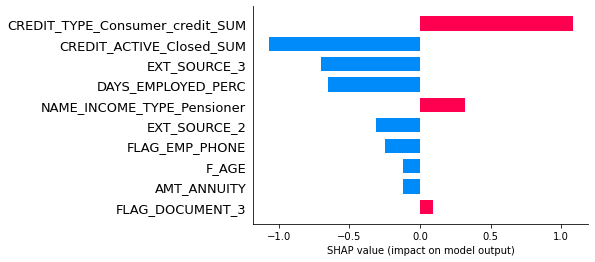

In [194]:
shap.bar_plot(log_reg_explainer.shap_values(X_test_trfm[0]),
#               feature_names=boston.feature_names,
              feature_names=shap_feature_names,
#               max_display=len(boston.feature_names))
              max_display=10)

# we saw here correlated features, like OBS_30_SOCIAL_CIRCLE and OBS_60_SOCIAL_CIRCLE
# also NONLIVINGAREA_AVG and NONLIVING_AREA_MEDI

Question: how to select the 10 features that I want to see? Not just 10 first. But either the 10 with maximal impact, or 10 specific features that I selected by their names (or indices, but by names is better).

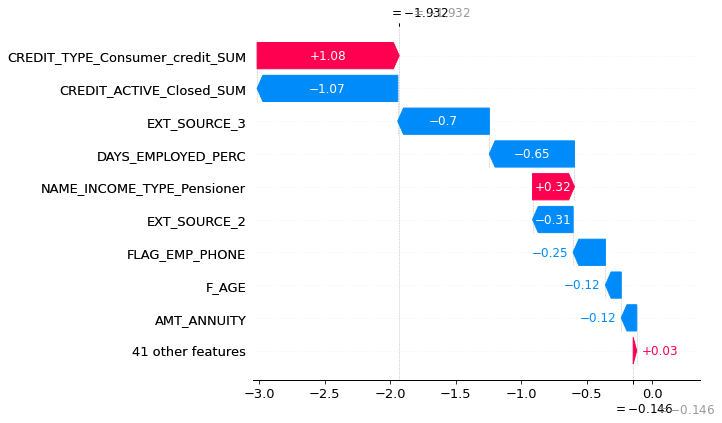

In [195]:
# waterfall_plot from source site from openclassrooms doesn't work anymore.
# maybe because the library was updated
# solution from internet (somewhere. github forum?)

shap.plots._waterfall.waterfall_legacy(log_reg_explainer.expected_value,
                    log_reg_explainer.shap_values(X_test_trfm[0]),
                    feature_names=shap_feature_names,
#                     max_display=len(shap_feature_names),
                    max_display=10,
                    )

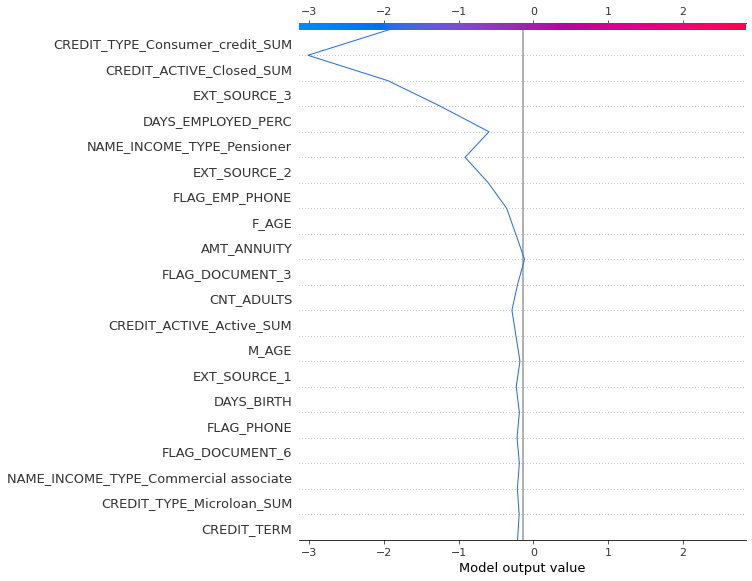

In [196]:
shap.decision_plot(log_reg_explainer.expected_value,
                   log_reg_explainer.shap_values(X_test_trfm[0]),
#                    feature_names=boston.feature_names.tolist(),
                    feature_names=shap_feature_names, # TypeError: The feature_names arg requires a list or numpy array.
#                     feature_names=shap_feature_names.tolist(), #AttributeError: 'list' object has no attribute 'tolist'
                   )

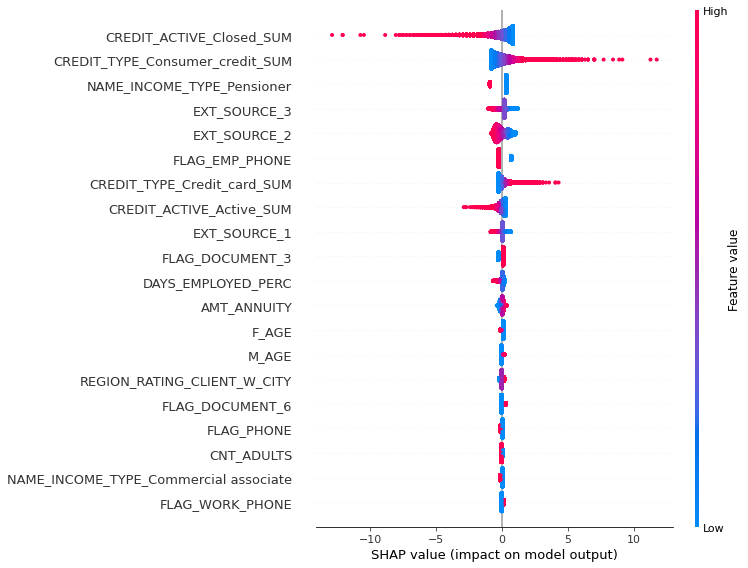

In [197]:
shap.summary_plot(log_reg_explainer.shap_values(X_test_trfm),
                  features = X_test_trfm,
                  feature_names=shap_feature_names)

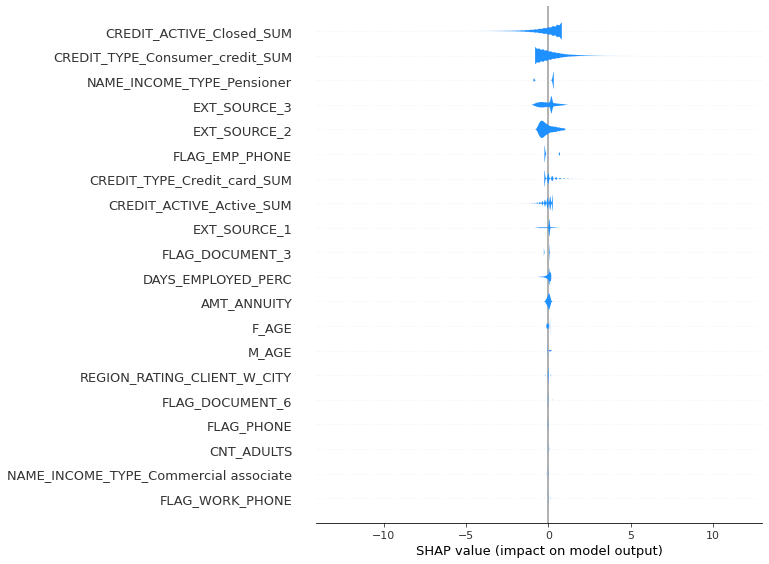

In [198]:
shap.summary_plot(log_reg_explainer.shap_values(X_test_trfm),
                  feature_names=shap_feature_names,
                  plot_type="violin",
                  color="dodgerblue")

# Test (API? Dashboard? Deployment?)

In [199]:
import joblib

In [200]:
joblib.dump(model_LogReg, 'credit_def_classif.joblib')

['credit_def_classif.joblib']

In [201]:
joblib.load('credit_def_classif.joblib')

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  Index(['AMT_ANNUITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'DAYS_EMPLOYED_PERC', 'CREDIT_TERM', 'STATUS_0_SUM', 'STATUS_1_SUM',
       'STATUS_2_SUM', 'STATUS_3_SUM', 'STATUS_4_SUM', 'STATUS_5_SUM',
       'STATUS_C_SUM', 'STATUS_X_SUM', '...
                                                  OneHotEncoder(categories=[array(['Working', 'State servant', 'Commercial associate', 'Pensioner',
       'Unemployed', 'Student', 'Businessman', 'Maternity leave'],
      dtype=object)],
                                                                drop='first'),
                                                  Index(['NAME_INCOME_TYPE'], dtype='object'))])),
                ('passthrough', 'passthr

In [202]:
from mlflow.models.signature import infer_signature

In [203]:
signature = infer_signature(X_train, y_train)

In [204]:
signature

inputs: 
  ['NAME_INCOME_TYPE': string, 'AMT_ANNUITY': double, 'EXT_SOURCE_1': double, 'EXT_SOURCE_2': double, 'EXT_SOURCE_3': double, 'DAYS_EMPLOYED_PERC': double, 'CREDIT_TERM': double, 'STATUS_0_SUM': double, 'STATUS_1_SUM': double, 'STATUS_2_SUM': double, 'STATUS_3_SUM': double, 'STATUS_4_SUM': double, 'STATUS_5_SUM': double, 'STATUS_C_SUM': double, 'STATUS_X_SUM': double, 'CREDIT_ACTIVE_Active_SUM': double, 'CREDIT_ACTIVE_Bad_debt_SUM': double, 'CREDIT_ACTIVE_Closed_SUM': double, 'CREDIT_ACTIVE_Sold_SUM': double, 'CREDIT_TYPE_Another_type_of_loan_SUM': double, 'CREDIT_TYPE_Cash_loan_(non-earmarked)_SUM': double, 'CREDIT_TYPE_Consumer_credit_SUM': double, 'CREDIT_TYPE_Credit_card_SUM': double, 'CREDIT_TYPE_Microloan_SUM': double, 'CREDIT_TYPE_Unknown_type_of_loan_SUM': double, 'DAYS_BIRTH': double, 'FLAG_EMP_PHONE': double, 'FLAG_WORK_PHONE': double, 'FLAG_PHONE': double, 'REGION_RATING_CLIENT_W_CITY': double, 'REG_CITY_NOT_LIVE_CITY': double, 'REG_CITY_NOT_WORK_CITY': double, 'LIV

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.

In [205]:
import mlflow.sklearn

In [206]:
mlflow.sklearn.save_model(model_LogReg, 'mlflow_model', signature=signature)

In [207]:
# np.zeros(107)

# \"working\", 1, 12
# 'NAME_INCOME_TYPE':'Working', 'FLAG_EMP_PHONE':1, 'AMT_CREDIT':12


# 'NAME_INCOME_TYPE', 'FLAG_EMP_PHONE', 'AMT_CREDIT'
# \"NAME_INCOME_TYPE\", \"FLAG_EMP_PHONE\", \"AMT_CREDIT\"
# \"NAME_INCOME_TYPE\":\"working\", \"FLAG_EMP_PHONE\":1, \"AMT_CREDIT\:12"
# NAME_INCOME_TYPE:\"working\", FLAG_EMP_PHONE:1, AMT_CREDIT:12
# {"NAME_INCOME_TYPE": "Working"}, {"FLAG_EMP_PHONE": 1}, {"AMT_CREDIT": 12}
# {\"NAME_INCOME_TYPE\": \"Working\"}, {\"FLAG_EMP_PHONE\": 1}, {\"AMT_CREDIT\": 12}
 
#  [{"name": "NAME_INCOME_TYPE", "type": "string"}, {"name": "FLAG_EMP_PHONE",
#     "type": "double"}, {"name": "AMT_CREDIT", "type": "double"}]
 
#  [{"NAME_INCOME_TYPE": "string"}, {"FLAG_EMP_PHONE": "double"}, {"AMT_CREDIT": "double"}]
 
# [{"NAME_INCOME_TYPE": "Working"}, {"FLAG_EMP_PHONE": 1}, {"AMT_CREDIT": 12}]
 
#  [{\"NAME_INCOME_TYPE\": \"Working\"}, {\"FLAG_EMP_PHONE\": 1}, {\"AMT_CREDIT\": 12}]

In [208]:
# ! curl http://127.0.0.1:5000/invocations -H "Content-Type: application/json" -d "{\"columns\": [\"NAME_INCOME_TYPE\",\"FLAG_EMP_PHONE\",\"AMT_CREDIT\"], \"data\":[[\"Working\", 1, 12]]}"
# #  this request worked correctly at older model with 3 variables, NAME INCOME TYPE, FLAG EMP PHONE and AMT CREDIT

# All the code below is draft code , not a part of the project

## Visualisation of the common graph, but with a line for an individual client

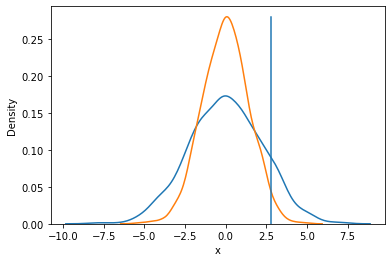

In [337]:
# Create some data
data = np.random.multivariate_normal([0, 0], [[5, 2], [2, 2]], size=2000)
data = pd.DataFrame(data, columns=['x', 'y'])

# Combined distributionplot
sns.kdeplot(data['x'])
sns.kdeplot(data['y'])
plt.axvline(2.8, 0, 0.95)

# can be also histplot, displot, distplot
# `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
# `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

## Variables list for dashboard and for json request

Copy signature from ML_model file. remove the word 'inputs' and single quotes.  
Replace {"name": (no space) with nothing.  
Replace "type": (no space) with nothing.  
Replace "double"}, (no space) with nothing.  
Replace "string"}, (no space) with nothing.  
Remove final string (should be   ,  "double"} because the variables were ordered.)  
Give the name to the object, add print() CAUTION: you get single quotes here. JSON doesn't handle single quotes.  
Copy the output in a new cell, replace snngle quotes with double quotes

In [213]:
print([ "NAME_INCOME_TYPE",    "AMT_ANNUITY",
       "EXT_SOURCE_1",    "EXT_SOURCE_2",
       "EXT_SOURCE_3",    "DAYS_EMPLOYED_PERC",
       "CREDIT_TERM",    "STATUS_0_SUM",
       "STATUS_1_SUM",    "STATUS_2_SUM",
       "STATUS_3_SUM",    "STATUS_4_SUM",
       "STATUS_5_SUM",    "STATUS_C_SUM",
       "STATUS_X_SUM",    "CREDIT_ACTIVE_Active_SUM",
       "CREDIT_ACTIVE_Bad_debt_SUM",   
    "CREDIT_ACTIVE_Closed_SUM",    "CREDIT_ACTIVE_Sold_SUM",
       "CREDIT_TYPE_Another_type_of_loan_SUM",  
     "CREDIT_TYPE_Cash_loan_(non-earmarked)_SUM",   
    "CREDIT_TYPE_Consumer_credit_SUM",    "CREDIT_TYPE_Credit_card_SUM",
       "CREDIT_TYPE_Microloan_SUM",   
    "CREDIT_TYPE_Unknown_type_of_loan_SUM",    "DAYS_BIRTH",
       "FLAG_EMP_PHONE",    "FLAG_WORK_PHONE",
       "FLAG_PHONE",    "REGION_RATING_CLIENT_W_CITY",
       "REG_CITY_NOT_LIVE_CITY",   
    "REG_CITY_NOT_WORK_CITY",    "LIVE_CITY_NOT_WORK_CITY",
       "FLAG_DOCUMENT_2",    "FLAG_DOCUMENT_3",
       "FLAG_DOCUMENT_6",    "FLAG_DOCUMENT_9",
       "FLAG_DOCUMENT_13",    "FLAG_DOCUMENT_14",
       "FLAG_DOCUMENT_16",    "FLAG_DOCUMENT_21",
       "F_AGE",    "M_AGE", 
      "CNT_ADULTS"])

['NAME_INCOME_TYPE', 'AMT_ANNUITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_EMPLOYED_PERC', 'CREDIT_TERM', 'STATUS_0_SUM', 'STATUS_1_SUM', 'STATUS_2_SUM', 'STATUS_3_SUM', 'STATUS_4_SUM', 'STATUS_5_SUM', 'STATUS_C_SUM', 'STATUS_X_SUM', 'CREDIT_ACTIVE_Active_SUM', 'CREDIT_ACTIVE_Bad_debt_SUM', 'CREDIT_ACTIVE_Closed_SUM', 'CREDIT_ACTIVE_Sold_SUM', 'CREDIT_TYPE_Another_type_of_loan_SUM', 'CREDIT_TYPE_Cash_loan_(non-earmarked)_SUM', 'CREDIT_TYPE_Consumer_credit_SUM', 'CREDIT_TYPE_Credit_card_SUM', 'CREDIT_TYPE_Microloan_SUM', 'CREDIT_TYPE_Unknown_type_of_loan_SUM', 'DAYS_BIRTH', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_21', 'F_AGE', 'M_AGE', 'CNT_ADULTS']


In [214]:
["NAME_INCOME_TYPE", "AMT_ANNUITY", "EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3", "DAYS_EMPLOYED_PERC", "CREDIT_TERM", "STATUS_0_SUM", "STATUS_1_SUM", "STATUS_2_SUM", "STATUS_3_SUM", "STATUS_4_SUM", "STATUS_5_SUM", "STATUS_C_SUM", "STATUS_X_SUM", "CREDIT_ACTIVE_Active_SUM", "CREDIT_ACTIVE_Bad_debt_SUM", "CREDIT_ACTIVE_Closed_SUM", "CREDIT_ACTIVE_Sold_SUM", "CREDIT_TYPE_Another_type_of_loan_SUM", "CREDIT_TYPE_Cash_loan_(non-earmarked)_SUM", "CREDIT_TYPE_Consumer_credit_SUM", "CREDIT_TYPE_Credit_card_SUM", "CREDIT_TYPE_Microloan_SUM", "CREDIT_TYPE_Unknown_type_of_loan_SUM", "DAYS_BIRTH", "FLAG_EMP_PHONE", "FLAG_WORK_PHONE", "FLAG_PHONE", "REGION_RATING_CLIENT_W_CITY", "REG_CITY_NOT_LIVE_CITY", "REG_CITY_NOT_WORK_CITY", "LIVE_CITY_NOT_WORK_CITY", "FLAG_DOCUMENT_2", "FLAG_DOCUMENT_3", "FLAG_DOCUMENT_6", "FLAG_DOCUMENT_9", "FLAG_DOCUMENT_13", "FLAG_DOCUMENT_14", "FLAG_DOCUMENT_16", "FLAG_DOCUMENT_21", "F_AGE", "M_AGE", "CNT_ADULTS"]

['NAME_INCOME_TYPE',
 'AMT_ANNUITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_EMPLOYED_PERC',
 'CREDIT_TERM',
 'STATUS_0_SUM',
 'STATUS_1_SUM',
 'STATUS_2_SUM',
 'STATUS_3_SUM',
 'STATUS_4_SUM',
 'STATUS_5_SUM',
 'STATUS_C_SUM',
 'STATUS_X_SUM',
 'CREDIT_ACTIVE_Active_SUM',
 'CREDIT_ACTIVE_Bad_debt_SUM',
 'CREDIT_ACTIVE_Closed_SUM',
 'CREDIT_ACTIVE_Sold_SUM',
 'CREDIT_TYPE_Another_type_of_loan_SUM',
 'CREDIT_TYPE_Cash_loan_(non-earmarked)_SUM',
 'CREDIT_TYPE_Consumer_credit_SUM',
 'CREDIT_TYPE_Credit_card_SUM',
 'CREDIT_TYPE_Microloan_SUM',
 'CREDIT_TYPE_Unknown_type_of_loan_SUM',
 'DAYS_BIRTH',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'REGION_RATING_CLIENT_W_CITY',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_21',
 'F_AGE',
 'M_AGE',
 'CNT_ADULTS']

In [215]:
len(["NAME_INCOME_TYPE", "AMT_ANNUITY", "EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3", "DAYS_EMPLOYED_PERC", "CREDIT_TERM", "STATUS_0_SUM", "STATUS_1_SUM", "STATUS_2_SUM", "STATUS_3_SUM", "STATUS_4_SUM", "STATUS_5_SUM", "STATUS_C_SUM", "STATUS_X_SUM", "CREDIT_ACTIVE_Active_SUM", "CREDIT_ACTIVE_Bad_debt_SUM", "CREDIT_ACTIVE_Closed_SUM", "CREDIT_ACTIVE_Sold_SUM", "CREDIT_TYPE_Another_type_of_loan_SUM", "CREDIT_TYPE_Cash_loan_(non-earmarked)_SUM", "CREDIT_TYPE_Consumer_credit_SUM", "CREDIT_TYPE_Credit_card_SUM", "CREDIT_TYPE_Microloan_SUM", "CREDIT_TYPE_Unknown_type_of_loan_SUM", "DAYS_BIRTH", "FLAG_EMP_PHONE", "FLAG_WORK_PHONE", "FLAG_PHONE", "REGION_RATING_CLIENT_W_CITY", "REG_CITY_NOT_LIVE_CITY", "REG_CITY_NOT_WORK_CITY", "LIVE_CITY_NOT_WORK_CITY", "FLAG_DOCUMENT_2", "FLAG_DOCUMENT_3", "FLAG_DOCUMENT_6", "FLAG_DOCUMENT_9", "FLAG_DOCUMENT_13", "FLAG_DOCUMENT_14", "FLAG_DOCUMENT_16", "FLAG_DOCUMENT_21", "F_AGE", "M_AGE", "CNT_ADULTS"])

44

In [216]:
# for fill the data field in the dashboard. remove the quotemarks from the variable names and modify the lists
#[NAME_INCOME_TYPE, AMT_ANNUITY, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, DAYS_EMPLOYED_PERC, CREDIT_TERM, STATUS_0_SUM, STATUS_1_SUM, STATUS_2_SUM, STATUS_3_SUM, STATUS_4_SUM, STATUS_5_SUM, STATUS_C_SUM, STATUS_X_SUM, CREDIT_ACTIVE_Active_SUM, CREDIT_ACTIVE_Bad_debt_SUM, CREDIT_ACTIVE_Closed_SUM, CREDIT_ACTIVE_Sold_SUM, CREDIT_TYPE_Another_type_of_loan_SUM, CREDIT_TYPE_Cash_loan_(non-earmarked)_SUM, CREDIT_TYPE_Consumer_credit_SUM, CREDIT_TYPE_Credit_card_SUM, CREDIT_TYPE_Microloan_SUM, CREDIT_TYPE_Unknown_type_of_loan_SUM, DAYS_BIRTH, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_PHONE, REGION_RATING_CLIENT_W_CITY, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY, FLAG_DOCUMENT_2, FLAG_DOCUMENT_3, FLAG_DOCUMENT_6, FLAG_DOCUMENT_9, FLAG_DOCUMENT_13, FLAG_DOCUMENT_14, FLAG_DOCUMENT_16, FLAG_DOCUMENT_21, F_AGE, M_AGE, CNT_ADULTS]

In [217]:
appli_new.NAME_INCOME_TYPE.unique() # for the dashboard, no need to replace single quotes with double quotes this time


array(['Working', 'State servant', 'Commercial associate', 'Pensioner',
       'Unemployed', 'Student', 'Businessman', 'Maternity leave'],
      dtype=object)

In [218]:
# for selecting status variable
status_unique = ['X', 'C', '0', '1', '2', '3', '4', '5']
STATUS = 'X'
full_list = [21, 12, 7]
[21, 12, *[int(i==STATUS) for i in status_unique], 7] # [21, 12, 0, 0, 1, 1]

[21, 12, 1, 0, 0, 0, 0, 0, 0, 0, 7]

How to extract the unique names of a variable:  
Either call the unique method whle working with the nested table, for every categorial variable. BUT MAKE SURE THE ORDER IS THE SAME AS IN SIGNATURE.

Or, if you don't want to check order or to flip a book many pages back:
Select strings regarding individual values of the variable in the columns list or in the cleaned signature.
Align in one string
Replace VARIABLE_NAME_ with nothing.
If you have a method, replace (underscore)METHOD with nothing.

In [219]:
"Another_type_of_loan", "Cash_loan_(non-earmarked)", "Consumer_credit", "Credit_card", "Microloan", "Unknown_type_of_loan",

('Another_type_of_loan',
 'Cash_loan_(non-earmarked)',
 'Consumer_credit',
 'Credit_card',
 'Microloan',
 'Unknown_type_of_loan')

In [220]:
DAYS_BIRTH = 16500
CODE_GENDER = 'M'
DAYS_BIRTH if CODE_GENDER == 'M' else 0, DAYS_BIRTH if CODE_GENDER == 'F' else 0

(16500, 0)

In [221]:
# "NAME_INCOME_TYPE",    "AMT_ANNUITY",
#        "EXT_SOURCE_1",    "EXT_SOURCE_2",
#        "EXT_SOURCE_3",    "DAYS_EMPLOYED_PERC",
#        "CREDIT_TERM",    "STATUS_0_SUM",
#        "STATUS_1_SUM",    "STATUS_2_SUM",
#        "STATUS_3_SUM",    "STATUS_4_SUM",
#        "STATUS_5_SUM",    "STATUS_C_SUM",
#        "STATUS_X_SUM",    "CREDIT_ACTIVE_Active_SUM",
#        "CREDIT_ACTIVE_Bad_debt_SUM",   
#     "CREDIT_ACTIVE_Closed_SUM",    "CREDIT_ACTIVE_Sold_SUM",
#        "CREDIT_TYPE_Another_type_of_loan_SUM",  
#      "CREDIT_TYPE_Cash_loan_(non-earmarked)_SUM",   
#     "CREDIT_TYPE_Consumer_credit_SUM",    "CREDIT_TYPE_Credit_card_SUM",
#        "CREDIT_TYPE_Microloan_SUM",   
#     "CREDIT_TYPE_Unknown_type_of_loan_SUM",    "DAYS_BIRTH",
#        "FLAG_EMP_PHONE",    "FLAG_WORK_PHONE",
#        "FLAG_PHONE",    "REGION_RATING_CLIENT_W_CITY",
#        "REG_CITY_NOT_LIVE_CITY",   
#     "REG_CITY_NOT_WORK_CITY",    "LIVE_CITY_NOT_WORK_CITY",
#        "FLAG_DOCUMENT_2",    "FLAG_DOCUMENT_3",
#        "FLAG_DOCUMENT_6",    "FLAG_DOCUMENT_9",
#        "FLAG_DOCUMENT_13",    "FLAG_DOCUMENT_14",
#        "FLAG_DOCUMENT_16",    "FLAG_DOCUMENT_21",
#        "F_AGE",    "M_AGE", 
#       "CNT_ADULTS"

How to make a JSON request for the API through the command prompt (Anaconda command prompt):
take the edited list of variables from the signature, the one with DOUBLE quotemarks.
Replace " with \" (please note that you still have a list, don(t remove the square brackets)
Incert any numbers in

In [222]:
# the column names for the json request through the API.
#[\"NAME_INCOME_TYPE\", \"AMT_ANNUITY\", \"EXT_SOURCE_1\", \"EXT_SOURCE_2\", \"EXT_SOURCE_3\", \"DAYS_EMPLOYED_PERC\", \"CREDIT_TERM\", \"STATUS_0_SUM\", \"STATUS_1_SUM\", \"STATUS_2_SUM\", \"STATUS_3_SUM\", \"STATUS_4_SUM\", \"STATUS_5_SUM\", \"STATUS_C_SUM\", \"STATUS_X_SUM\", \"CREDIT_ACTIVE_Active_SUM\", \"CREDIT_ACTIVE_Bad_debt_SUM\", \"CREDIT_ACTIVE_Closed_SUM\", \"CREDIT_ACTIVE_Sold_SUM\", \"CREDIT_TYPE_Another_type_of_loan_SUM\", \"CREDIT_TYPE_Cash_loan_(non-earmarked)_SUM\", \"CREDIT_TYPE_Consumer_credit_SUM\", \"CREDIT_TYPE_Credit_card_SUM\", \"CREDIT_TYPE_Microloan_SUM\", \"CREDIT_TYPE_Unknown_type_of_loan_SUM\", \"DAYS_BIRTH\", \"FLAG_EMP_PHONE\", \"FLAG_WORK_PHONE\", \"FLAG_PHONE\", \"REGION_RATING_CLIENT_W_CITY\", \"REG_CITY_NOT_LIVE_CITY\", \"REG_CITY_NOT_WORK_CITY\", \"LIVE_CITY_NOT_WORK_CITY\", \"FLAG_DOCUMENT_2\", \"FLAG_DOCUMENT_3\", \"FLAG_DOCUMENT_6\", \"FLAG_DOCUMENT_9\", \"FLAG_DOCUMENT_13\", \"FLAG_DOCUMENT_14\", \"FLAG_DOCUMENT_16\", \"FLAG_DOCUMENT_21\", \"F_AGE\", \"M_AGE\", \"CNT_ADULTS\"]

In [223]:
np.zeros(43)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [224]:
# if you uncomment this cell and execute it as well, 
# either either the kernel is waiting forever, or you can interrupt the kernel,
# and then this cell will execute with ^C (like I stopped the serve) and the previous one with the desired outcome [1.0]

# ! mlflow models serve -m mlflow_model/

^C


In [225]:
# if you launched the previous cell and then interrupted the kernel, you'll see the prediction [1.0]
# ! curl http://127.0.0.1:5000/invocations -H "Content-Type: application/json" -d "{\"columns\": [\"NAME_INCOME_TYPE\", \"AMT_ANNUITY\", \"EXT_SOURCE_1\", \"EXT_SOURCE_2\", \"EXT_SOURCE_3\", \"DAYS_EMPLOYED_PERC\", \"CREDIT_TERM\", \"STATUS_0_SUM\", \"STATUS_1_SUM\", \"STATUS_2_SUM\", \"STATUS_3_SUM\", \"STATUS_4_SUM\", \"STATUS_5_SUM\", \"STATUS_C_SUM\", \"STATUS_X_SUM\", \"CREDIT_ACTIVE_Active_SUM\", \"CREDIT_ACTIVE_Bad_debt_SUM\", \"CREDIT_ACTIVE_Closed_SUM\", \"CREDIT_ACTIVE_Sold_SUM\", \"CREDIT_TYPE_Another_type_of_loan_SUM\", \"CREDIT_TYPE_Cash_loan_(non-earmarked)_SUM\", \"CREDIT_TYPE_Consumer_credit_SUM\", \"CREDIT_TYPE_Credit_card_SUM\", \"CREDIT_TYPE_Microloan_SUM\", \"CREDIT_TYPE_Unknown_type_of_loan_SUM\", \"DAYS_BIRTH\", \"FLAG_EMP_PHONE\", \"FLAG_WORK_PHONE\", \"FLAG_PHONE\", \"REGION_RATING_CLIENT_W_CITY\", \"REG_CITY_NOT_LIVE_CITY\", \"REG_CITY_NOT_WORK_CITY\", \"LIVE_CITY_NOT_WORK_CITY\", \"FLAG_DOCUMENT_2\", \"FLAG_DOCUMENT_3\", \"FLAG_DOCUMENT_6\", \"FLAG_DOCUMENT_9\", \"FLAG_DOCUMENT_13\", \"FLAG_DOCUMENT_14\", \"FLAG_DOCUMENT_16\", \"FLAG_DOCUMENT_21\", \"F_AGE\", \"M_AGE\", \"CNT_ADULTS\"], \"data\":[[\"Working\", 10, 0.2, 0.3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]}"

[1.0]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  1117  100     5  100  1112    105  23428 --:--:-- --:--:-- --:--:-- 24282


## How to insert graphics (for example kdeplot in the dashboard)

In [289]:
appli_tr['YEARS_BIRTH'] = appli_tr['DAYS_BIRTH'] / 365.25

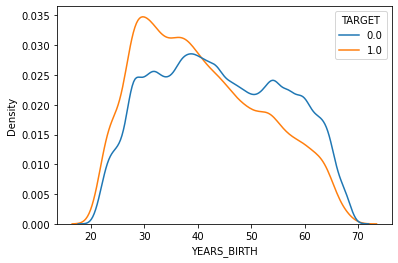

In [290]:
age_kde = sns.kdeplot(data=appli_tr, x='YEARS_BIRTH', hue='TARGET', common_norm=False)

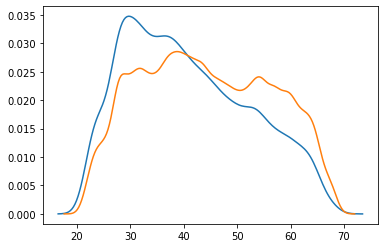

In [292]:
age_kde # <AxesSubplot:xlabel='DAYS_BIRTH', ylabel='Density'>
x_fail, y_fail = age_kde.get_lines()[0].get_data()
x_ok, y_ok = age_kde.get_lines()[1].get_data()
plt.plot(x_fail, y_fail)
plt.plot(x_ok, y_ok)

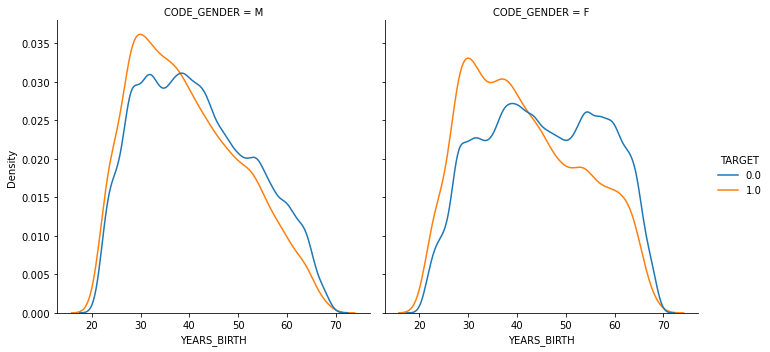

In [291]:
age_sex_kde = sns.displot(data=appli_tr, x='YEARS_BIRTH', hue='TARGET', col='CODE_GENDER', kind='kde', common_norm=False)

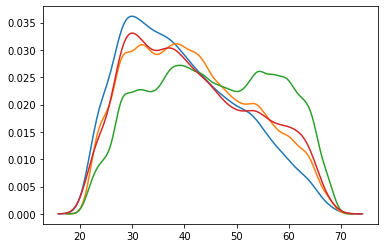

In [344]:
age_sex_kde.axes[0][0] # <AxesSubplot:title={'center':'CODE_GENDER = M'}, xlabel='DAYS_BIRTH', ylabel='Density'>
age_sex_kde.axes[0][1] # <AxesSubplot:title={'center':'CODE_GENDER = F'}, xlabel='DAYS_BIRTH'>


# CAUTION: somehow for the male the traget 0 and 1 are inversed!
male_ok_x, male_ok_y = age_sex_kde.axes[0][0].get_lines()[0].get_data()
male_fail_x, male_fail_y = age_sex_kde.axes[0][0].get_lines()[1].get_data()

female_fail_x, female_fail_y = age_sex_kde.axes[0][1].get_lines()[0].get_data()
female_ok_x, female_ok_y = age_sex_kde.axes[0][1].get_lines()[1].get_data()

plt.plot(male_ok_x, male_ok_y)
plt.plot(male_fail_x, male_fail_y)
plt.plot(female_ok_x, female_ok_y)
plt.plot(female_fail_x, female_fail_y)


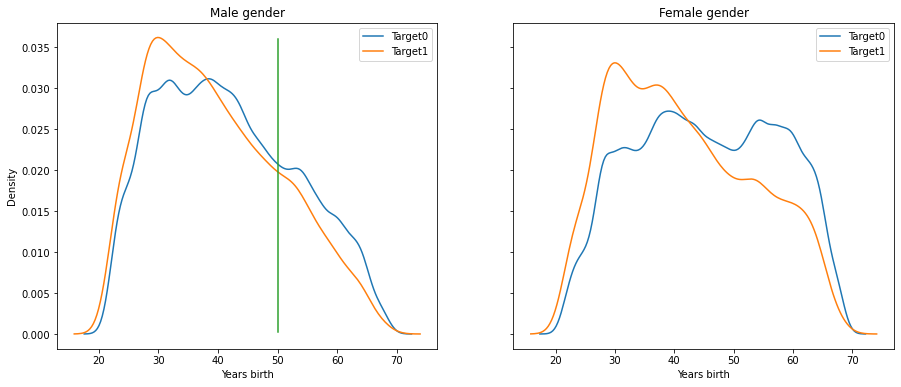

In [368]:
    fig, (ax_male, ax_female) = plt.subplots(1, 2, figsize=(15,6), sharey=True)

    # CAUTION: somehow for the male the traget 0 and 1 are inversed! that's why I switch colors here
    ax_male.plot(male_fail_x, male_fail_y, 'tab:blue', label='Target0')
    ax_male.plot(male_ok_x, male_ok_y, 'tab:orange', label='Target1')
    ax_female.plot(female_ok_x, female_ok_y, label='Target0')
    ax_female.plot(female_fail_x, female_fail_y, label='Target1')

    ax_male.set_title('Male gender')
    ax_male.set_xlabel('Years birth')
    ax_male.set_ylabel('Density')
    ax_male.legend()

    ax_female.set_title('Female gender')
    ax_female.set_xlabel('Years birth')
    ax_male.axvline(50, 0.05, 0.95, color='tab:green')
    ax_female.legend()

In [366]:
# for the dashboard
female_fail_y

array([1.12993143e-05, 1.96313389e-05, 3.32565407e-05, 5.49448958e-05,
       8.85525678e-05, 1.39253423e-04, 2.13725518e-04, 3.20239958e-04,
       4.68591934e-04, 6.69815437e-04, 9.35637902e-04, 1.27766075e-03,
       1.70629531e-03, 2.22953587e-03, 2.85170379e-03, 3.57233791e-03,
       4.38542433e-03, 5.27914621e-03, 6.23628561e-03, 7.23533071e-03,
       8.25224132e-03, 9.26272153e-03, 1.02447568e-02, 1.11811114e-02,
       1.20614625e-02, 1.28838695e-02, 1.36553467e-02, 1.43914018e-02,
       1.51145259e-02, 1.58517447e-02, 1.66314608e-02, 1.74799228e-02,
       1.84177273e-02, 1.94567921e-02, 2.05982164e-02, 2.18313549e-02,
       2.31342918e-02, 2.44757039e-02, 2.58178947e-02, 2.71205883e-02,
       2.83449420e-02, 2.94572028e-02, 3.04314997e-02, 3.12514332e-02,
       3.19103479e-02, 3.24104121e-02, 3.27608233e-02, 3.29755692e-02,
       3.30711902e-02, 3.30649070e-02, 3.29733360e-02, 3.28118526e-02,
       3.25945130e-02, 3.23343491e-02, 3.20438110e-02, 3.17351507e-02,
      

In [367]:
print([1.12993143e-05, 1.96313389e-05, 3.32565407e-05, 5.49448958e-05,
       8.85525678e-05, 1.39253423e-04, 2.13725518e-04, 3.20239958e-04,
       4.68591934e-04, 6.69815437e-04, 9.35637902e-04, 1.27766075e-03,
       1.70629531e-03, 2.22953587e-03, 2.85170379e-03, 3.57233791e-03,
       4.38542433e-03, 5.27914621e-03, 6.23628561e-03, 7.23533071e-03,
       8.25224132e-03, 9.26272153e-03, 1.02447568e-02, 1.11811114e-02,
       1.20614625e-02, 1.28838695e-02, 1.36553467e-02, 1.43914018e-02,
       1.51145259e-02, 1.58517447e-02, 1.66314608e-02, 1.74799228e-02,
       1.84177273e-02, 1.94567921e-02, 2.05982164e-02, 2.18313549e-02,
       2.31342918e-02, 2.44757039e-02, 2.58178947e-02, 2.71205883e-02,
       2.83449420e-02, 2.94572028e-02, 3.04314997e-02, 3.12514332e-02,
       3.19103479e-02, 3.24104121e-02, 3.27608233e-02, 3.29755692e-02,
       3.30711902e-02, 3.30649070e-02, 3.29733360e-02, 3.28118526e-02,
       3.25945130e-02, 3.23343491e-02, 3.20438110e-02, 3.17351507e-02,
       3.14206001e-02, 3.11122794e-02, 3.08218454e-02, 3.05599518e-02,
       3.03356271e-02, 3.01556785e-02, 3.00242151e-02, 2.99423549e-02,
       2.99081463e-02, 2.99167049e-02, 2.99605499e-02, 3.00301071e-02,
       3.01143454e-02, 3.02015036e-02, 3.02798622e-02, 3.03385044e-02,
       3.03680068e-02, 3.03609947e-02, 3.03125092e-02, 3.02201513e-02,
       3.00839966e-02, 2.99063085e-02, 2.96911041e-02, 2.94436437e-02,
       2.91699159e-02, 2.88761769e-02, 2.85685775e-02, 2.82528875e-02,
       2.79343016e-02, 2.76173036e-02, 2.73055611e-02, 2.70018336e-02,
       2.67078917e-02, 2.64244576e-02, 2.61511885e-02, 2.58867228e-02,
       2.56288065e-02, 2.53744993e-02, 2.51204472e-02, 2.48631968e-02,
       2.45995174e-02, 2.43267004e-02, 2.40428089e-02, 2.37468628e-02,
       2.34389495e-02, 2.31202561e-02, 2.27930180e-02, 2.24603830e-02,
       2.21261898e-02, 2.17946734e-02, 2.14701232e-02, 2.11565373e-02,
       2.08573257e-02, 2.05751165e-02, 2.03117027e-02, 2.00681374e-02,
       1.98449532e-02, 1.96424490e-02, 1.94609691e-02, 1.93010976e-02,
       1.91637113e-02, 1.90498613e-02, 1.89604928e-02, 1.88960469e-02,
       1.88560125e-02, 1.88385149e-02, 1.88400257e-02, 1.88552709e-02,
       1.88773873e-02, 1.88983440e-02, 1.89096017e-02, 1.89029364e-02,
       1.88713137e-02, 1.88096797e-02, 1.87155353e-02, 1.85891917e-02,
       1.84336645e-02, 1.82542269e-02, 1.80577107e-02, 1.78516843e-02,
       1.76436478e-02, 1.74403642e-02, 1.72473979e-02, 1.70688751e-02,
       1.69074322e-02, 1.67642916e-02, 1.66394007e-02, 1.65315870e-02,
       1.64387141e-02, 1.63578426e-02, 1.62854149e-02, 1.62174744e-02,
       1.61499124e-02, 1.60787122e-02, 1.60001454e-02, 1.59108728e-02,
       1.58079183e-02, 1.56885117e-02, 1.55498293e-02, 1.53886899e-02,
       1.52012815e-02, 1.49829962e-02, 1.47284358e-02, 1.44316263e-02,
       1.40864445e-02, 1.36872239e-02, 1.32294740e-02, 1.27106203e-02,
       1.21306587e-02, 1.14926156e-02, 1.08027263e-02, 1.00702740e-02,
       9.30708439e-03, 8.52672259e-03, 7.74349177e-03, 6.97136885e-03,
       6.22302455e-03, 5.50905937e-03, 4.83754494e-03, 4.21390207e-03,
       3.64108503e-03, 3.11999128e-03, 2.64998696e-03, 2.22943654e-03,
       1.85614668e-03, 1.52767208e-03, 1.24147272e-03, 9.94947956e-04,
       7.85394287e-04, 6.09939639e-04, 4.65498159e-04, 3.48772318e-04,
       2.56309185e-04, 1.84600983e-04, 1.30209648e-04, 8.98921225e-05,
       6.07062382e-05, 4.00840320e-05, 2.58674644e-05, 1.63087033e-05,
       1.00420878e-05, 6.03722841e-06, 3.54276059e-06, 2.02874620e-06])

[1.12993143e-05, 1.96313389e-05, 3.32565407e-05, 5.49448958e-05, 8.85525678e-05, 0.000139253423, 0.000213725518, 0.000320239958, 0.000468591934, 0.000669815437, 0.000935637902, 0.00127766075, 0.00170629531, 0.00222953587, 0.00285170379, 0.00357233791, 0.00438542433, 0.00527914621, 0.00623628561, 0.00723533071, 0.00825224132, 0.00926272153, 0.0102447568, 0.0111811114, 0.0120614625, 0.0128838695, 0.0136553467, 0.0143914018, 0.0151145259, 0.0158517447, 0.0166314608, 0.0174799228, 0.0184177273, 0.0194567921, 0.0205982164, 0.0218313549, 0.0231342918, 0.0244757039, 0.0258178947, 0.0271205883, 0.028344942, 0.0294572028, 0.0304314997, 0.0312514332, 0.0319103479, 0.0324104121, 0.0327608233, 0.0329755692, 0.0330711902, 0.033064907, 0.032973336, 0.0328118526, 0.032594513, 0.0323343491, 0.032043811, 0.0317351507, 0.0314206001, 0.0311122794, 0.0308218454, 0.0305599518, 0.0303356271, 0.0301556785, 0.0300242151, 0.0299423549, 0.0299081463, 0.0299167049, 0.0299605499, 0.0300301071, 0.0301143454, 0.030